In [64]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("../../../mathematical_models"))
from mathematical_models.f_on_f import FunctionOnFunctionModel
from mathematical_models.s_on_f import ScalarOnFunctionModel
from datetime import datetime

sys.path.append(os.path.abspath("../../../optimizers"))
from optimizers.cordex_continuous import CordexContinuous
from optimizers.nbdo import NBDO

sys.path.append(os.path.abspath("../../basis"))
from basis.bspline import BSplineBasis
from basis.polynomial import PolynomialBasis
from basis.fourier import FourierBasis
from basis.basis import plot_design
from basis.basis import Basis

from J.jmatrix import JMatrix

In [14]:
from scipy.integrate import quad
from scipy.misc import derivative
from scipy.linalg import block_diag

def compute_DER_MAT(basis_pair, const=True):
    R_blocks = []

    for _, b_base in basis_pair:
        num_basis = b_base.num_basis()

        def second_derivative(i, t):
            return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)

        R = np.zeros((num_basis, num_basis))
        for i in range(num_basis):
            for j in range(num_basis):
                integrand = lambda t: second_derivative(i, t) * second_derivative(j, t)
                R[i, j], _ = quad(integrand, 0, 1)

        R_blocks.append(R)

    # Create block diagonal matrix from all R_blocks
    R_combined = block_diag(*R_blocks)
    if const:
        # Expand the final matrix to include the leading 1
        final_size = R_combined.shape[0] + 1
        R_with_one = np.zeros((final_size, final_size))
        R_with_one[0, 0] = 1
        R_with_one[1:, 1:] = R_combined

        return R_with_one
    else:
        return R_combined

In [63]:
np.round(np.logspace(-3, 1, 6),4)

array([1.0000e-03, 6.3000e-03, 3.9800e-02, 2.5120e-01, 1.5849e+00,
       1.0000e+01])

### B splines - Polynomial - Fourier

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


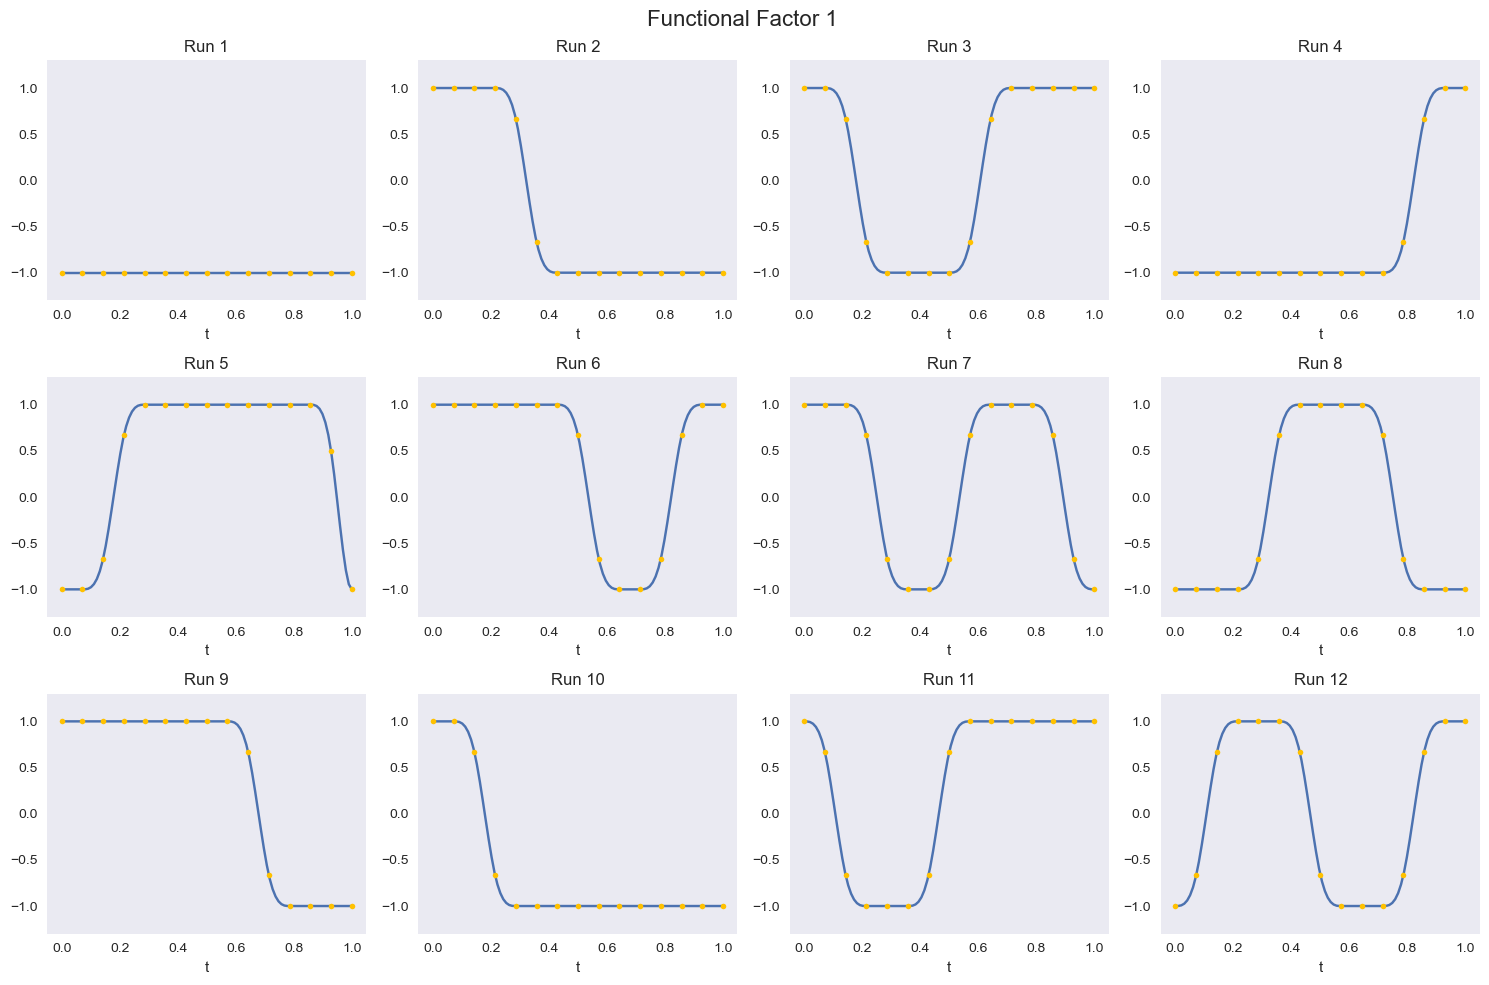

lambda_s: 1.7499999747320546e-05, lambda_t: 1.026599914013716e-09, objective: 3.7460082324995066e+141


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


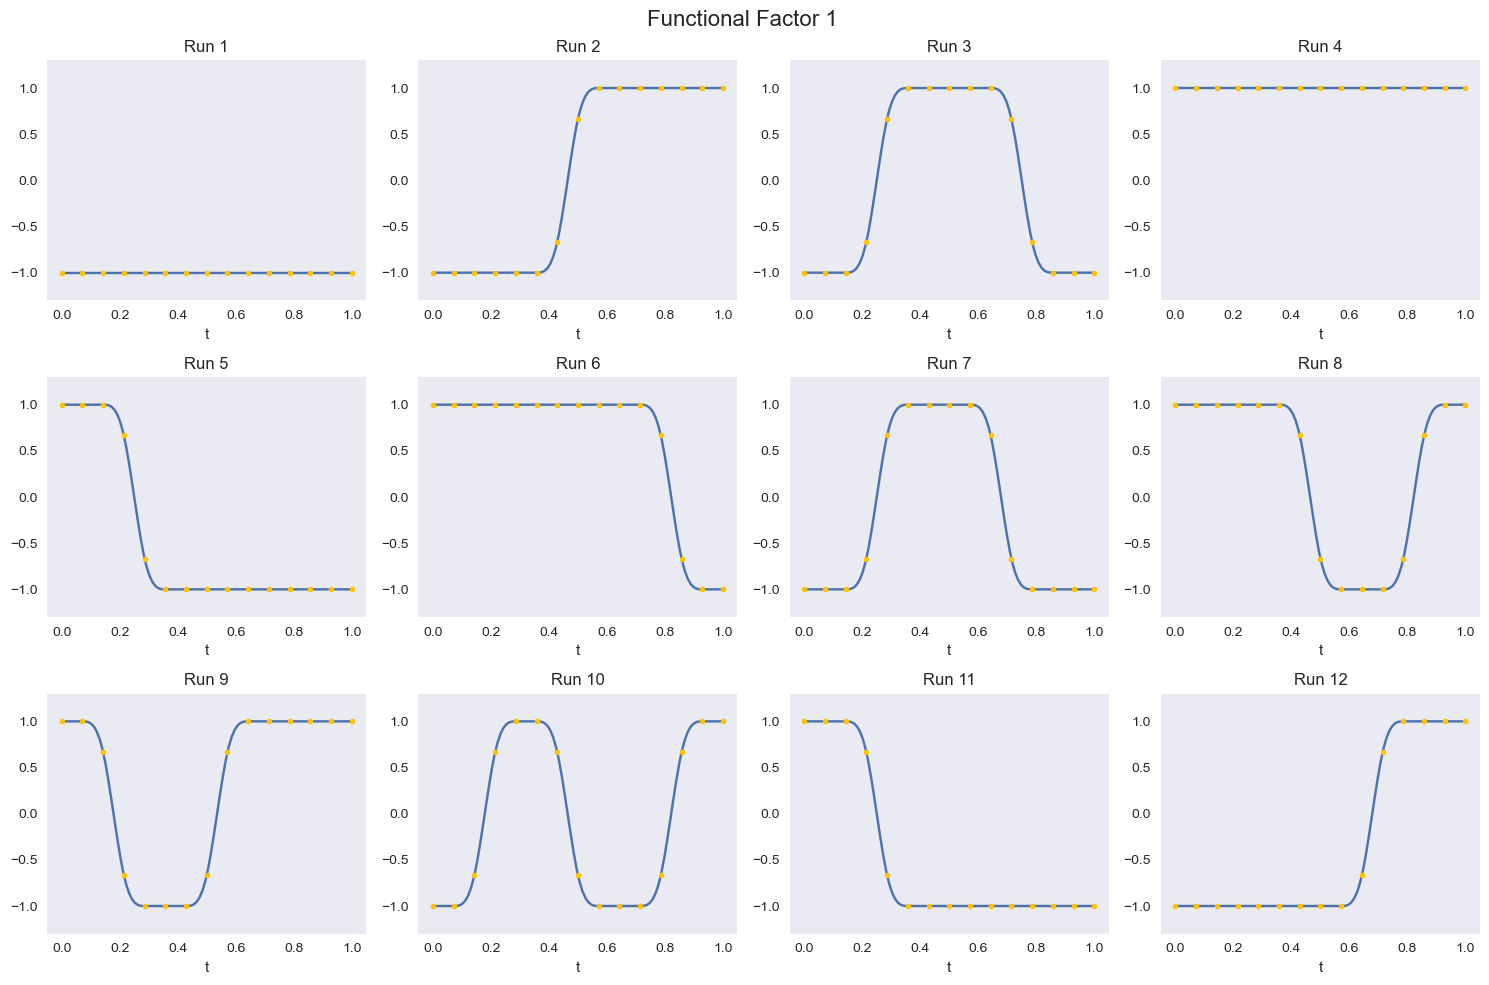

lambda_s: 0.00011041753368973421, lambda_t: 6.477407555896888e-09, objective: 1.3571153643310622e+125


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


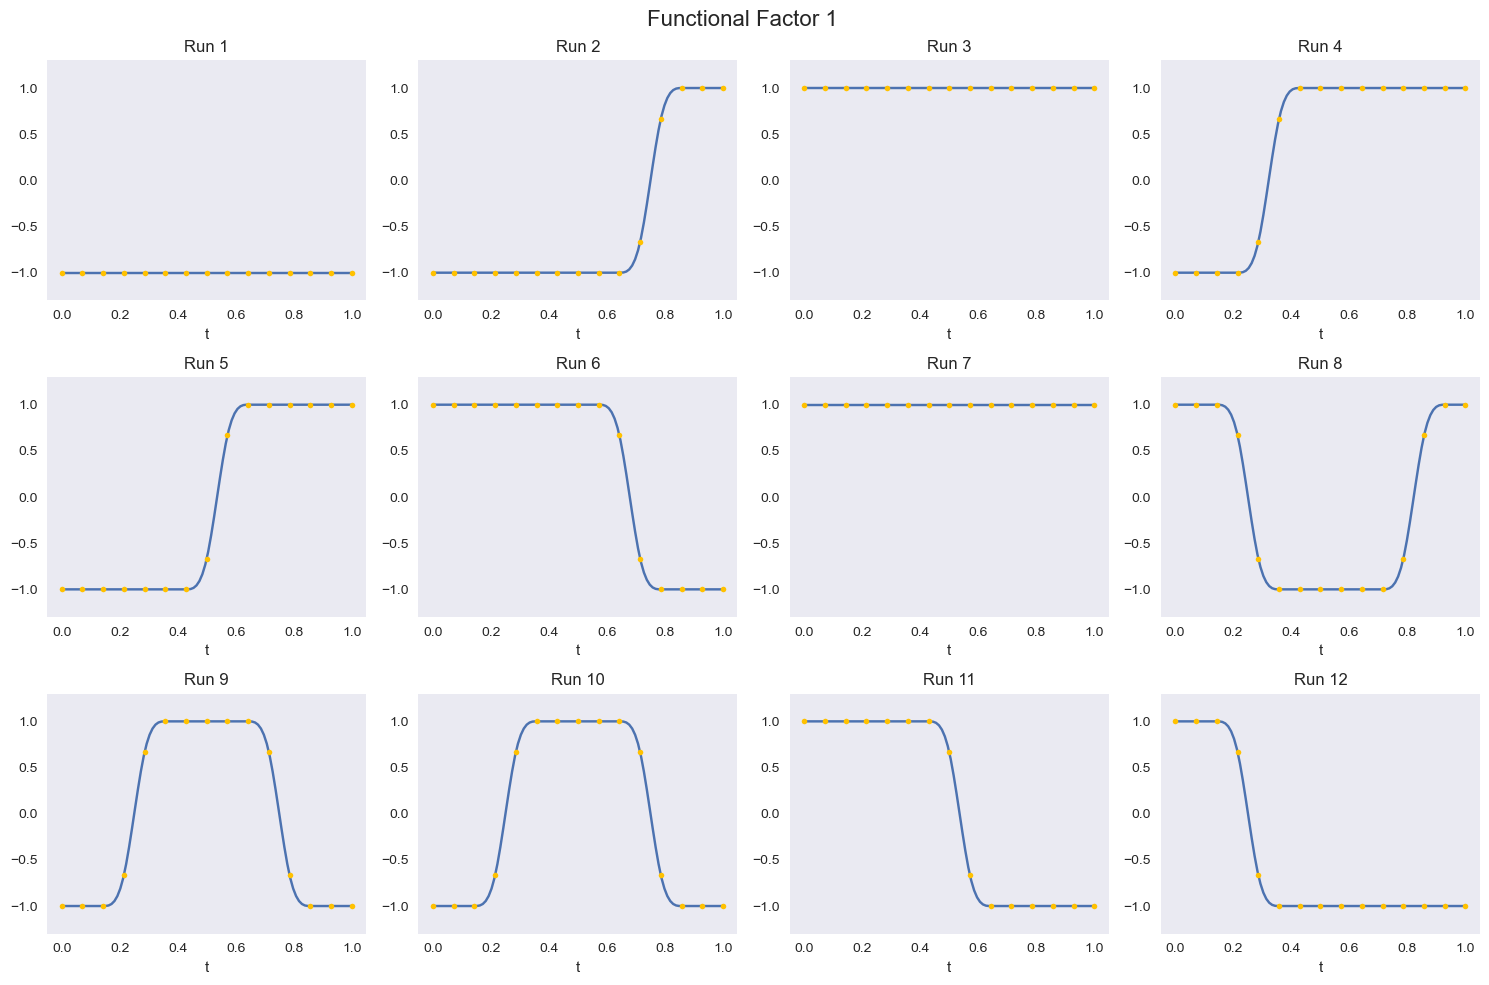

lambda_s: 0.0006966875384092701, lambda_t: 4.0869678705846416e-08, objective: 2.46054066215314e+104


  2%|▏         | 2/100 [00:04<03:41,  2.26s/it]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


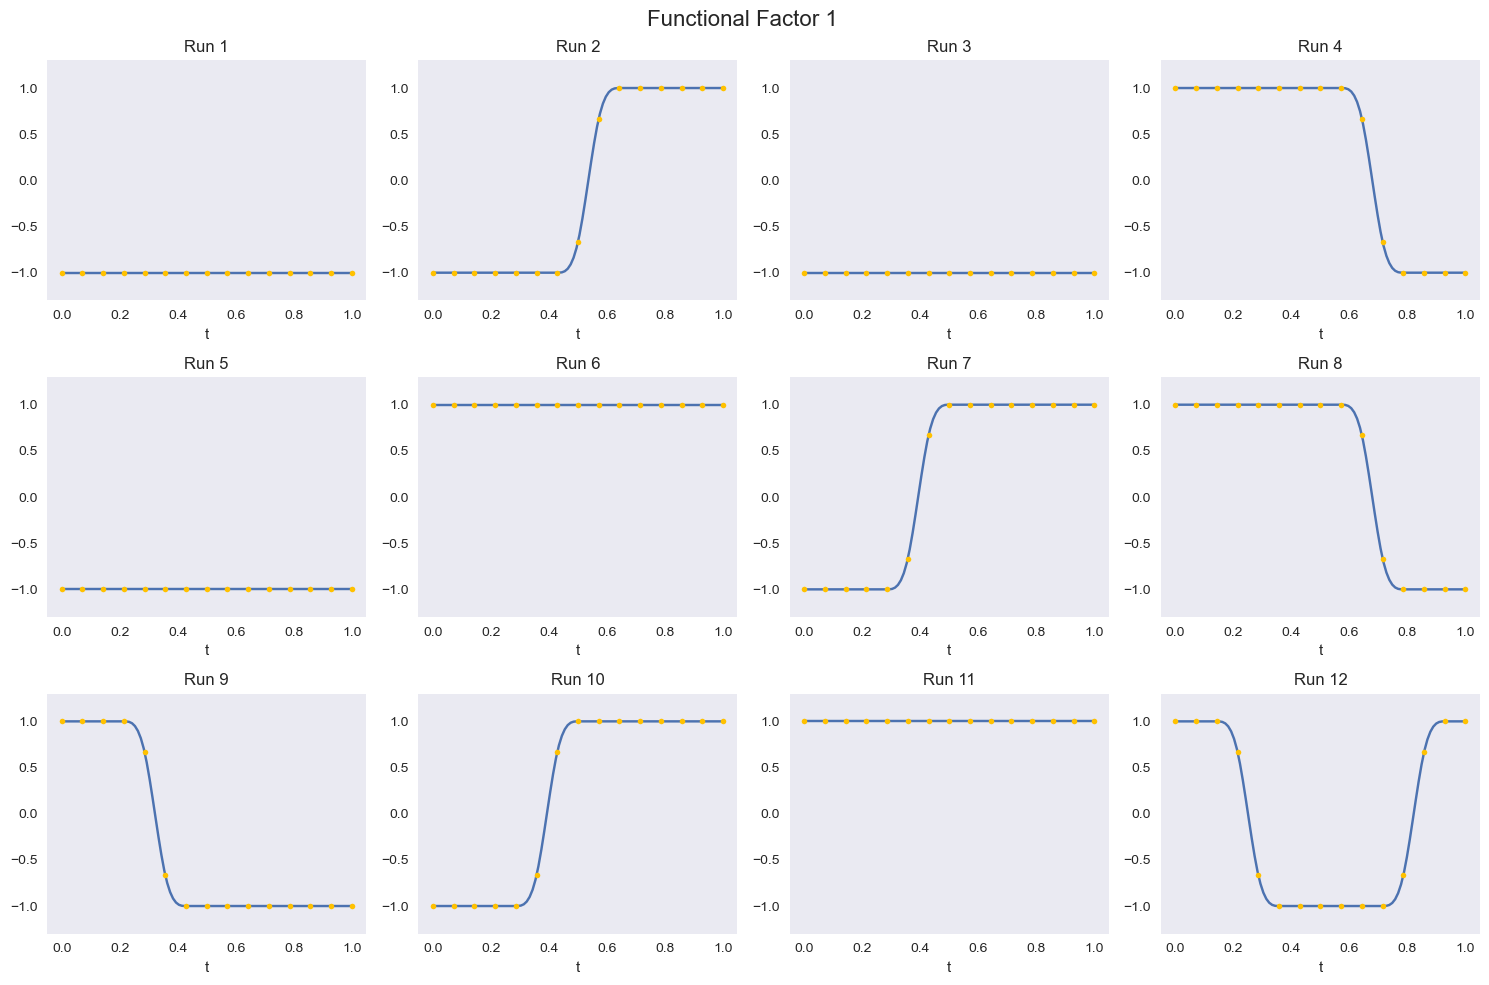

lambda_s: 0.00439580119167156, lambda_t: 2.5787023945999573e-07, objective: 5.5411359956071e+77


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


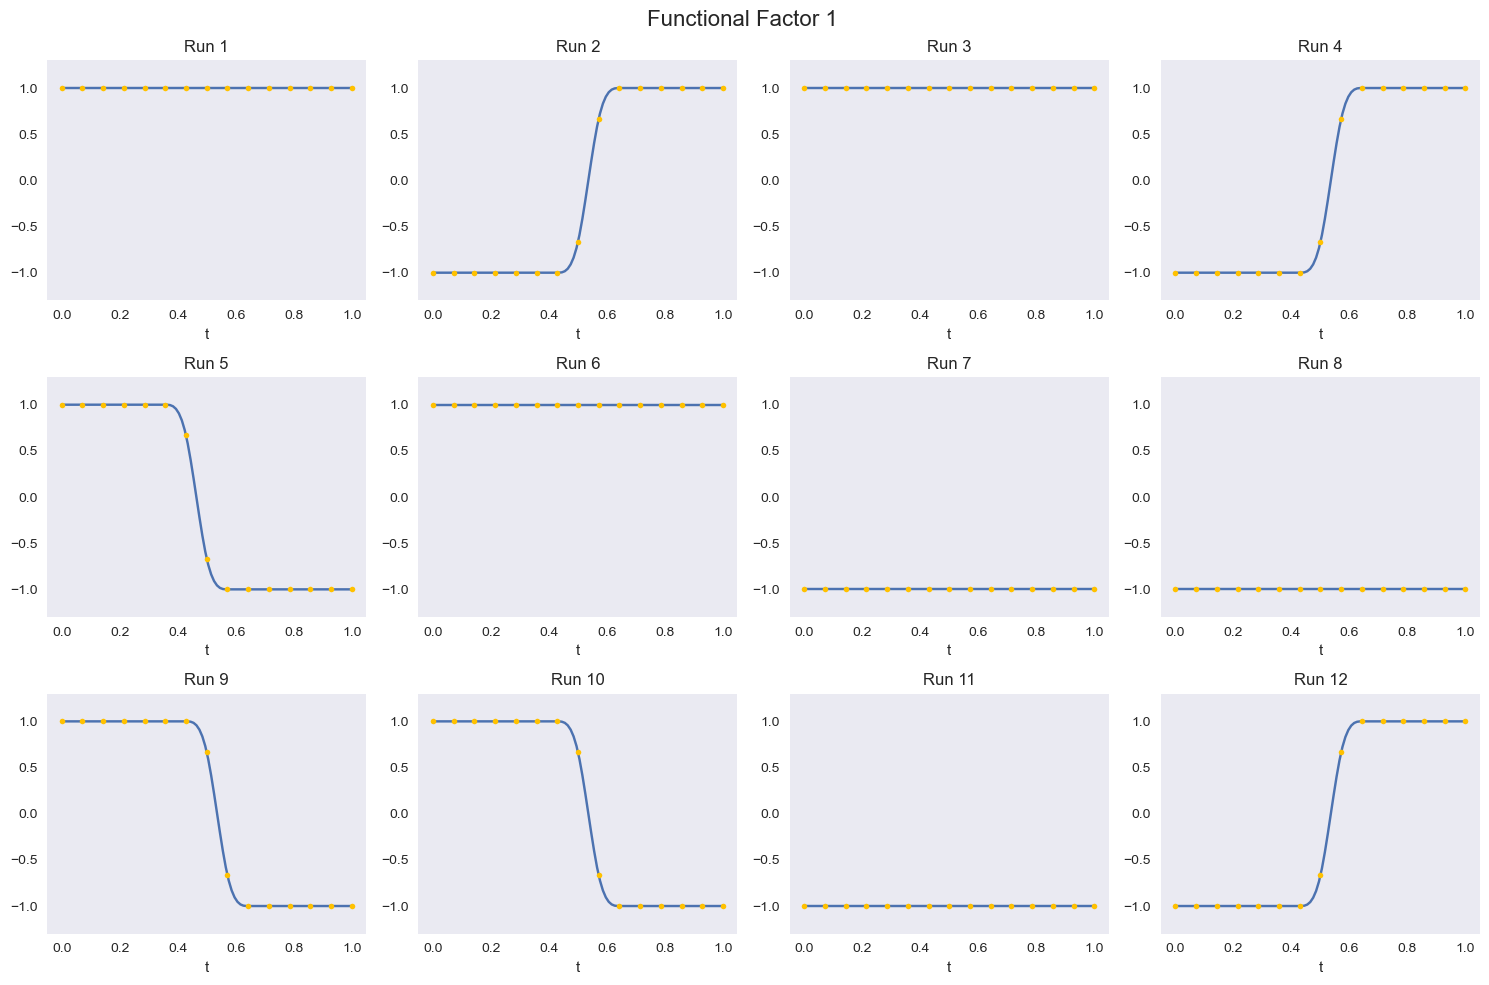

lambda_s: 0.027735630467599547, lambda_t: 1.6270512151015036e-06, objective: 7.827915095508567e+45


  1%|          | 1/100 [00:03<05:56,  3.60s/it]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


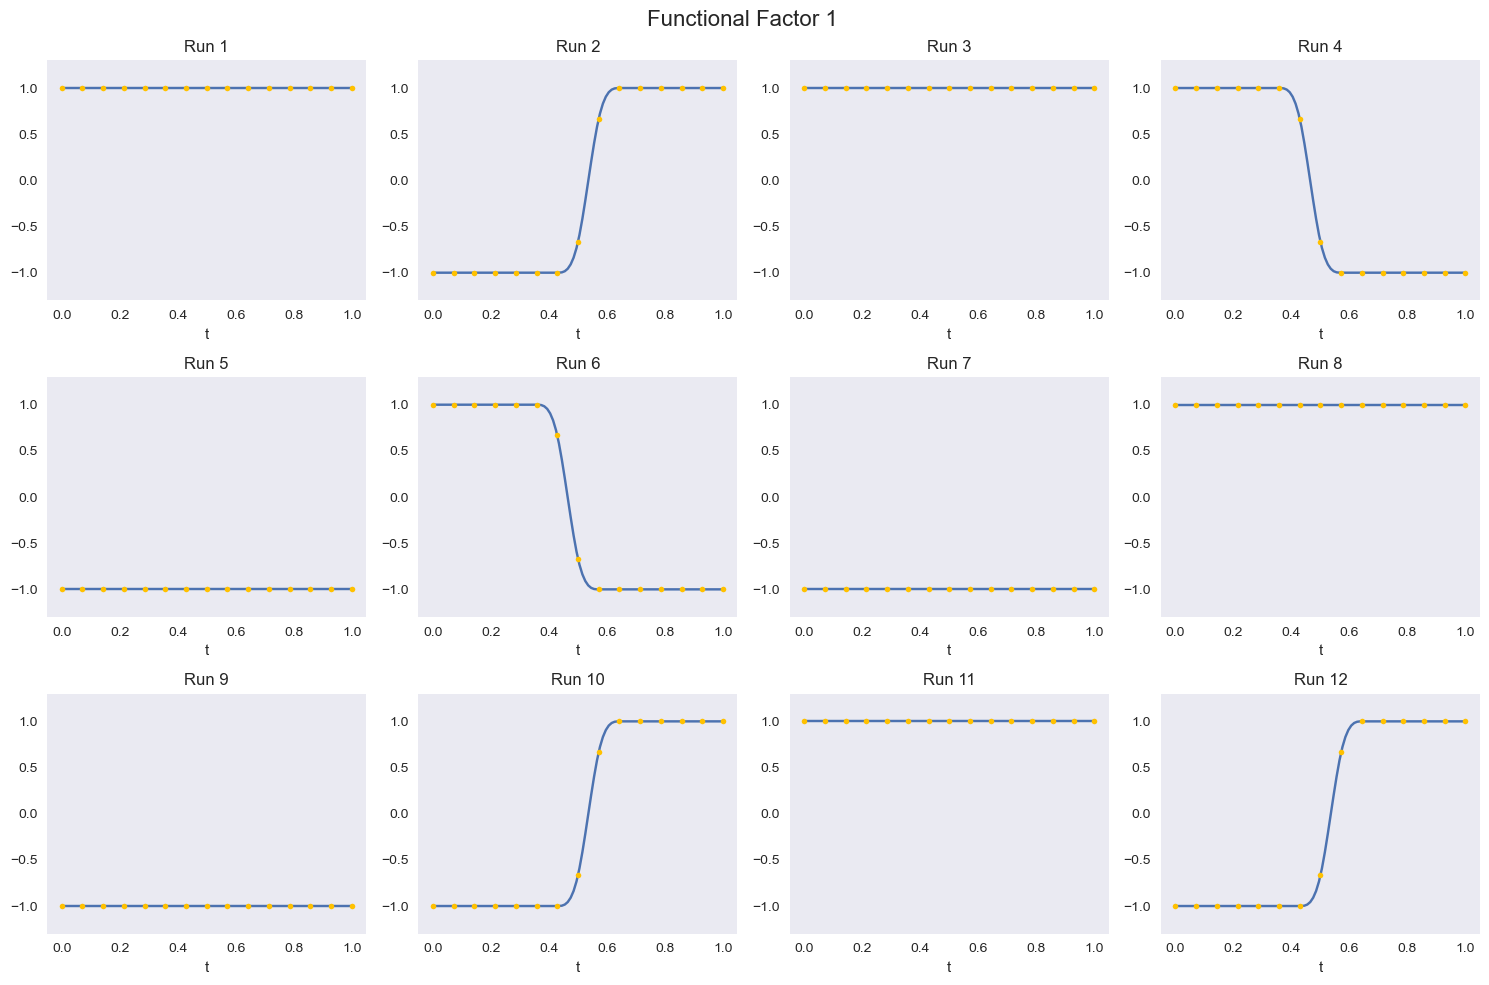

lambda_s: 0.17499999747320544, lambda_t: 1.0265999140137161e-05, objective: 353051780076.9186


In [56]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = PolynomialBasis(degree=6) # H
bt_base = FourierBasis(num_basis_functions=10) # theta
lambdas = np.logspace(-3, 1, 6)

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=12)
    best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
    plot_design(best_design, [x_base], 12,
                sub_x=3, sub_y=4, colour="#FFC100")
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}")

### B splines - B splines - Fourier

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


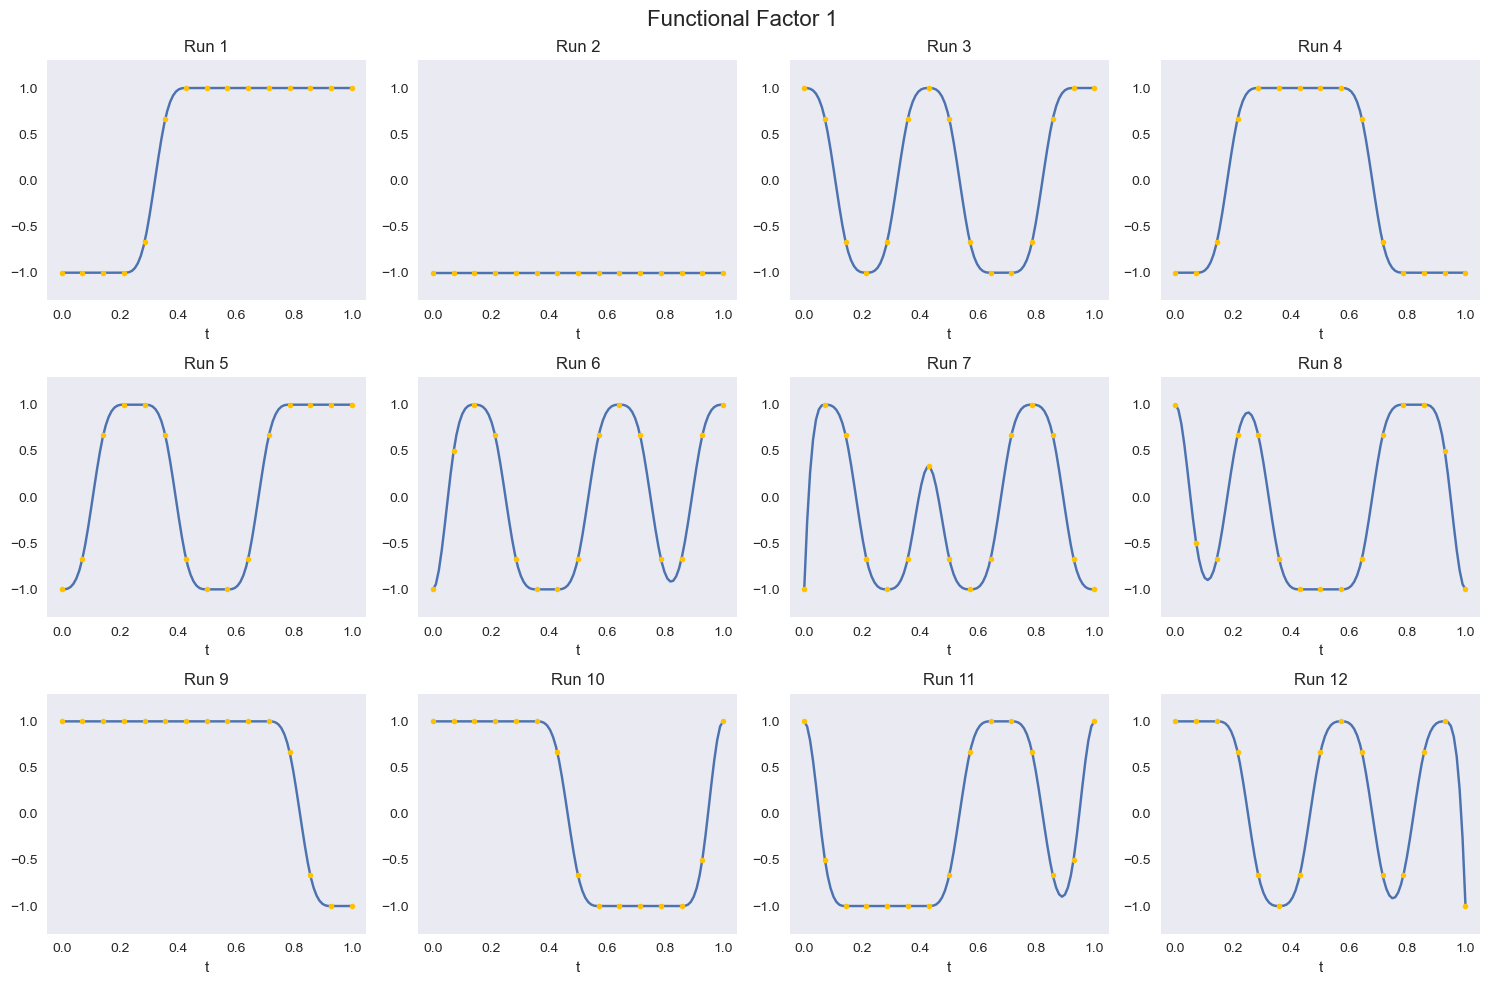

lambda_s: 2.8306156630470603e-07, lambda_t: 1.026599914013716e-09, objective: 2.592557665782176e+116


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


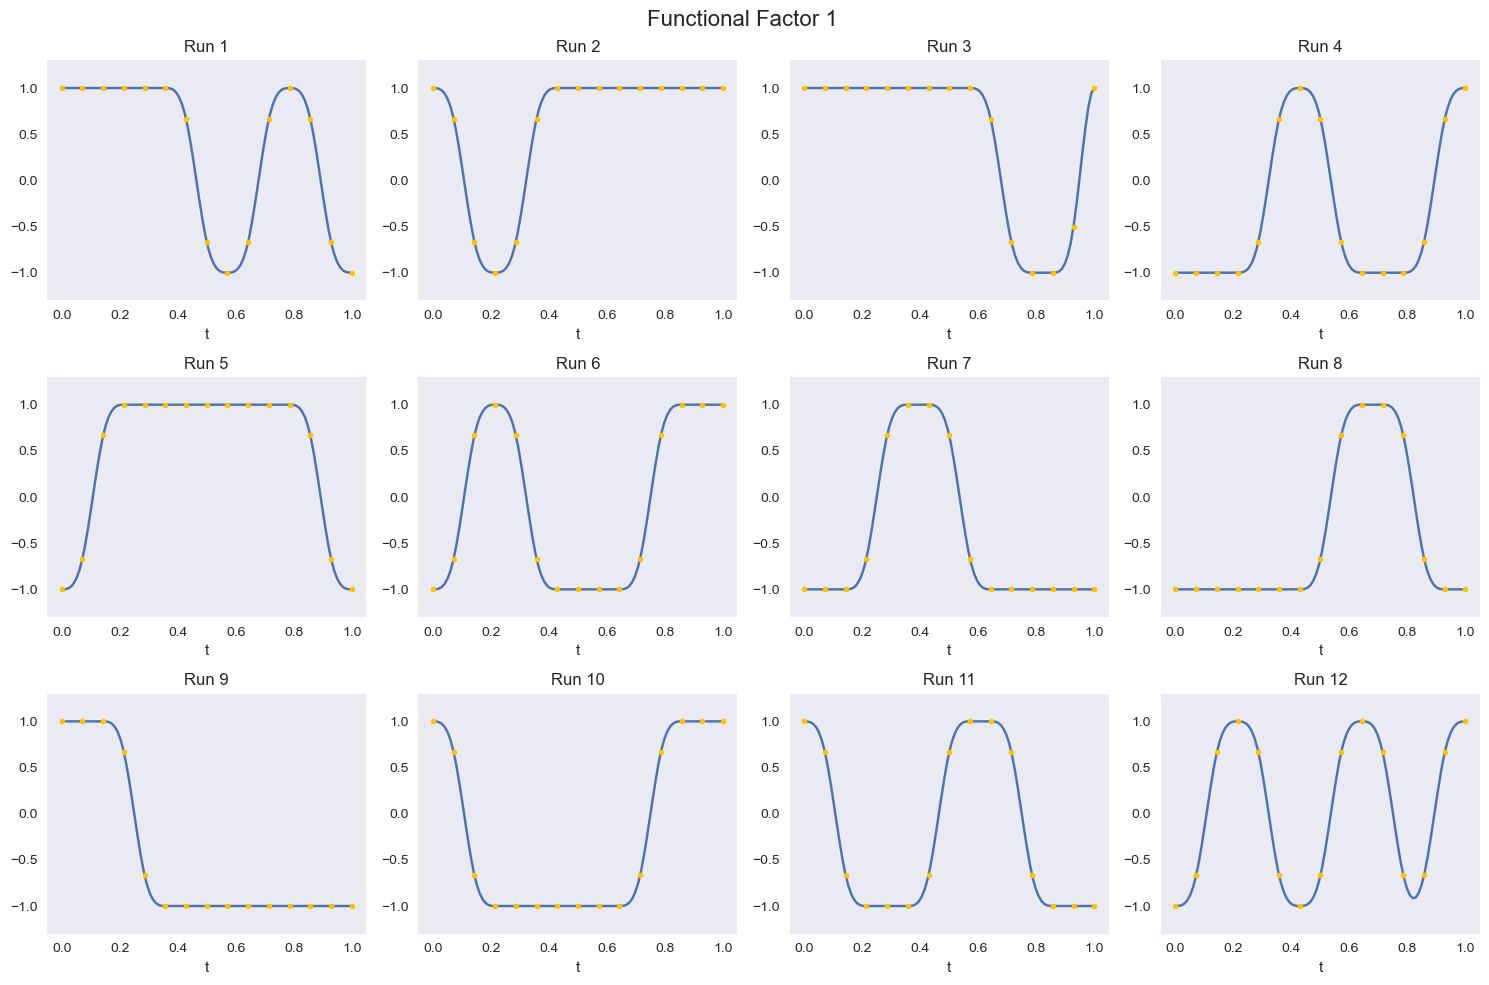

lambda_s: 1.785997742000214e-06, lambda_t: 6.477407555896888e-09, objective: 4.240947151900984e+103


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


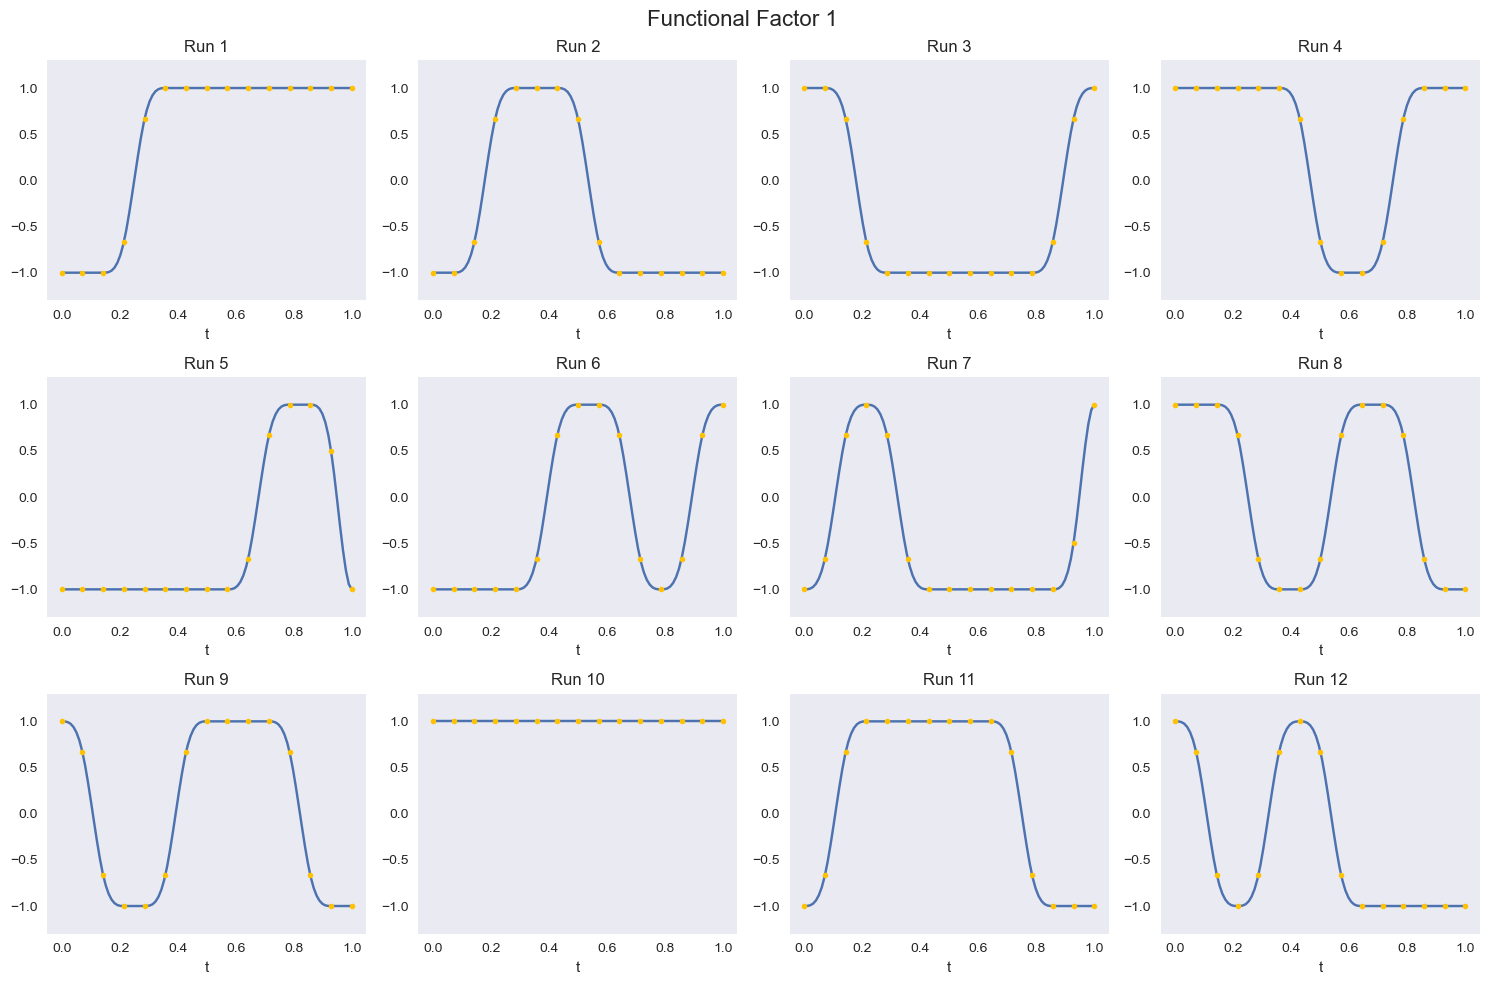

lambda_s: 1.1268883925400771e-05, lambda_t: 4.0869678705846416e-08, objective: 2.439362591096376e+85


 21%|██        | 21/100 [00:47<03:14,  2.46s/it]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


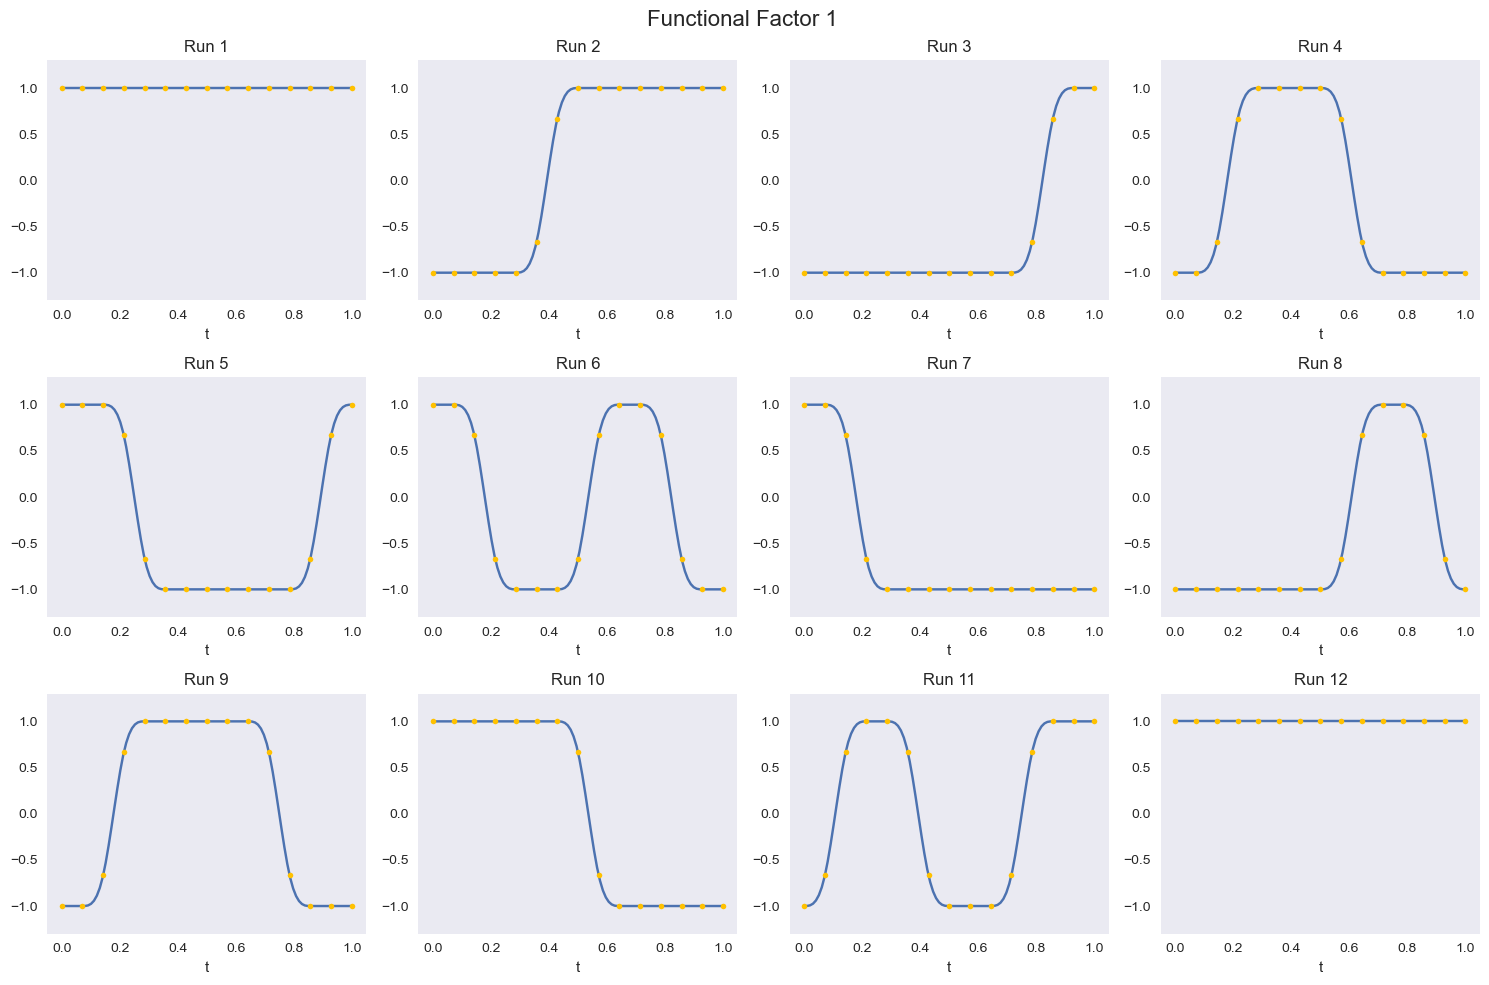

lambda_s: 7.110185076826412e-05, lambda_t: 2.5787023945999573e-07, objective: 1.5901915451092076e+59


  6%|▌         | 6/100 [00:15<03:50,  2.45s/it]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


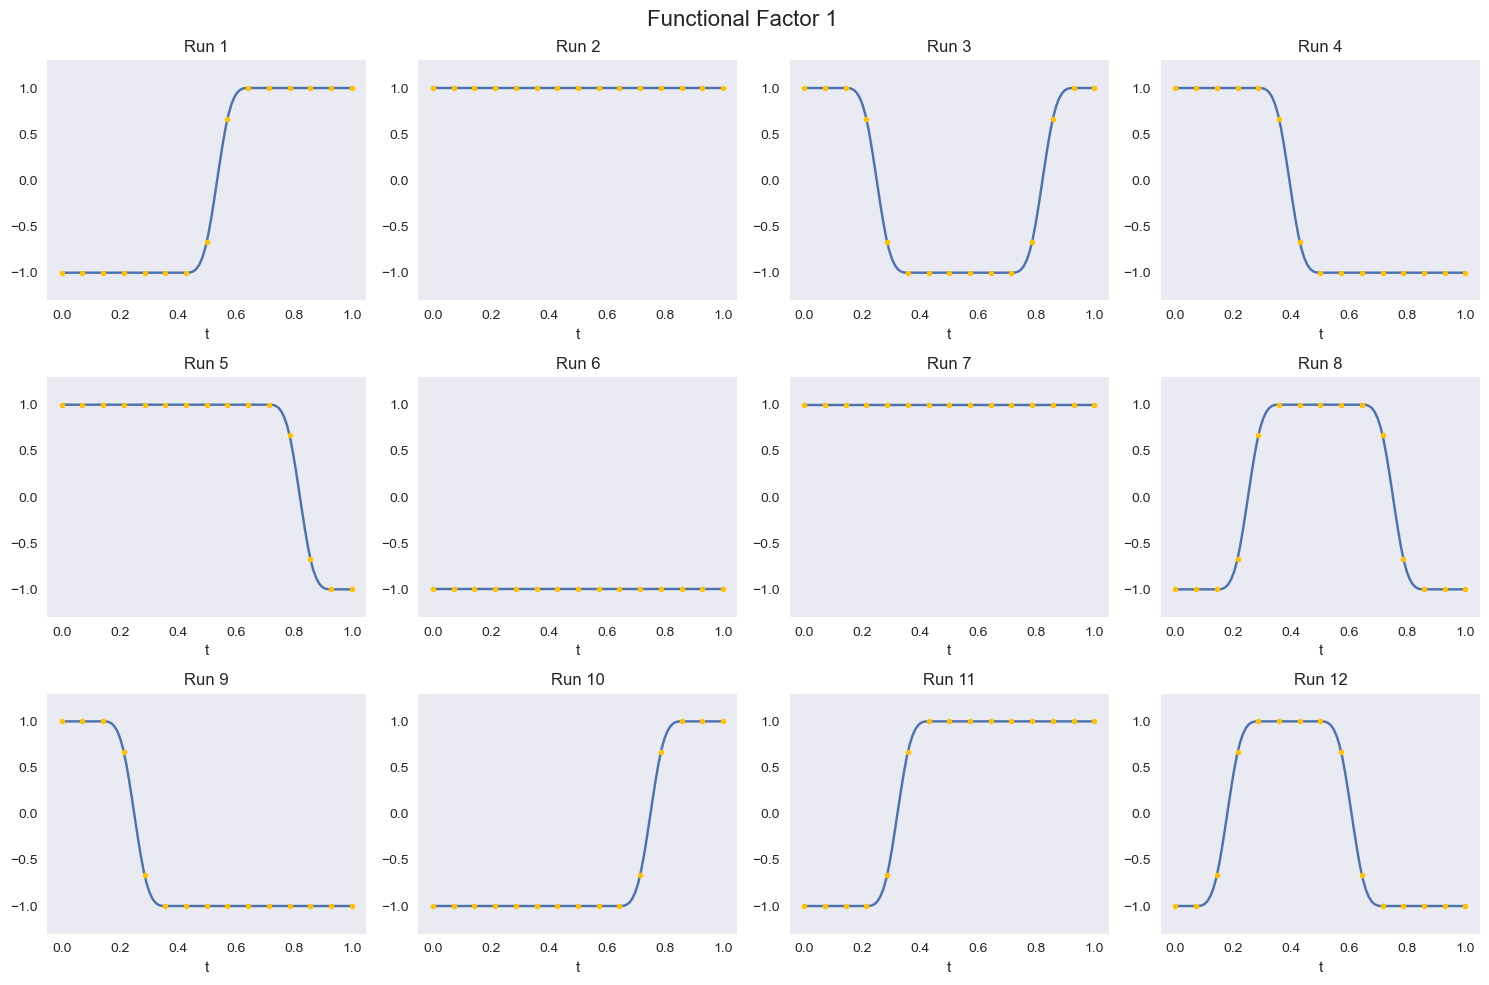

lambda_s: 0.0004486223494837089, lambda_t: 1.6270512151015036e-06, objective: 1.2978838754628691e+23


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


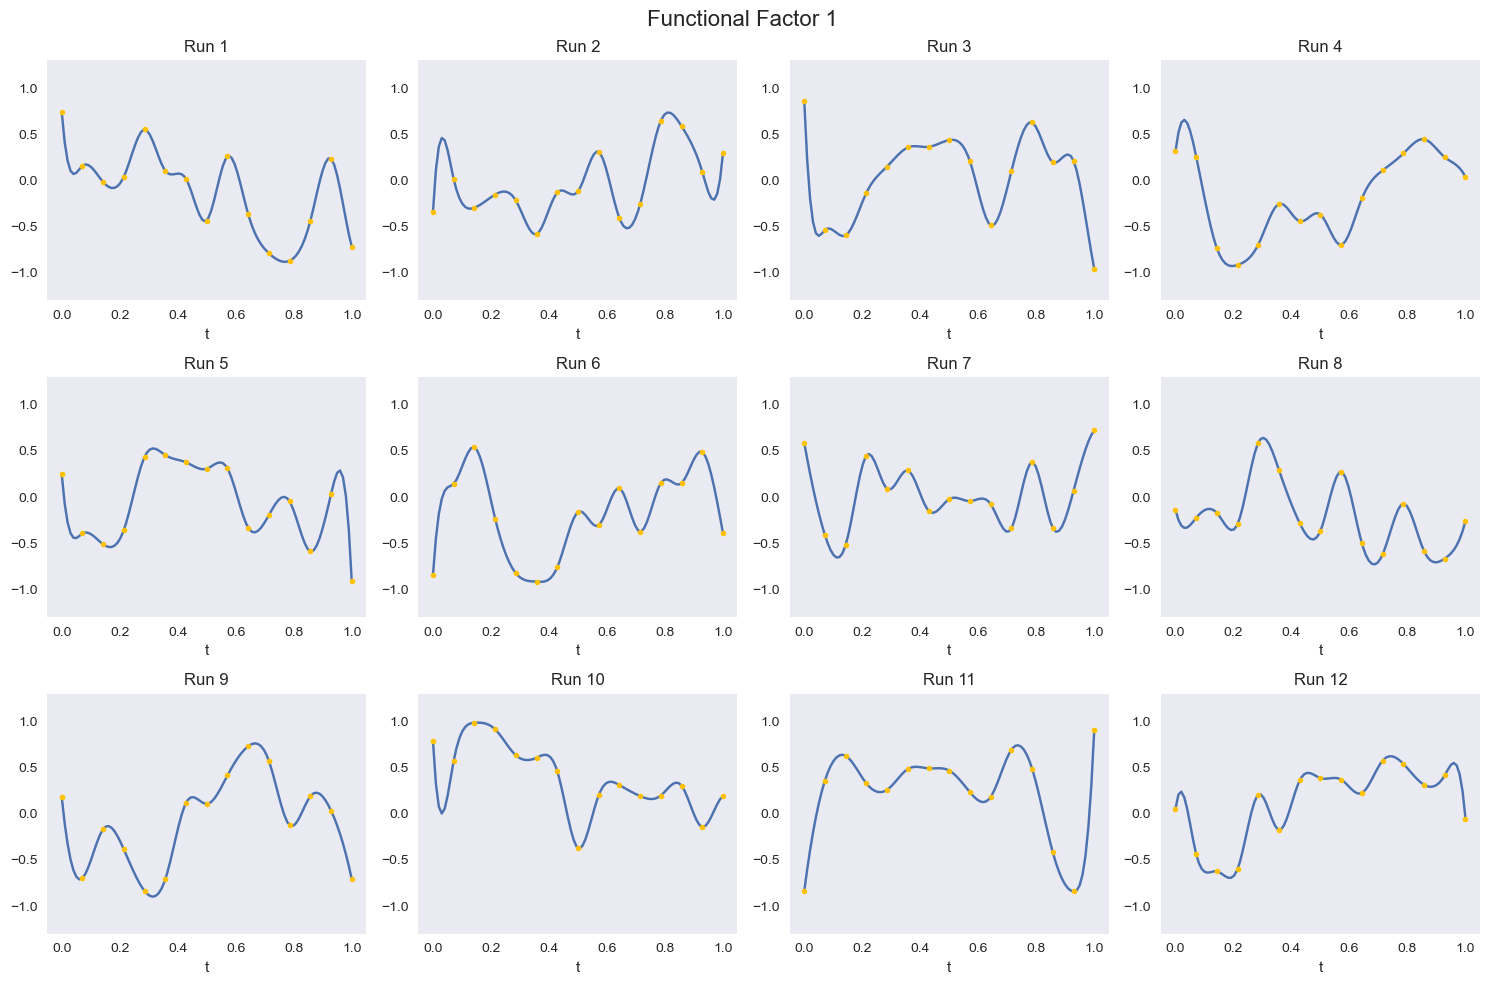

lambda_s: 0.0028306156630470603, lambda_t: 1.0265999140137161e-05, objective: 1.6456959200817225e-07


In [57]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = BSplineBasis(degree=4, total_knots_num=5) # H
bt_base = FourierBasis(num_basis_functions=10) # theta
lambdas = np.logspace(-3, 1, 6)

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=12)
    best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
    plot_design(best_design, [x_base], 12,
                sub_x=3, sub_y=4, colour="#FFC100")
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}")

### Supersaturated

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


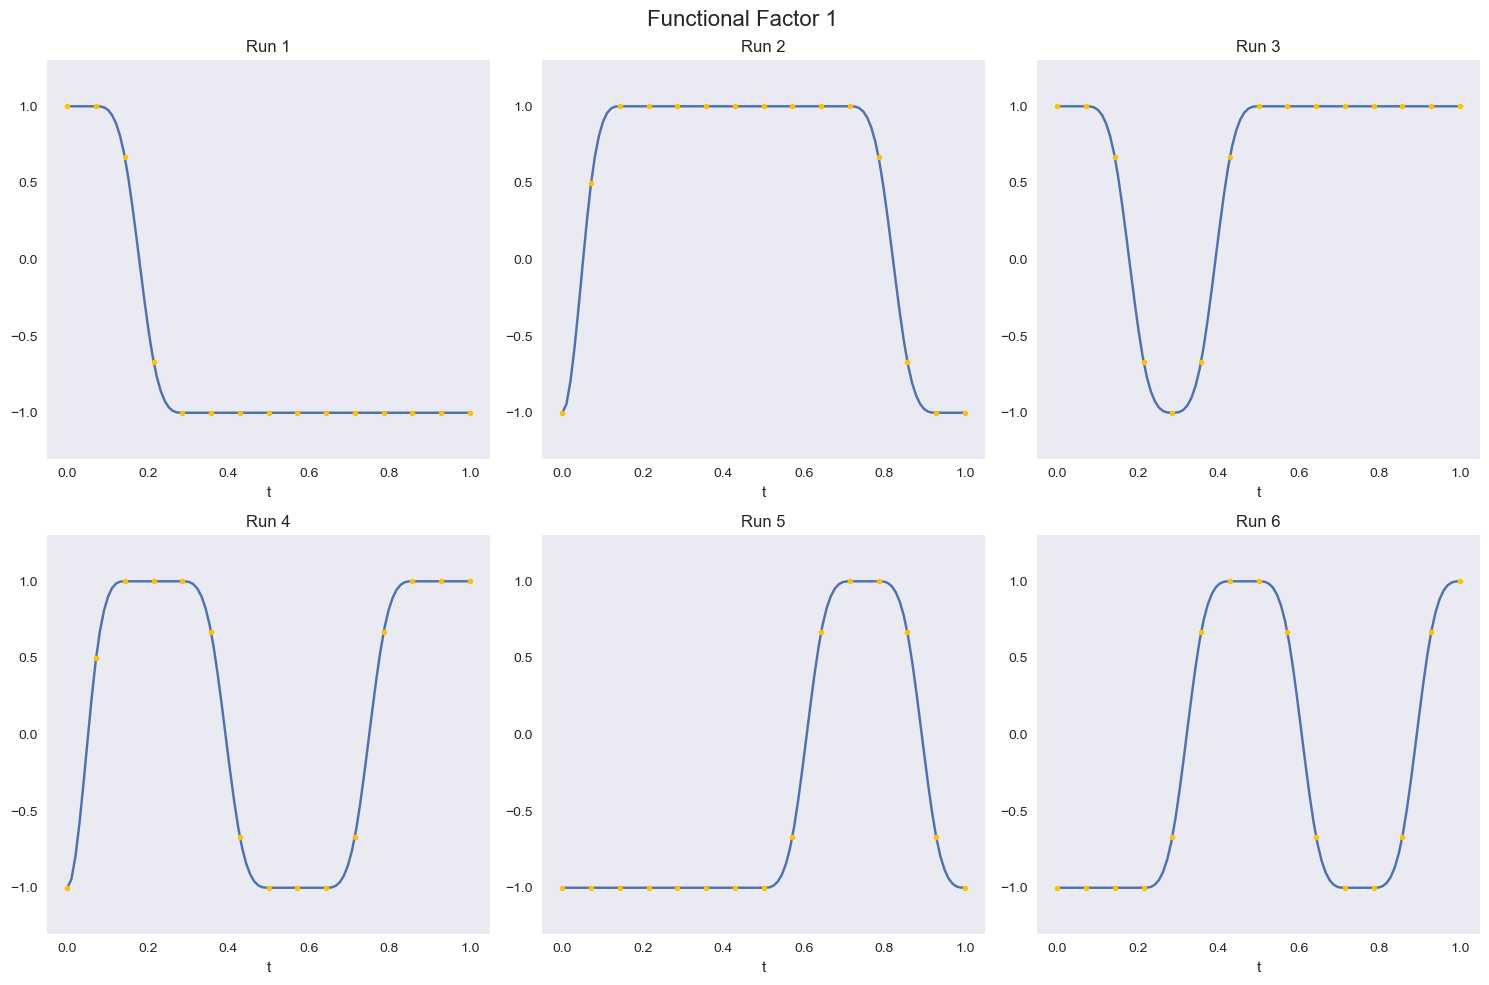

lambda_s: 2.8306156630470603e-07, lambda_t: 1.026599914013716e-09, objective: 4.313271927130827e+154


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


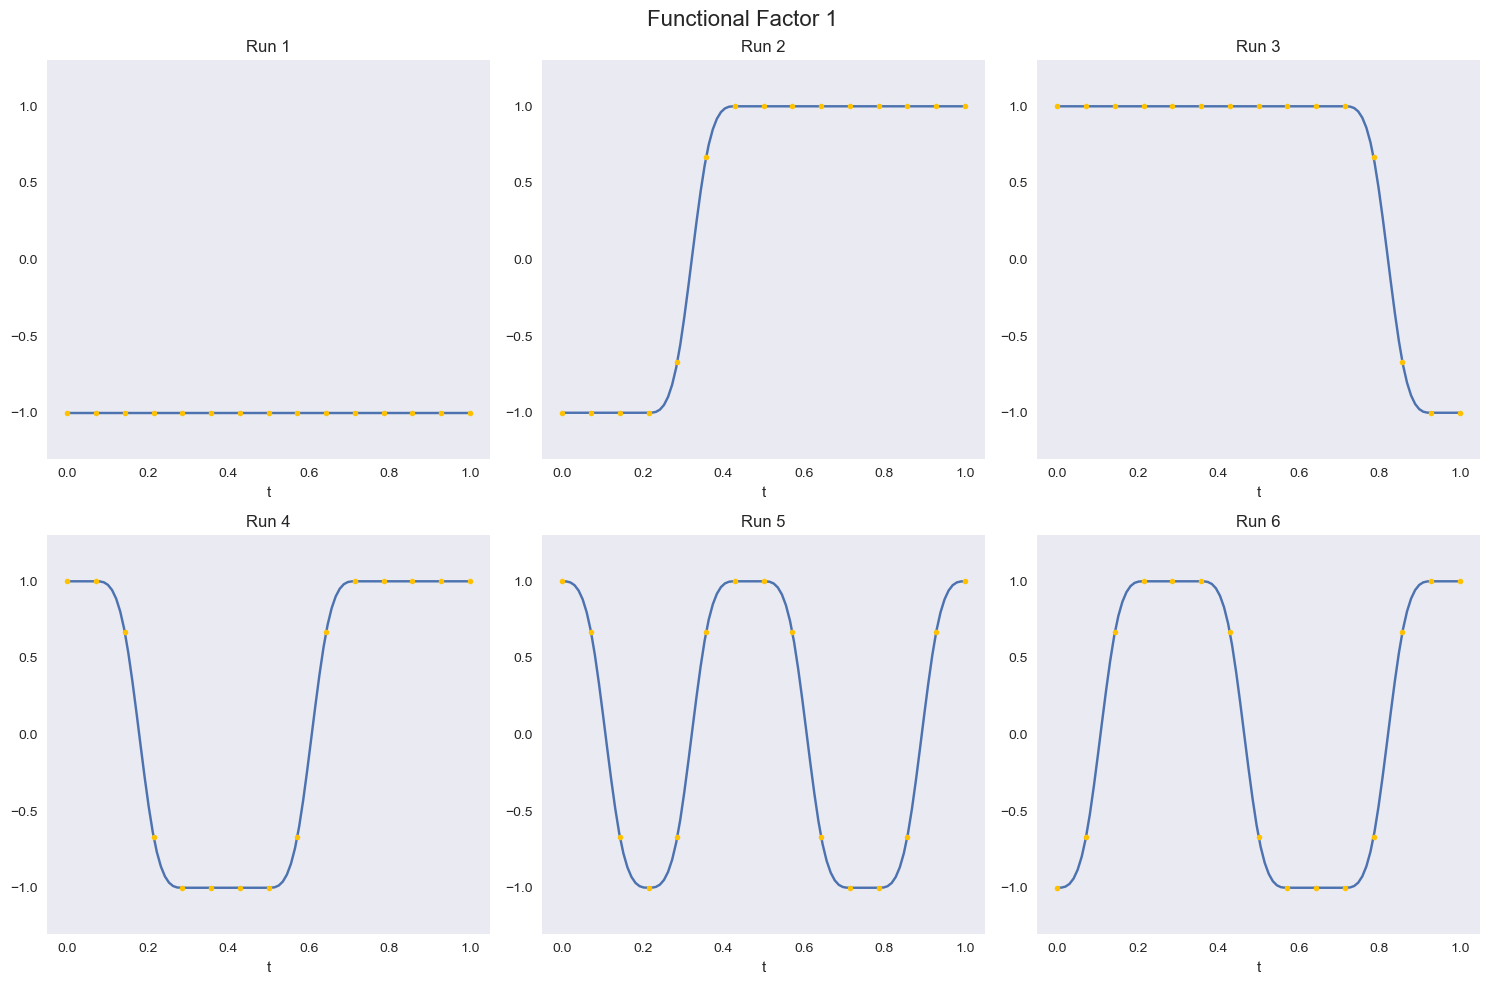

lambda_s: 1.785997742000214e-06, lambda_t: 6.477407555896888e-09, objective: 3.3998975975980527e+130


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


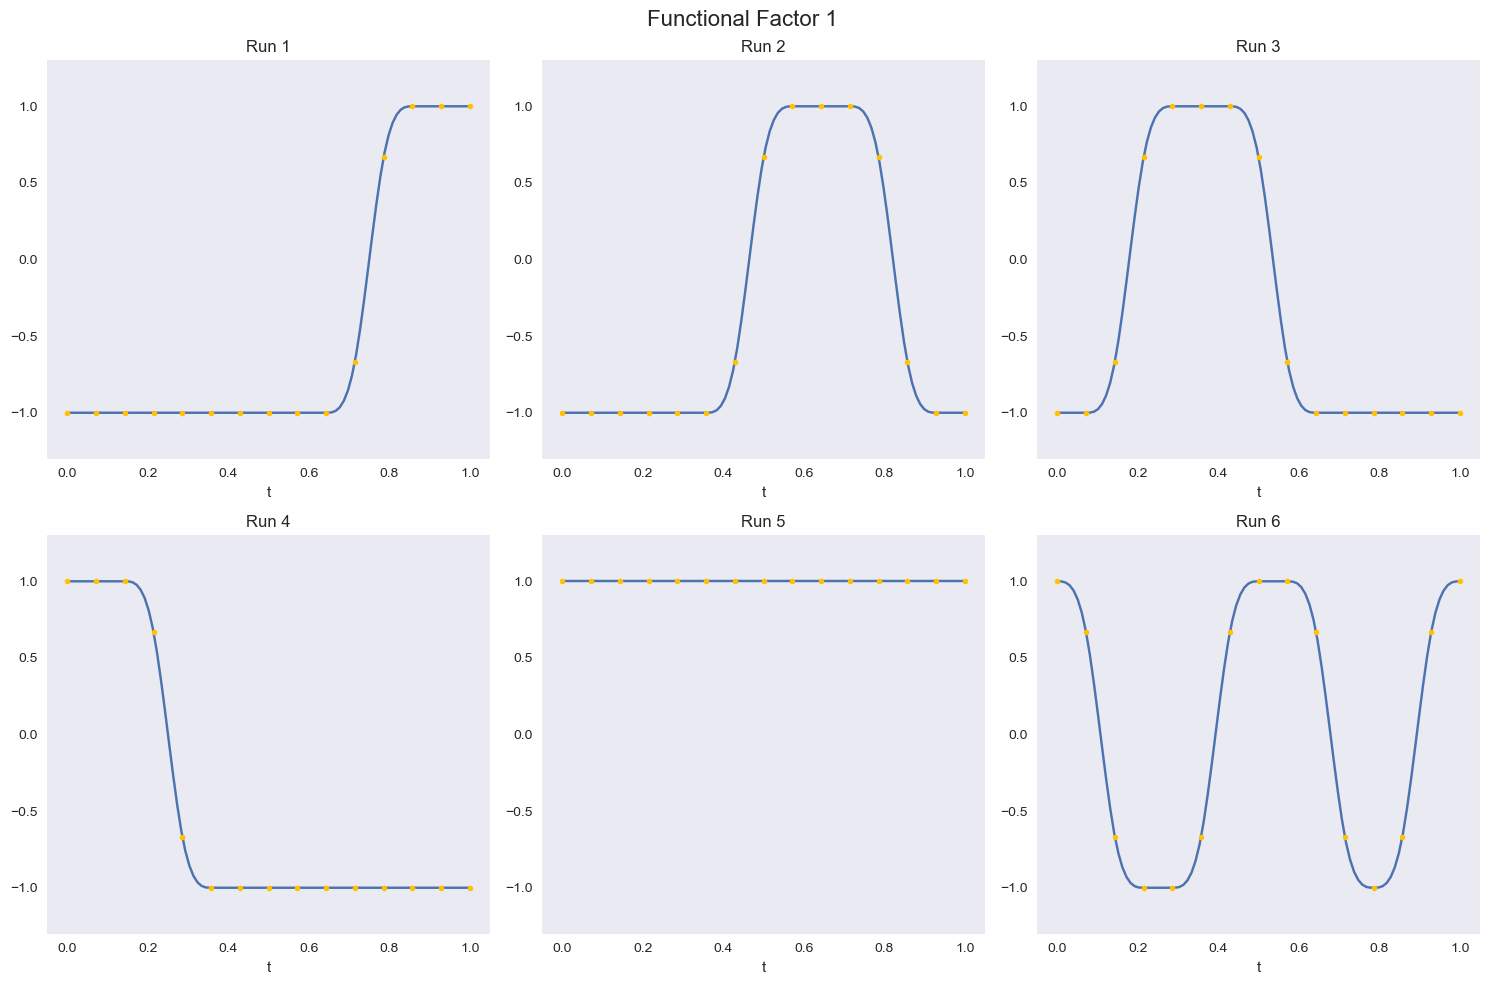

lambda_s: 1.1268883925400771e-05, lambda_t: 4.0869678705846416e-08, objective: 1.2886598921911022e+105


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


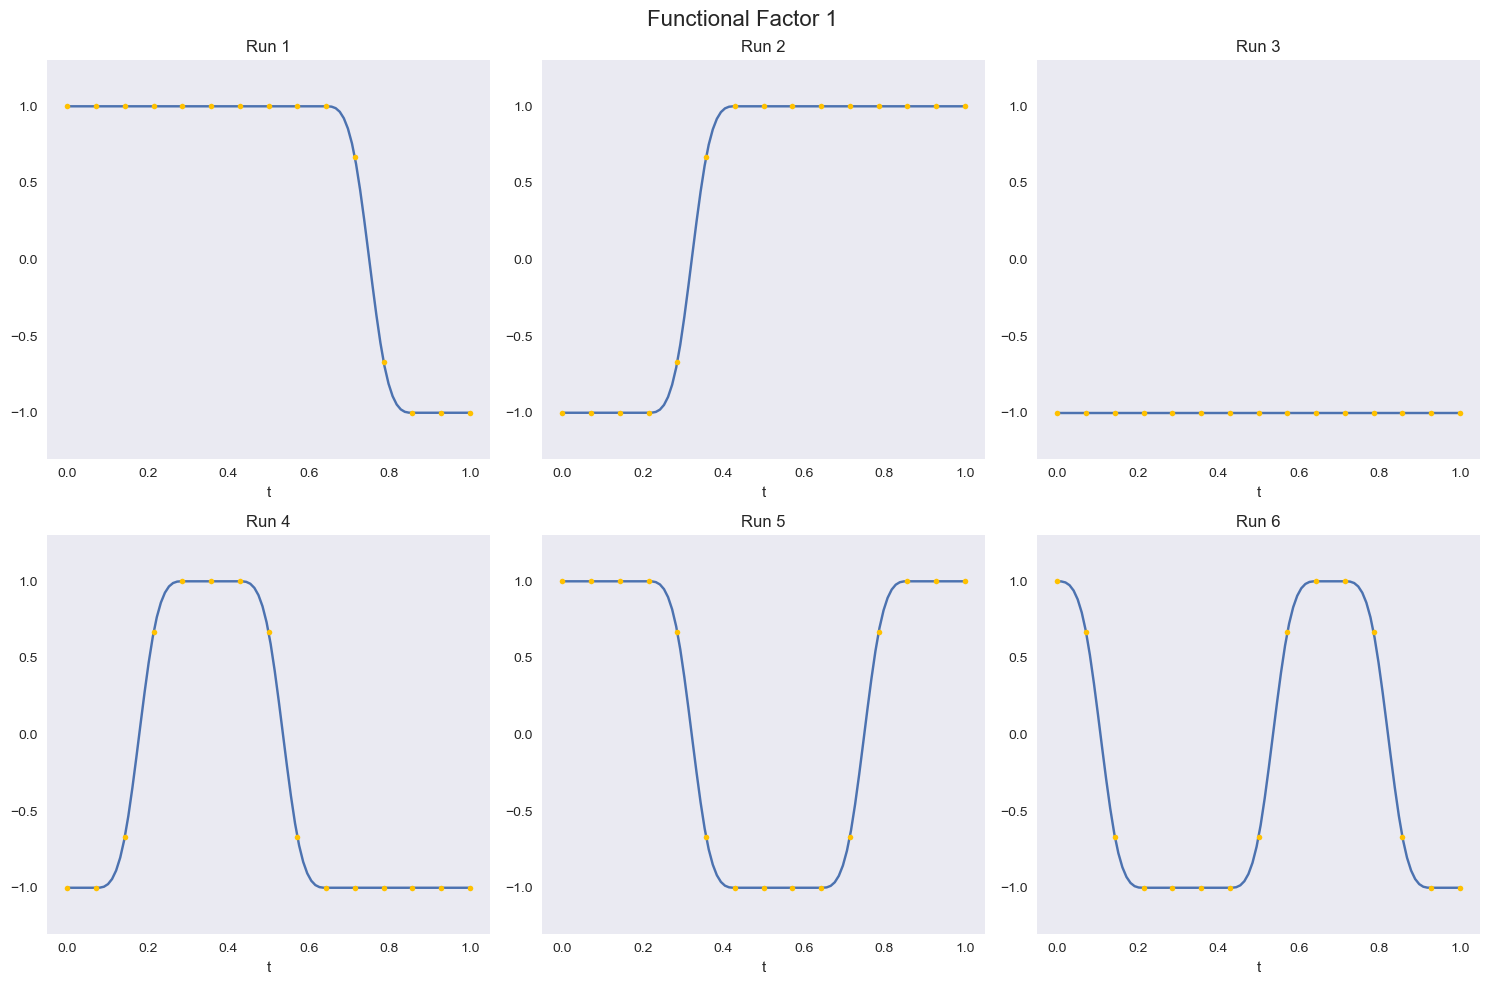

lambda_s: 7.110185076826412e-05, lambda_t: 2.5787023945999573e-07, objective: 1.8244275625725793e+74


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


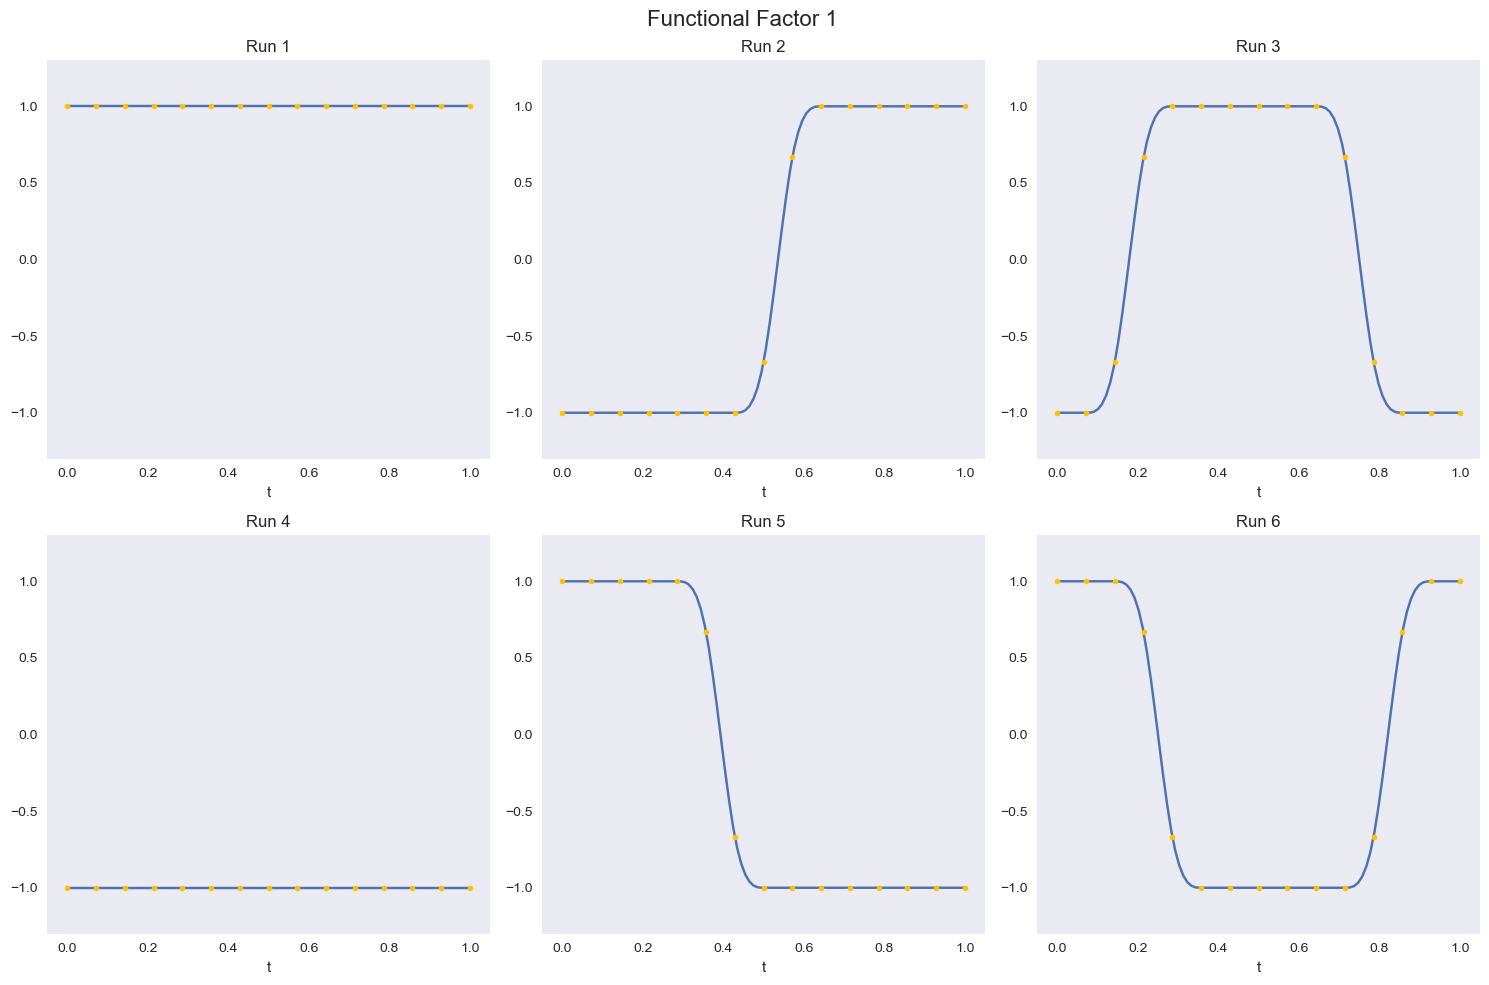

lambda_s: 0.0004486223494837089, lambda_t: 1.6270512151015036e-06, objective: 2.145193094277539e+34


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


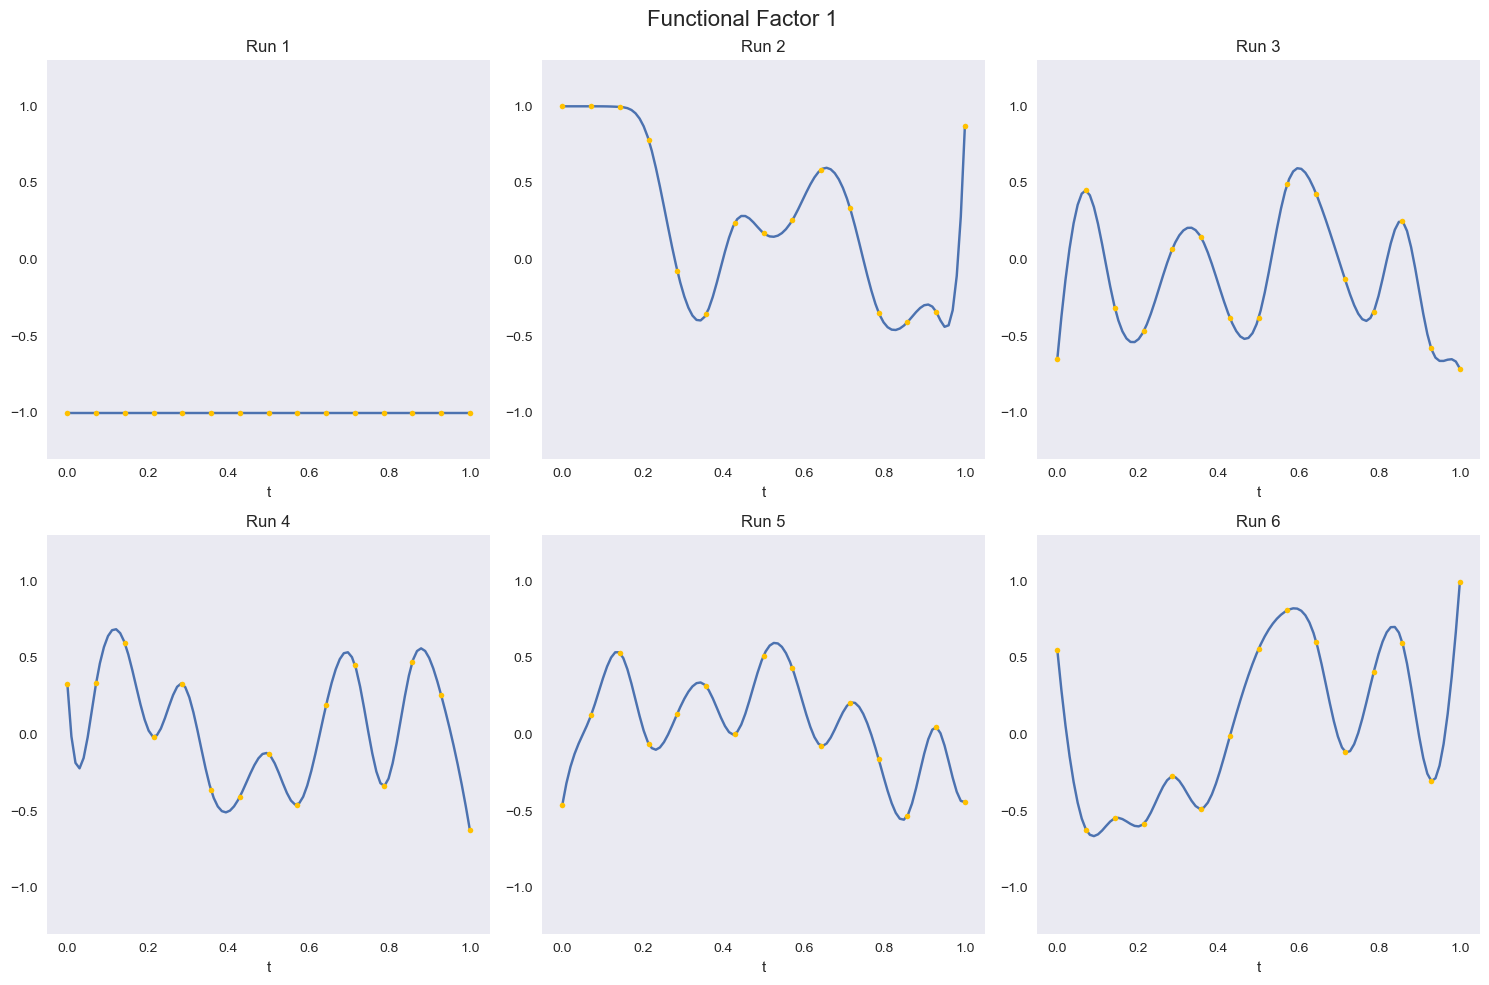

lambda_s: 0.0028306156630470603, lambda_t: 1.0265999140137161e-05, objective: 5.328627264867502e-06


In [58]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = BSplineBasis(degree=4, total_knots_num=5) # H
bt_base = FourierBasis(num_basis_functions=10) # theta
lambdas = np.logspace(-3, 1, 6)

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=6)
    best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
    plot_design(best_design, [x_base], 6,
                sub_x=2, sub_y=3, colour="#FFC100")
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}")

---

In [35]:
x_base = BSplineBasis(degree=3, total_knots_num=5) # C
bs_base = BSplineBasis(degree=3, total_knots_num=8) # H
bt_base = FourierBasis(num_basis_functions=3) # theta

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

lambda_s = 1e-2
lambda_t = 1e-2
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)


In [24]:
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=None, lambda_t=None, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design, best_objective = optimizer.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:01<00:00, 59.39it/s]


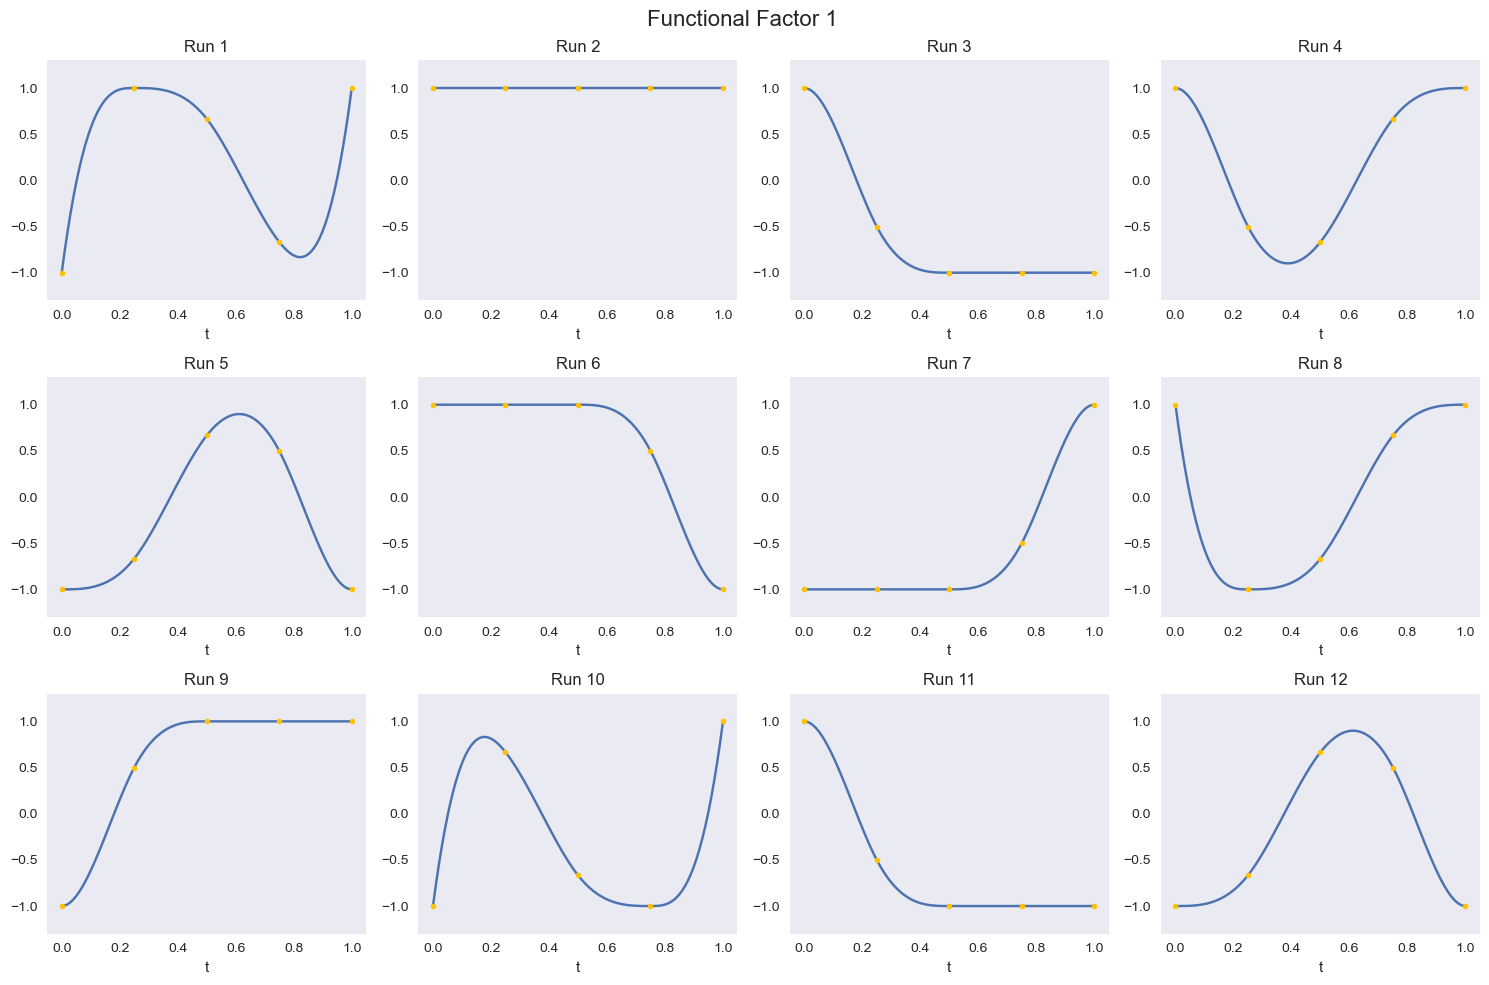

68491.99151165094


In [25]:
plot_design(best_design, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
print(best_objective)

In [22]:
lambda_s = 0.1
lambda_t = 0.1
lambda_s = lambda_s/np.max(np.abs(R))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


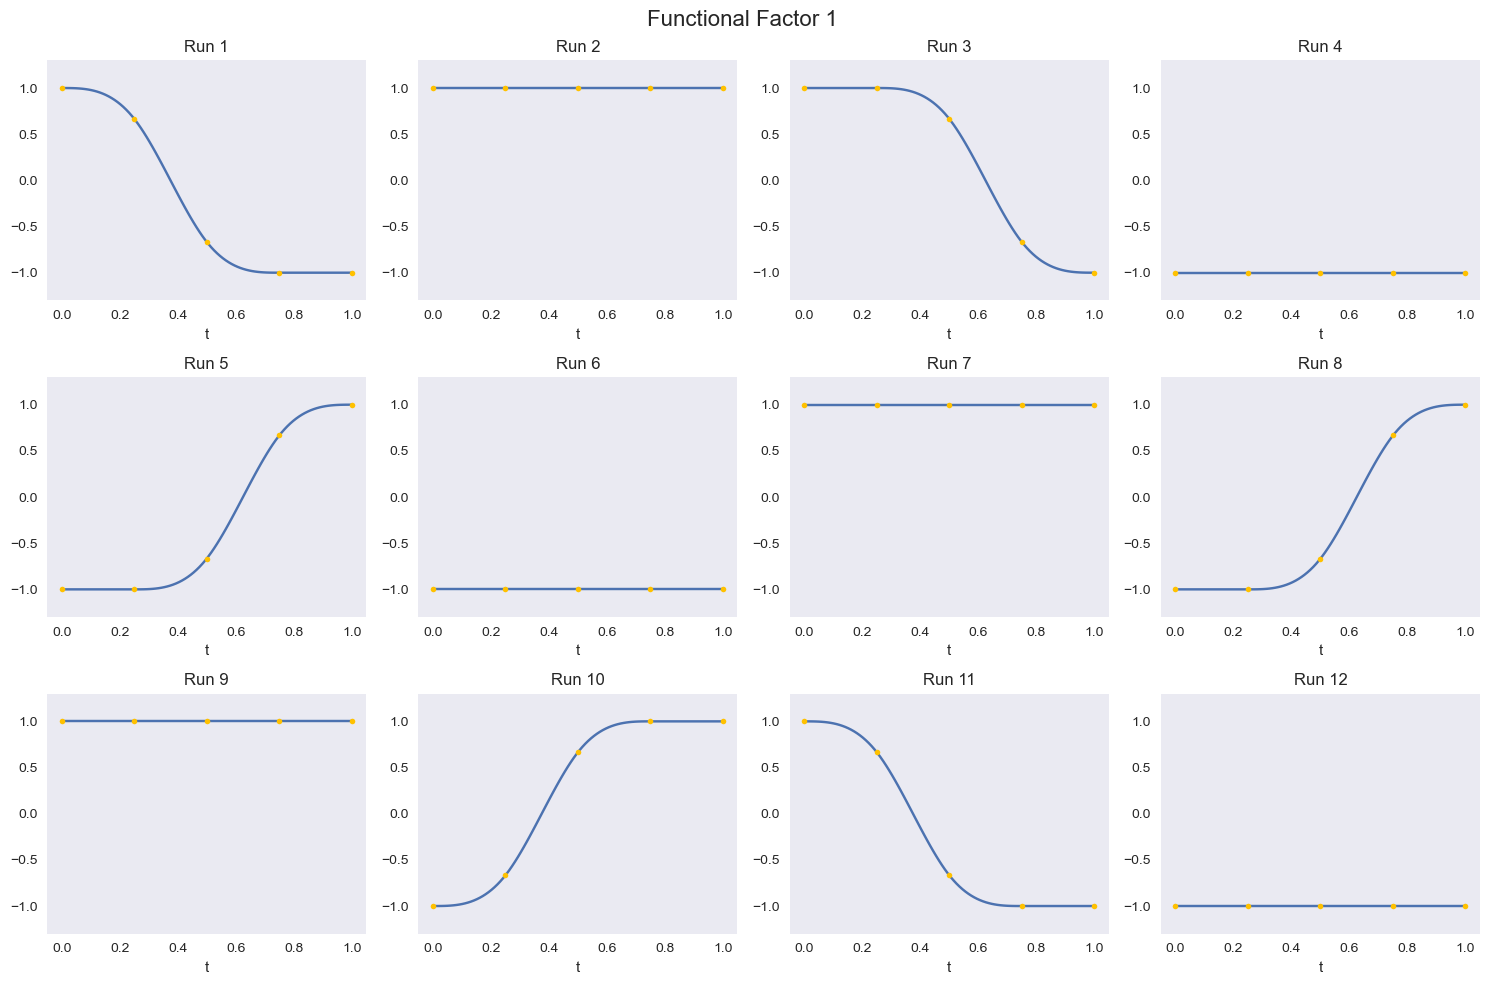

127320.30593241414


In [23]:
plot_design(best_design, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
print(best_objective)

In [20]:
lambda_s = 1e-2
lambda_t = 1e-2
lambda_s = lambda_s/np.max(np.abs(R))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)

100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


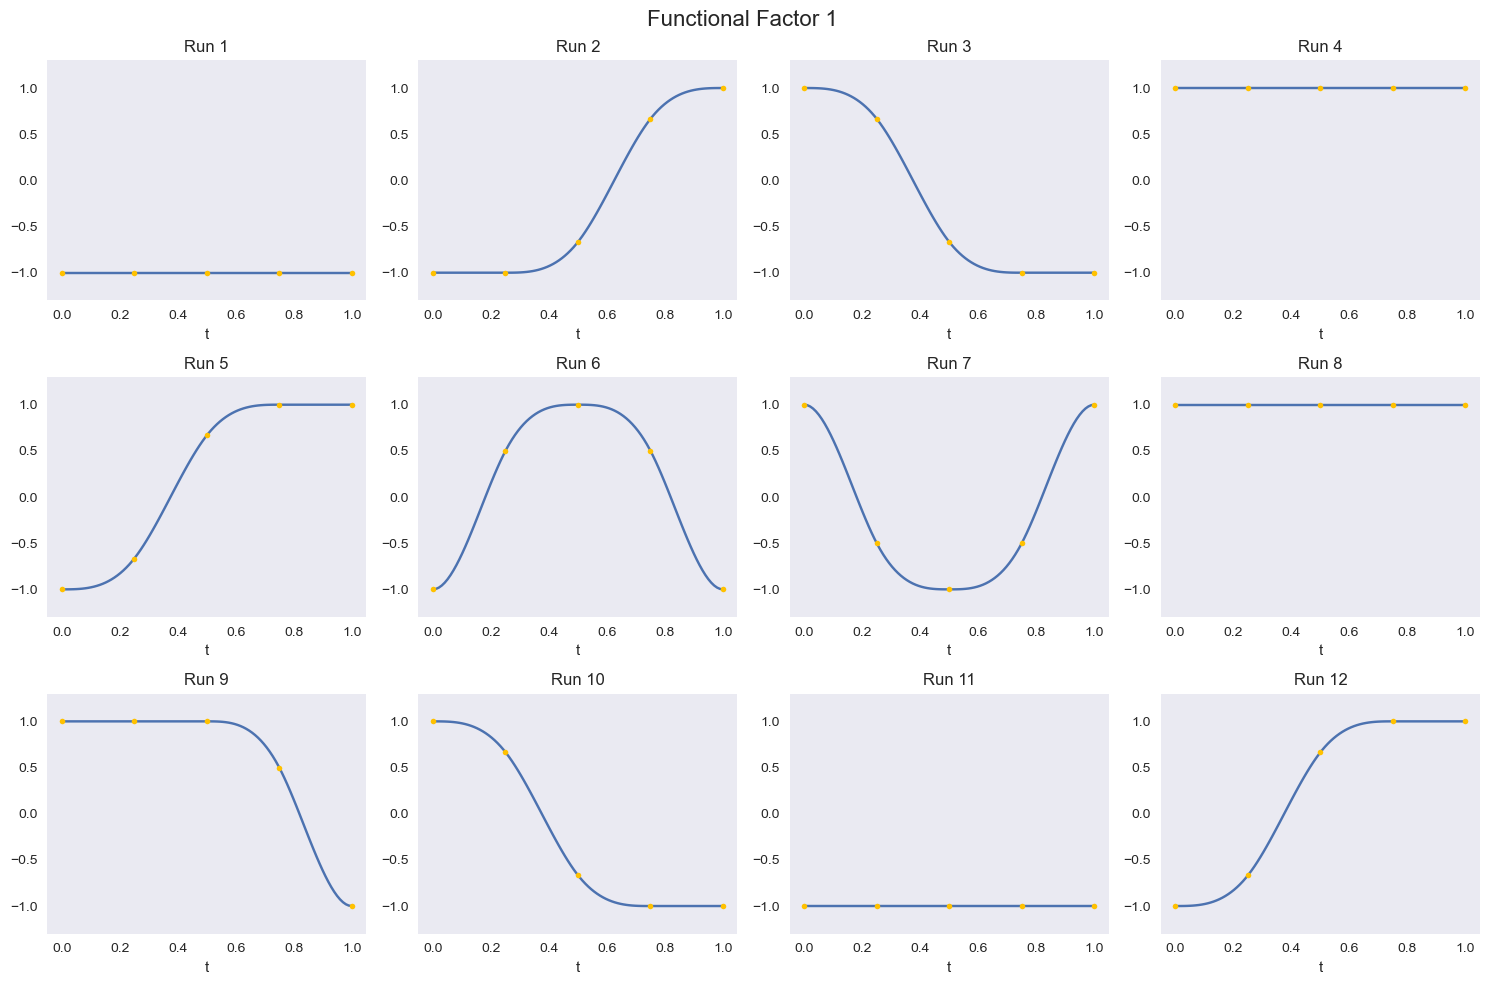

18573896399.138092


In [21]:
plot_design(best_design, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
print(best_objective)

In [29]:
lambda_s = 1e-3
lambda_t = 1e-3
lambda_s = lambda_s/np.max(np.abs(R))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design, best_objective = optimizer.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:21<00:00,  4.61it/s]


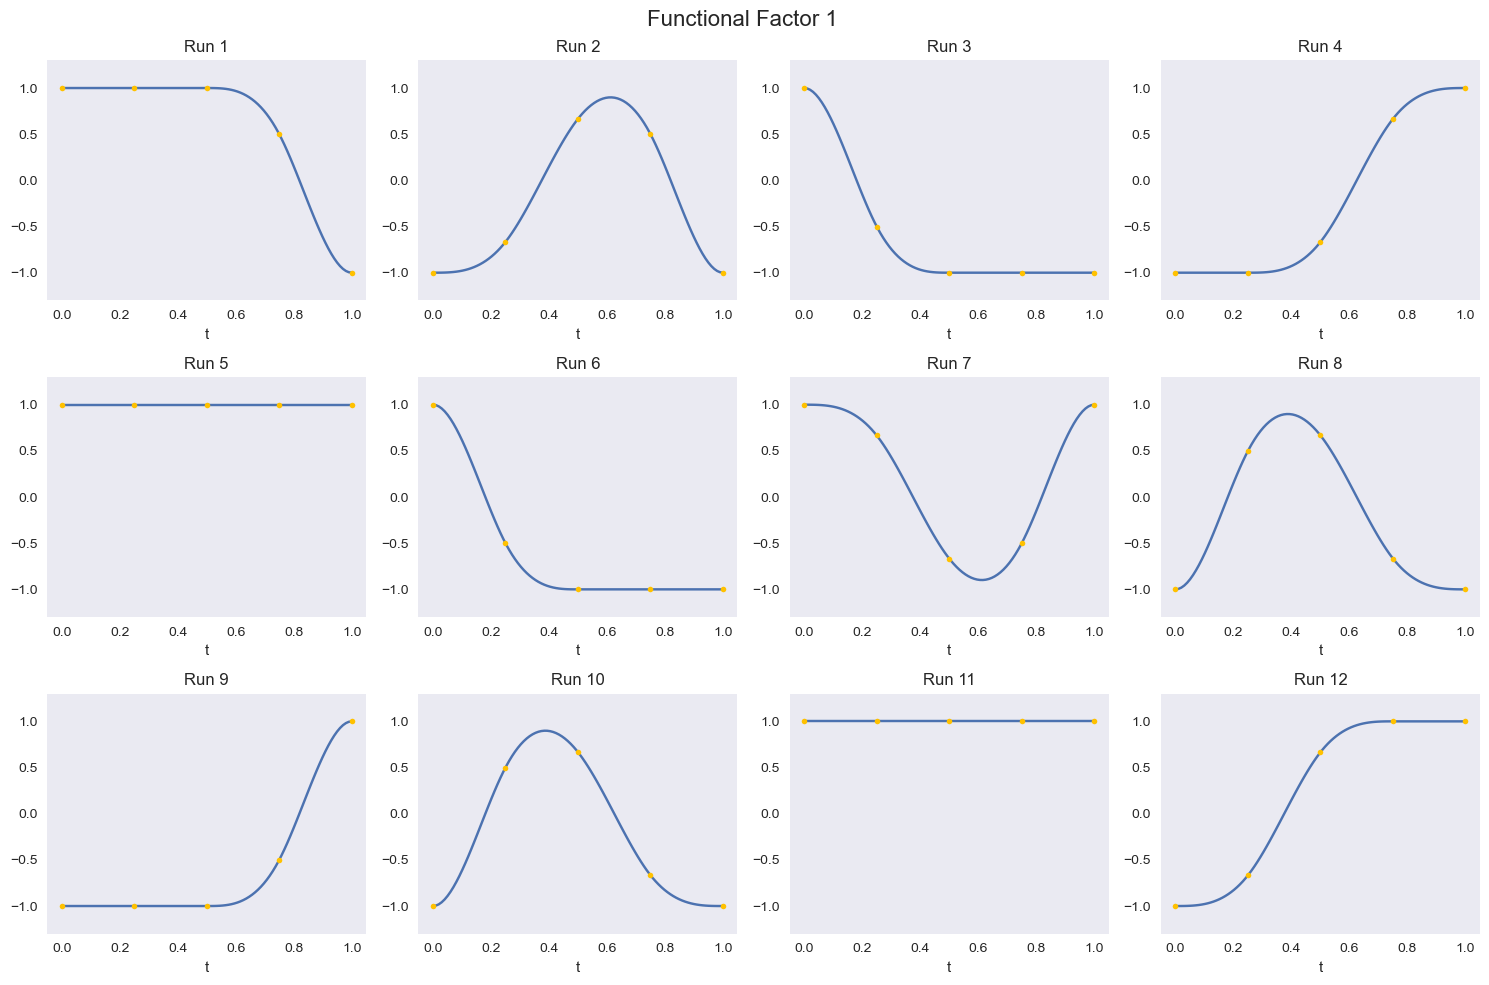

23373405476038.637


In [30]:
plot_design(best_design, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
print(best_objective)

In [36]:
lambda_s = 1e-3
lambda_t = 1e-3
lambda_s = lambda_s/np.max(np.abs(R))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=6)
best_design, best_objective = optimizer.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


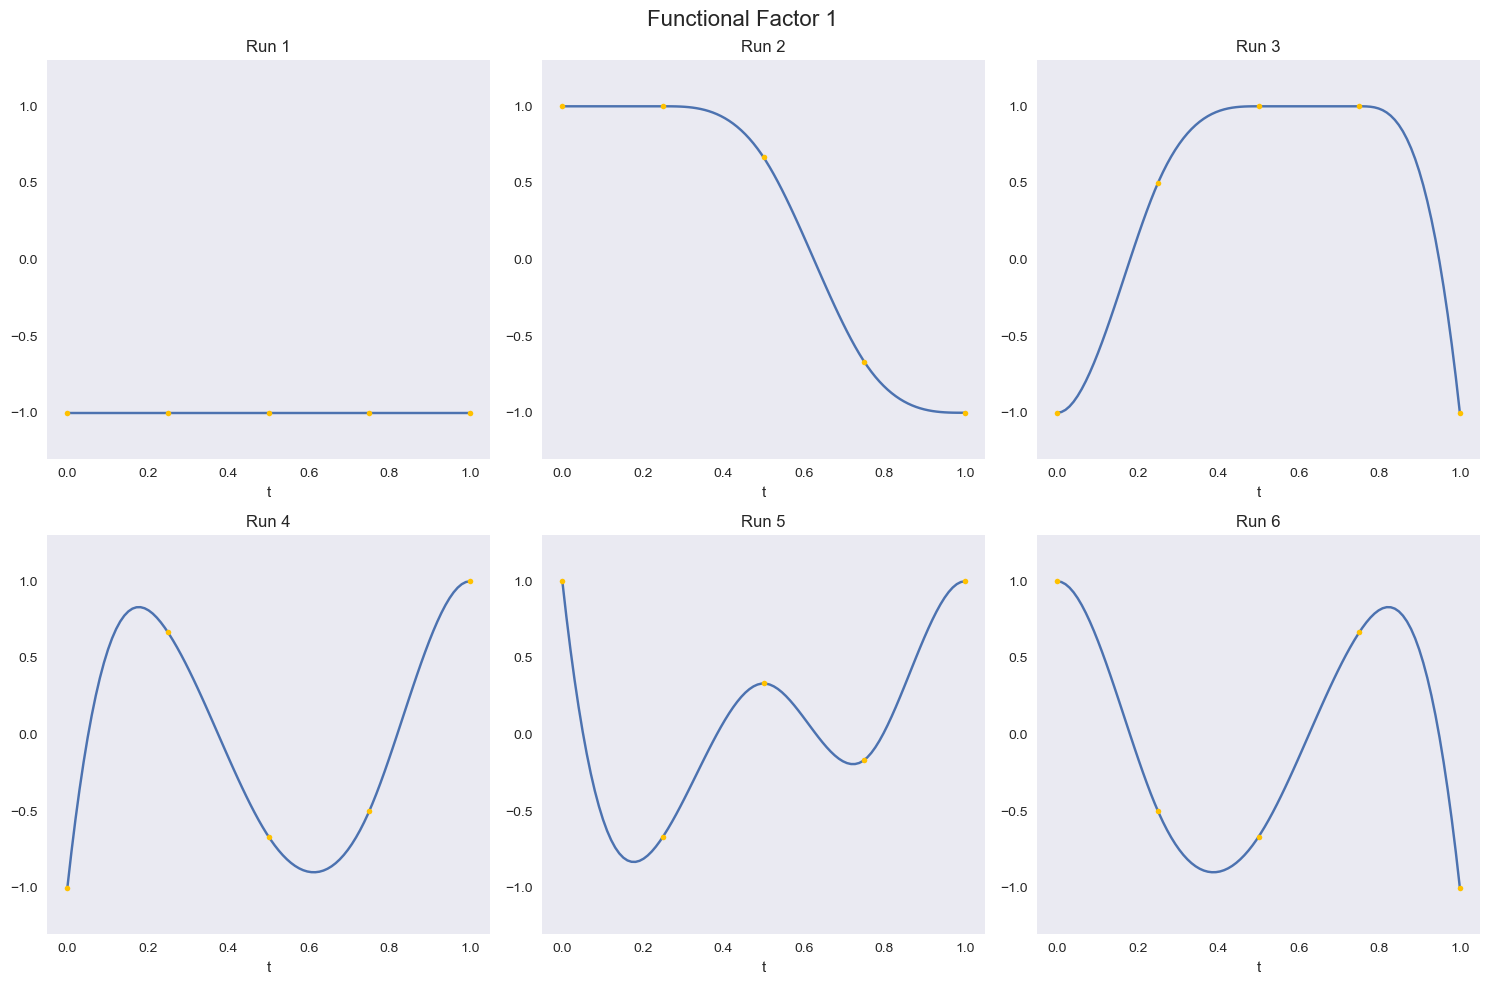

1.767031347947753e+69


In [37]:
plot_design(best_design, [x_base], 6,
            sub_x=2, sub_y=3, colour="#FFC100")
print(best_objective)

In [31]:
lambda_s = 1e-8
lambda_t = 1e-8
lambda_s = lambda_s/np.max(np.abs(R))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design, best_objective = optimizer.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


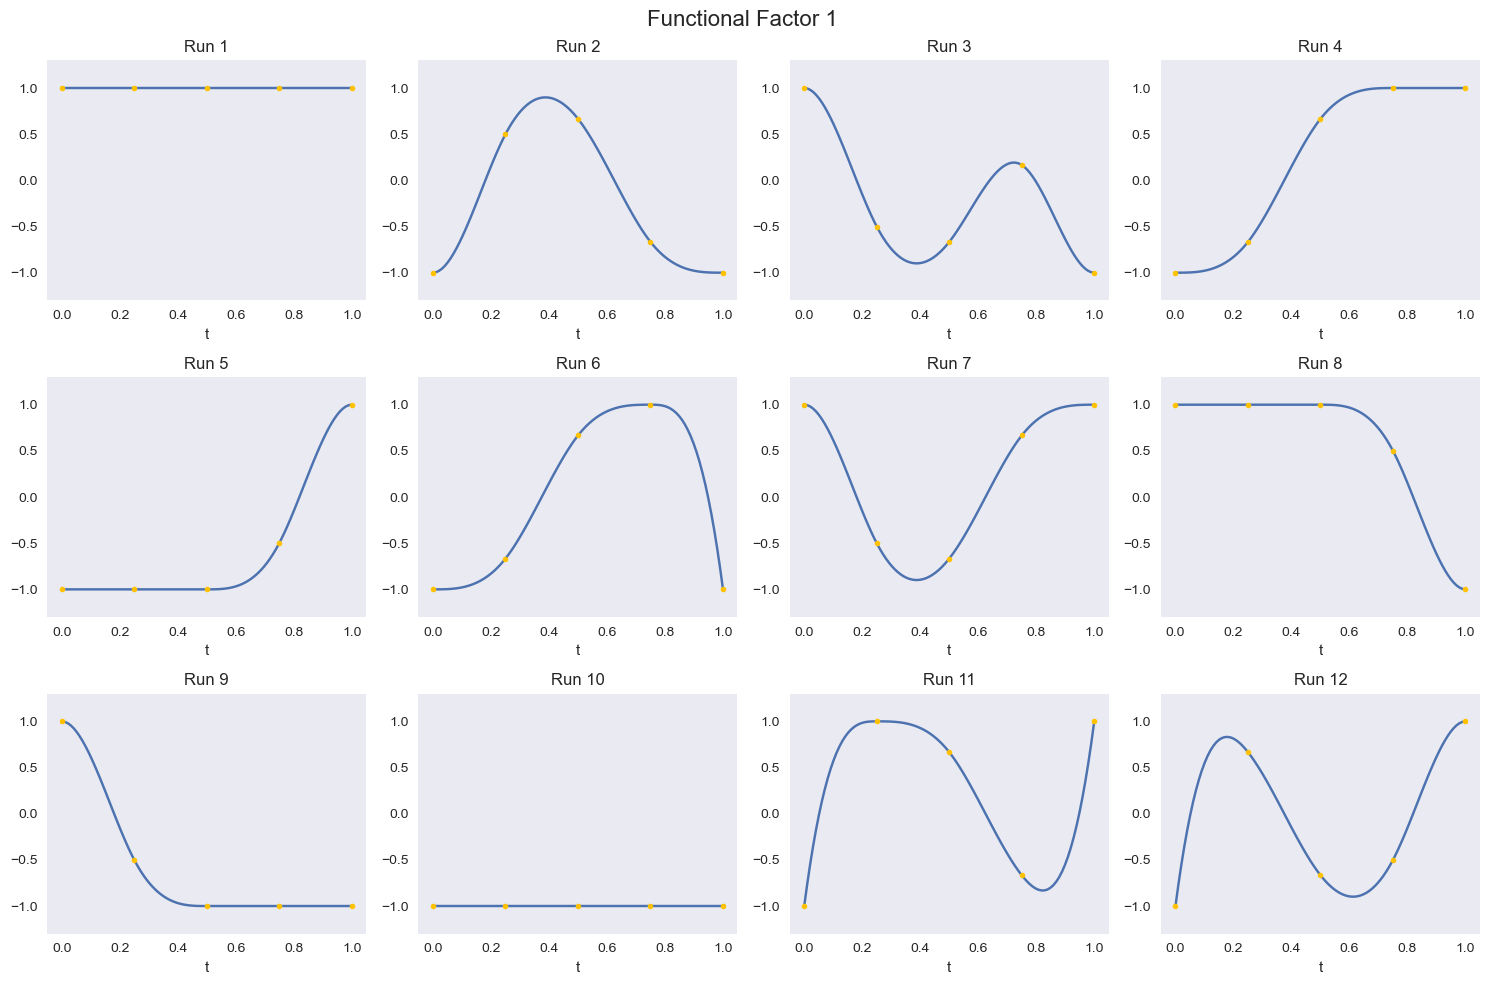

315646614343131.3


In [32]:
plot_design(best_design, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
print(best_objective)

In [14]:
lambda_s = 1e-3
lambda_t = 1e-3
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design, best_objective = optimizer.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


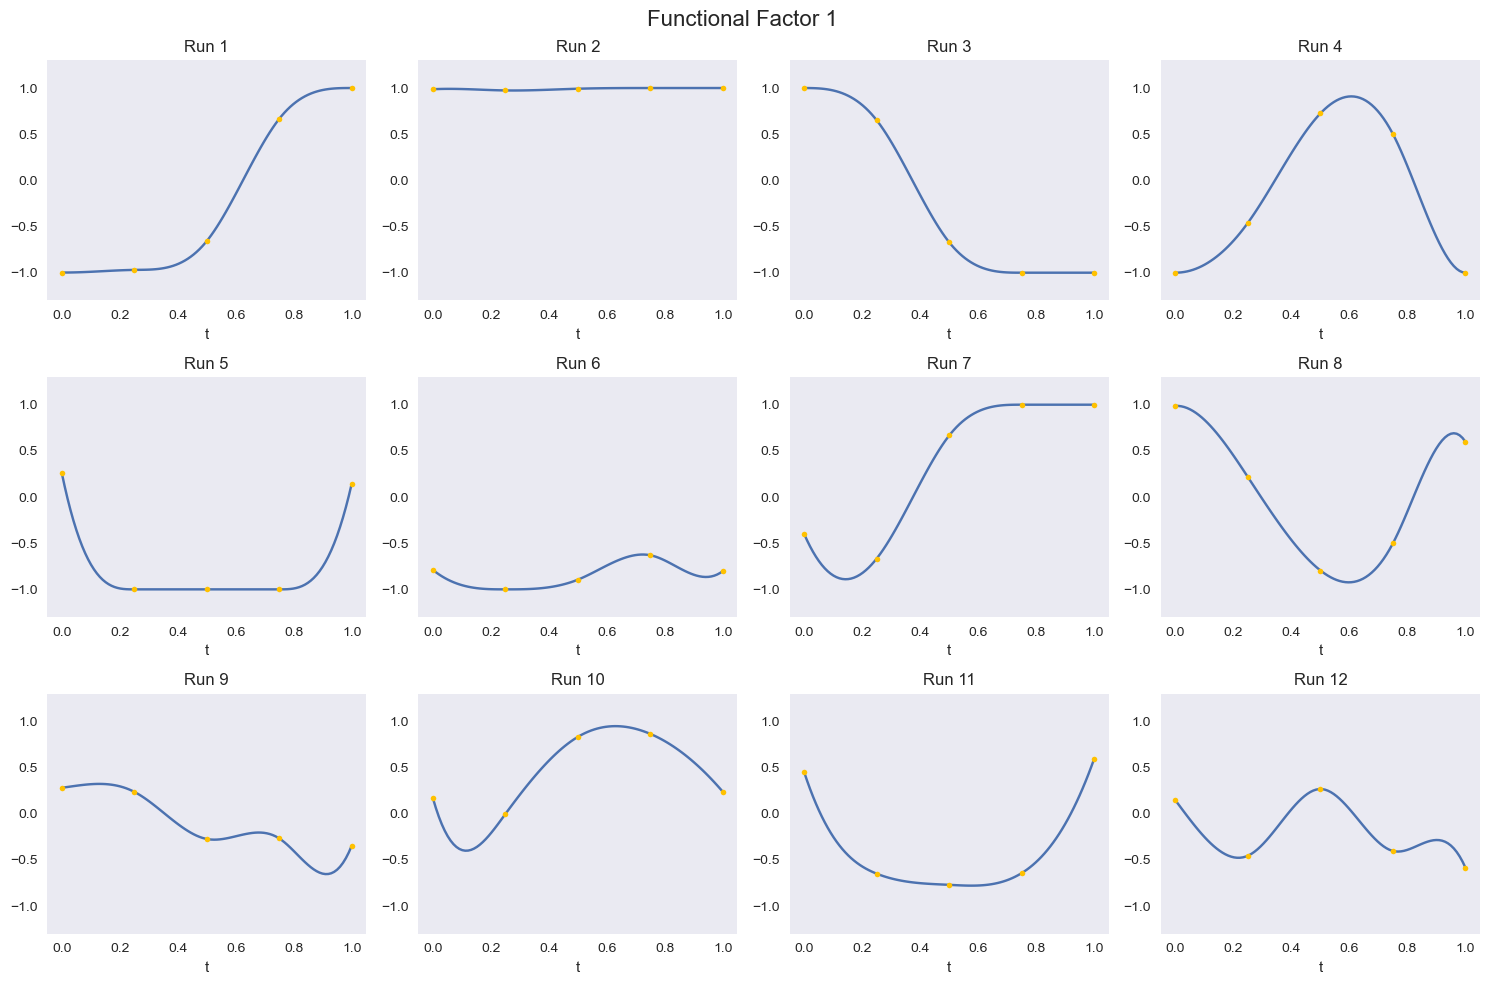

1.2150352493353915e-10


In [15]:
plot_design(best_design, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
print(best_objective)

---

In [10]:
x_base = BSplineBasis(degree=3, total_knots_num=4) # C
bs_base = PolynomialBasis(degree=8) # H
bt_base = FourierBasis(num_basis_functions=10) # theta

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

lambda_s = 1e-5
lambda_t = 1e-5
# lambda_s = lambda_s/np.max(np.abs(R))
# lambda_s = np.exp(np.log(lambda_s) - np.log(np.max(np.abs(R))))
## a/b = e^(log(a) - log(b))
# lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))
# lambda_t = np.exp(np.log(lambda_t) - np.log(np.max(np.abs(np.kron(S, J_HH)))))

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_41878/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_41878/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)


In [11]:
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=8)
best_design, best_objective = optimizer.optimize(epochs=5, refinement_epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'shape'

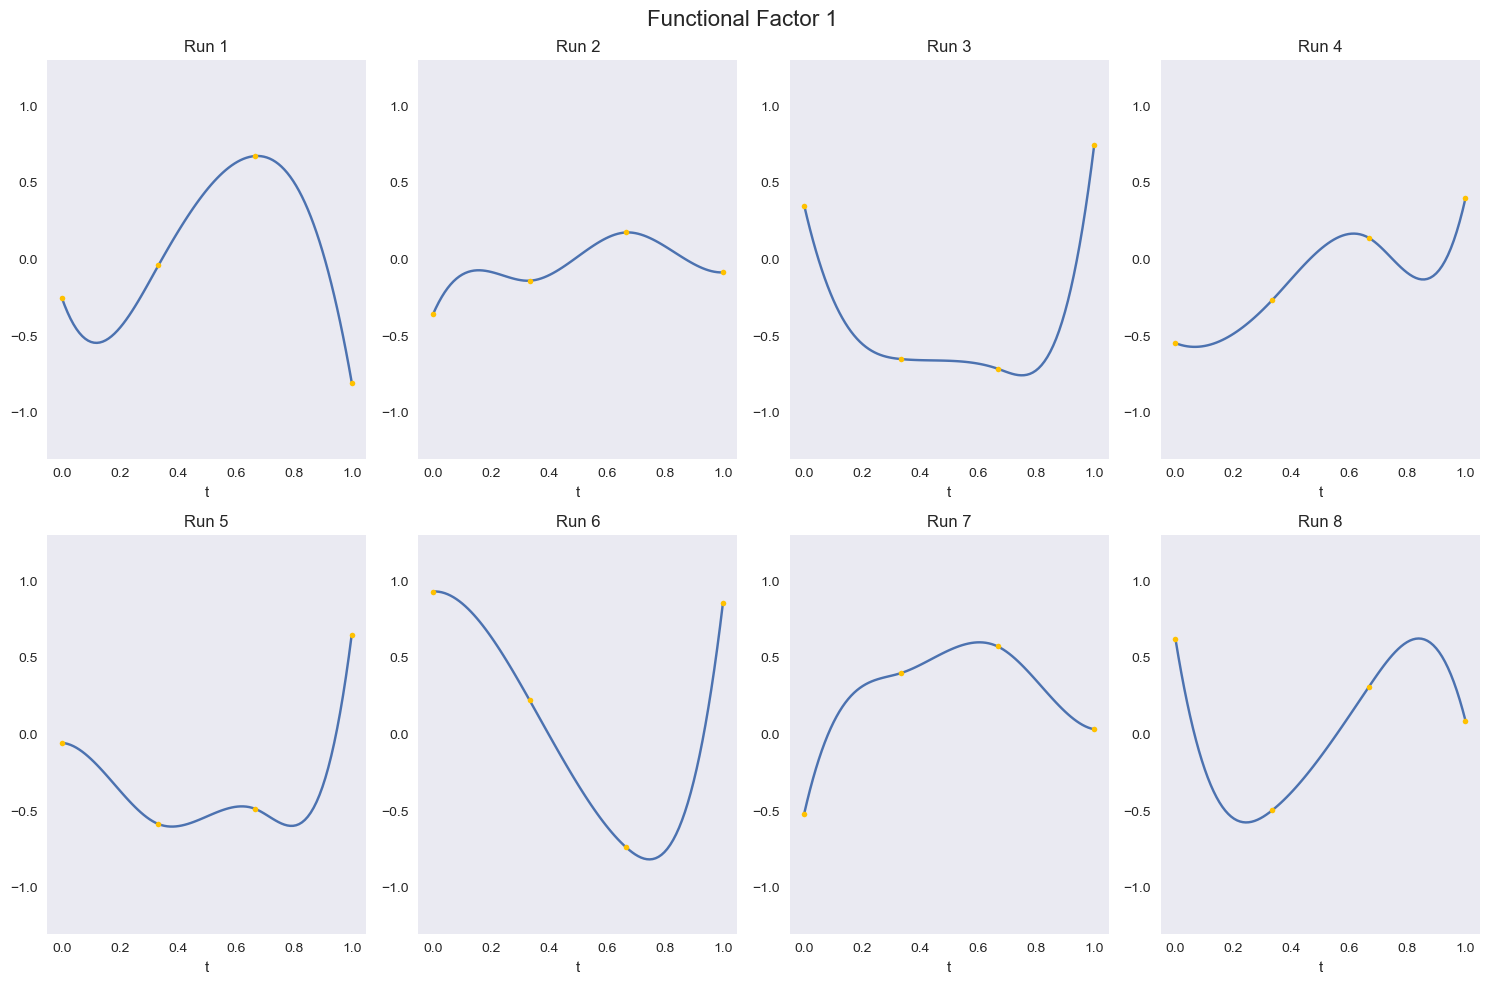

0.0


In [12]:
plot_design(best_design, [x_base], 8,
            sub_x=2, sub_y=4, colour="#FFC100")
print(best_objective)

---
### Total Variation

In [73]:
import numpy as np
from scipy.integrate import quad
from scipy.misc import derivative

def compute_average_variation(design_matrix, basis, dx=1e-4):
    if design_matrix.size == 0:
        return 0.0

    N = design_matrix.shape[0]  # number of designs
    K = design_matrix.shape[1]  # number of basis functions (should match basis.num_basis())

    total_tv = 0.0

    for n in range(N):
        coeffs = design_matrix[n, :]

        # Define the function f_n(t) = sum_i coeffs[i] * basis_i(t)
        def f_n(t):
            val = 0.0
            for k in range(K):
                val += coeffs[k] * basis.evaluate_basis_function(k, t)
            return val

        def integrand(t):
            return abs(
                derivative(f_n, t, dx=dx, n=1)  # first derivative
            )

        tv, _ = quad(integrand, 0, 1)
        total_tv += tv

    avg_tv = total_tv / N
    return avg_tv


In [75]:
avg_tv = compute_average_variation(best_design, basis=x_base)
avg_tv

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


5.654946441794519

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


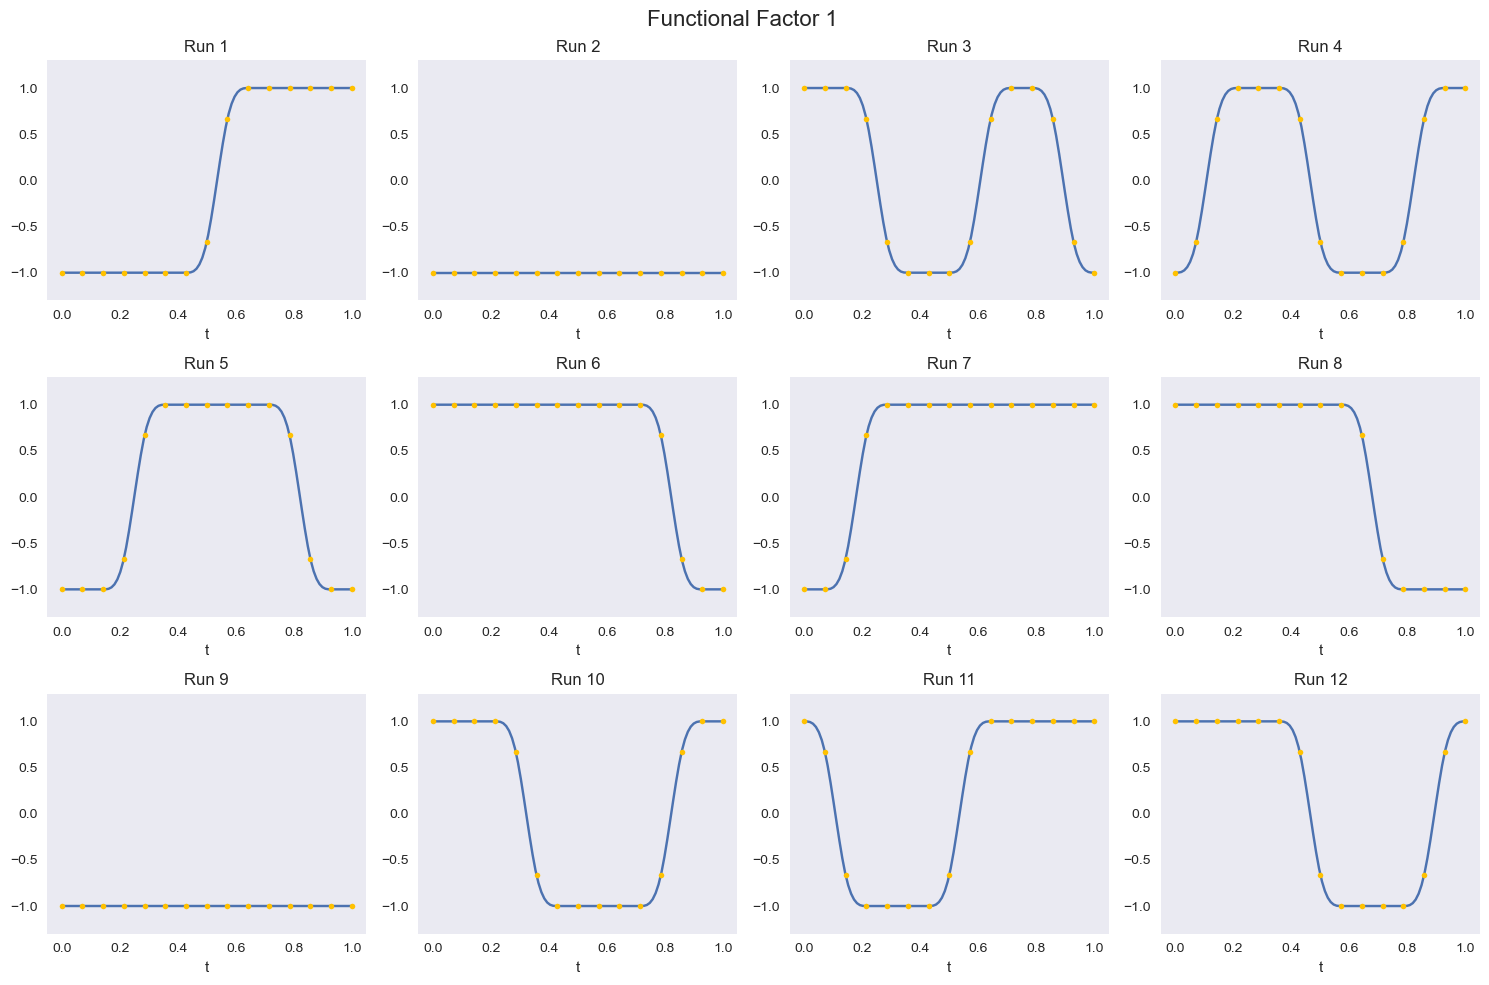

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 1.7499999747320546e-05, lambda_t: 1.026599914013716e-09, objective: 3.5535858305597115e+141, avg_tv: 3.0000000001532054


 21%|██        | 21/100 [00:45<03:20,  2.53s/it]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


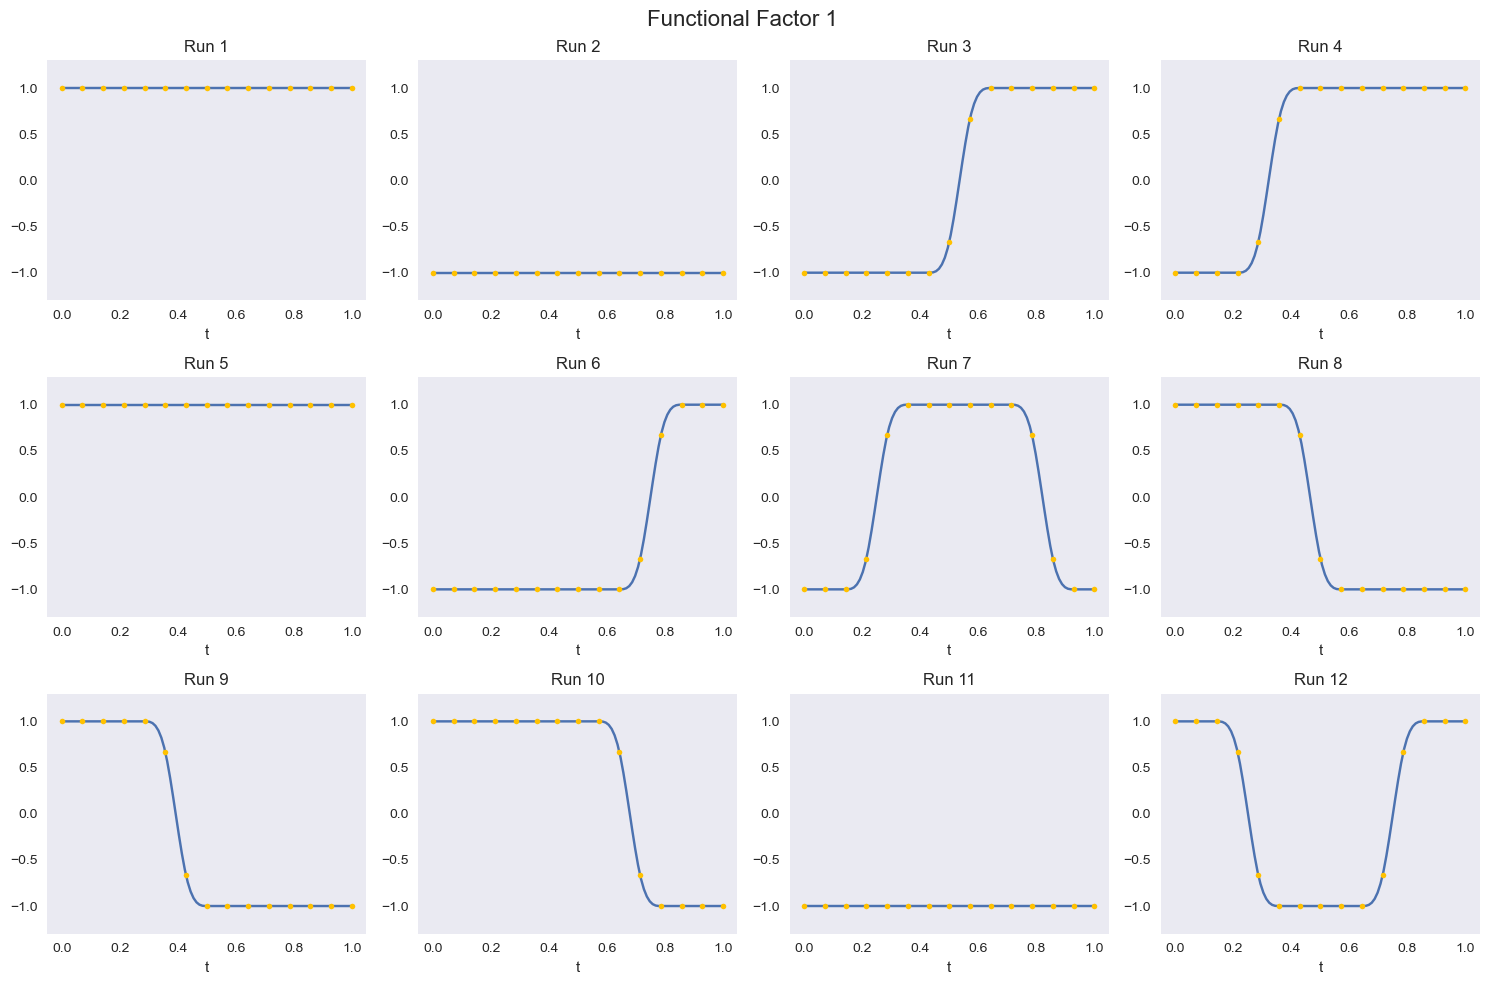

lambda_s: 0.0017499999747320545, lambda_t: 1.026599914013716e-07, objective: 4.2388406759834e+91, avg_tv: 1.666666666665364


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


In [76]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = PolynomialBasis(degree=6) # H
bt_base = FourierBasis(num_basis_functions=10) # theta
lambdas = [1e-3, 1e-1]

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=12)
    best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
    plot_design(best_design, [x_base], 12,
                sub_x=3, sub_y=4, colour="#FFC100")

    avg_tv = compute_average_variation(best_design, basis=x_base)
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}, avg_tv: {avg_tv}")

---
### Relative to lambdas efficiencies

In [118]:
def compute_relative_efficiency(model, design, criterion, lambda_s_2, lambda_t_2):
    N = design.shape[0]
    ones = np.ones((N,1))
    Gamma = np.hstack((ones, design))
    Z = Gamma @ model.J
    denom1 = np.kron(model.I_Kb_t, Z.T @ Z)
    denom2 = lambda_s_2 * np.kron(model.I_Kb_t, model.R)
    denom3 = lambda_t_2 * np.kron(model.S, model.J_HH)
    denominator = np.linalg.det(denom1 + denom2 + denom3)
    criterion_new = np.exp(np.log(1) - np.log(denominator))
    eff = criterion / criterion_new
    return eff, criterion, criterion_new

In [106]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = PolynomialBasis(degree=6) # H
bt_base = FourierBasis(num_basis_functions=10) # theta

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


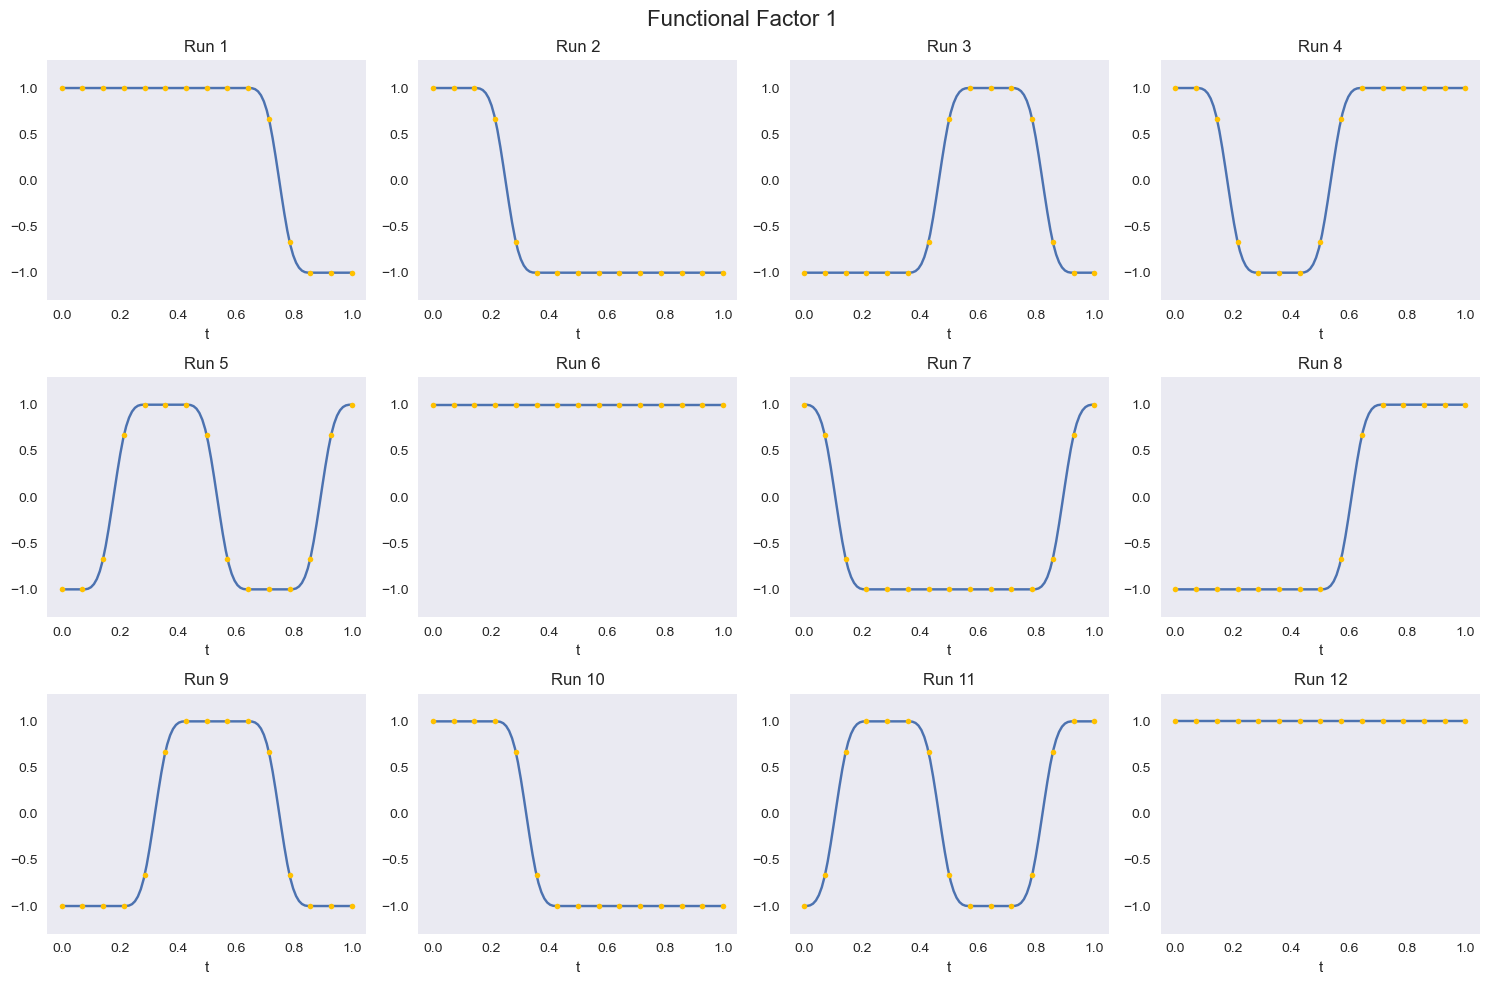

lambda_s: 0.0017499999747320545, lambda_t: 1.026599914013716e-07, objective: 2.3129648011430458e+141, avg_tv: 3.000000001616863


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


In [107]:
lambdas = 1e-3
lambda_s_1 = lambdas/np.max(np.abs(R))
lambda_t_1 = lambdas/np.max(np.abs(np.kron(S, J_HH)))
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s_1, lambda_t=lambda_t_1, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design_1, best_objective_1 = optimizer.optimize(epochs=100, refinement_epochs=10)
plot_design(best_design_1, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
avg_tv = compute_average_variation(best_design_1, basis=x_base)

print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective_1}, avg_tv: {avg_tv}")

  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


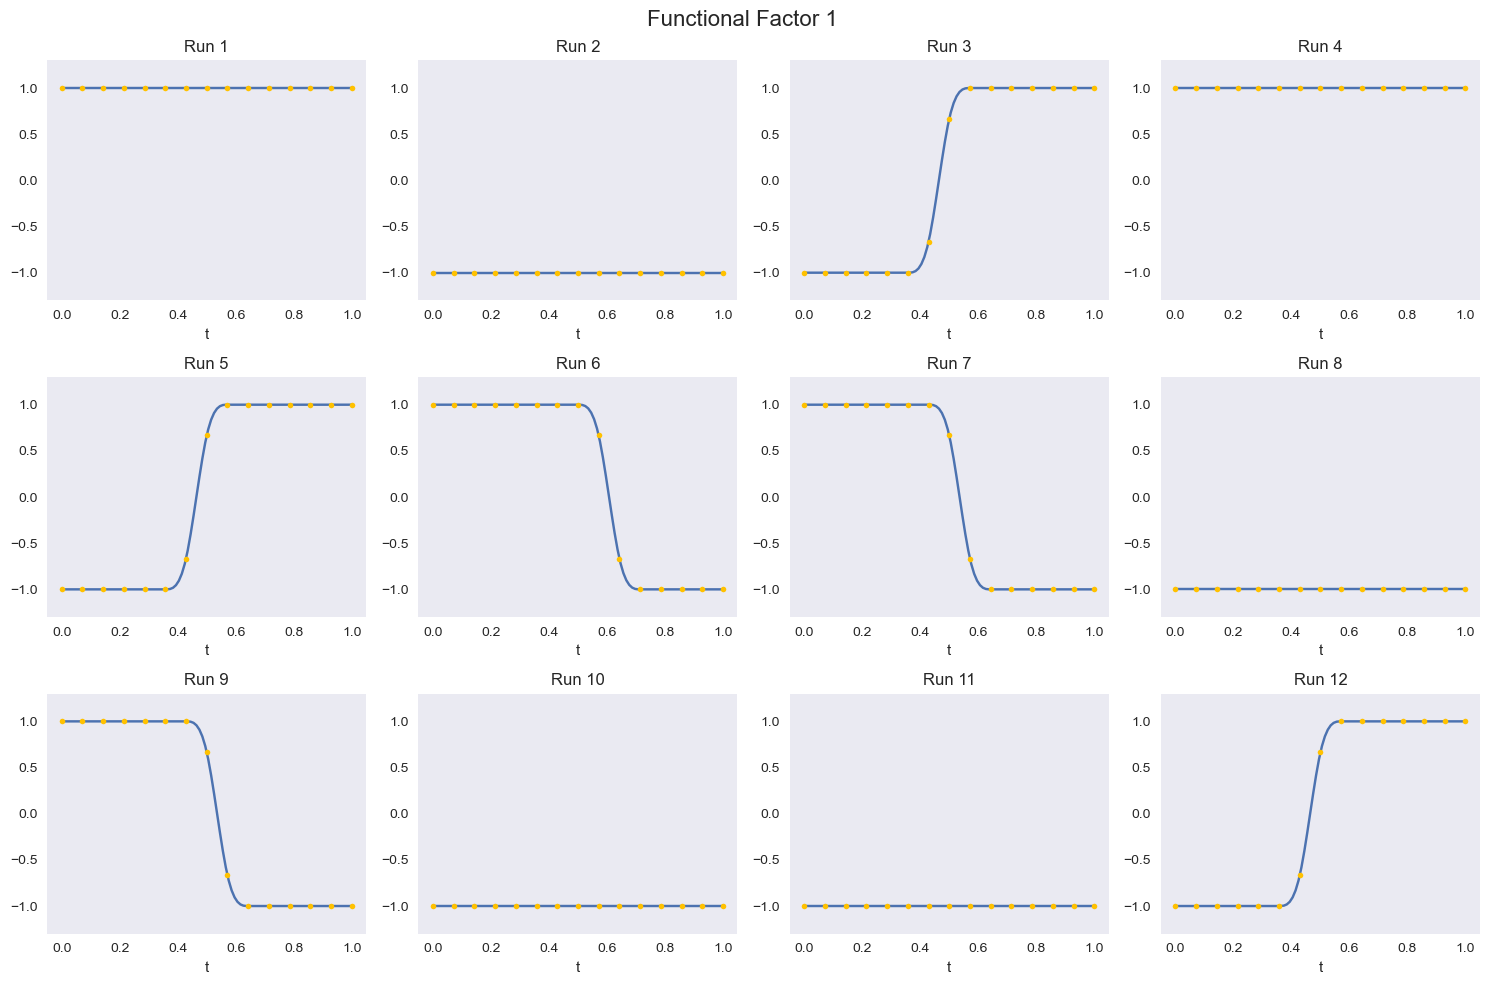

lambda_s: 0.0017499999747320545, lambda_t: 1.026599914013716e-07, objective: 338984175831.64, avg_tv: 1.00000000007914


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative


In [108]:
lambdas = 1e1
lambda_s_2 = lambdas/np.max(np.abs(R))
lambda_t_2 = lambdas/np.max(np.abs(np.kron(S, J_HH)))
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s_2, lambda_t=lambda_t_2, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design_2, best_objective_2 = optimizer.optimize(epochs=100, refinement_epochs=10)
plot_design(best_design_2, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
avg_tv = compute_average_variation(best_design_2, basis=x_base)

print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective_2}, avg_tv: {avg_tv}")

In [119]:
compute_relative_efficiency(model=model, design=best_design_1, criterion=best_objective_2, lambda_s_2=lambda_s_2, lambda_t_2=lambda_t_2)

(9.32131871902189e-05, 338984175831.64, 3636654705732565.0)

 32%|███▏      | 32/100 [01:16<01:20,  1.19s/it]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


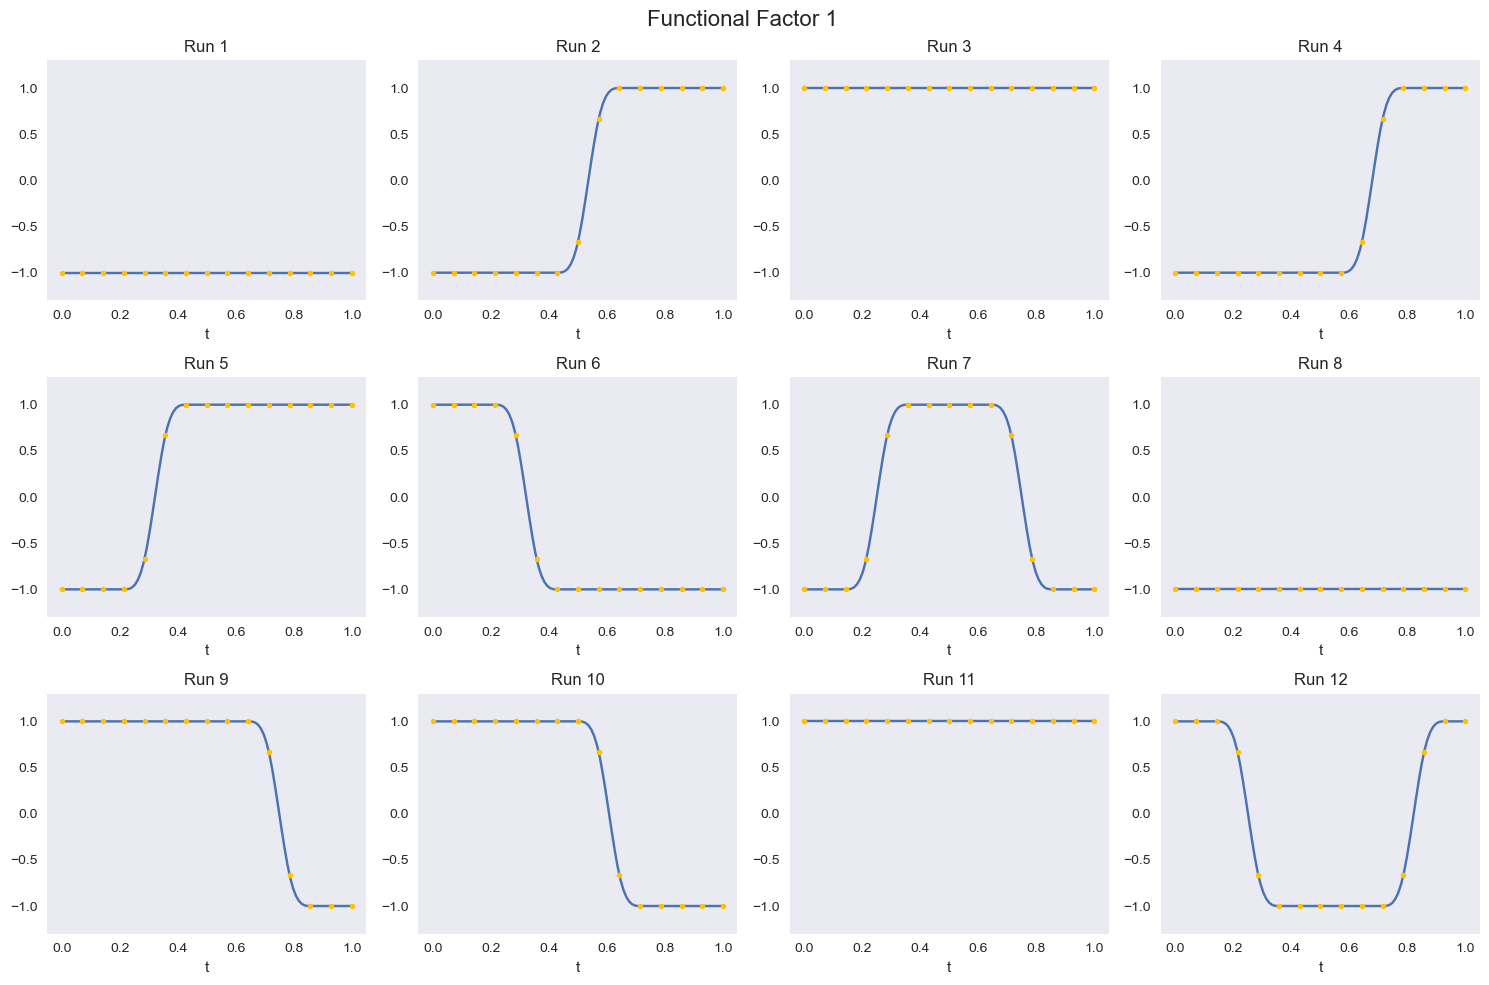

lambda_s: 0.0017499999747320545, lambda_t: 1.026599914013716e-07, objective: 4.0607932062501766e+91, avg_tv: 1.666666666648929


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


In [112]:
lambdas = 1e-1
lambda_s_3 = lambdas/np.max(np.abs(R))
lambda_t_3 = lambdas/np.max(np.abs(np.kron(S, J_HH)))
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s_3, lambda_t=lambda_t_3, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design_3, best_objective_3 = optimizer.optimize(epochs=100, refinement_epochs=10)
plot_design(best_design_3, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
avg_tv = compute_average_variation(best_design_3, basis=x_base)

print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective_3}, avg_tv: {avg_tv}")

In [121]:
compute_relative_efficiency(model=model, design=best_design_1, criterion=best_objective_3, lambda_s_2=lambda_s_3, lambda_t_2=lambda_t_3)

(0.0031529831211062316, 4.0607932062501766e+91, 1.2879210101275257e+94)

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


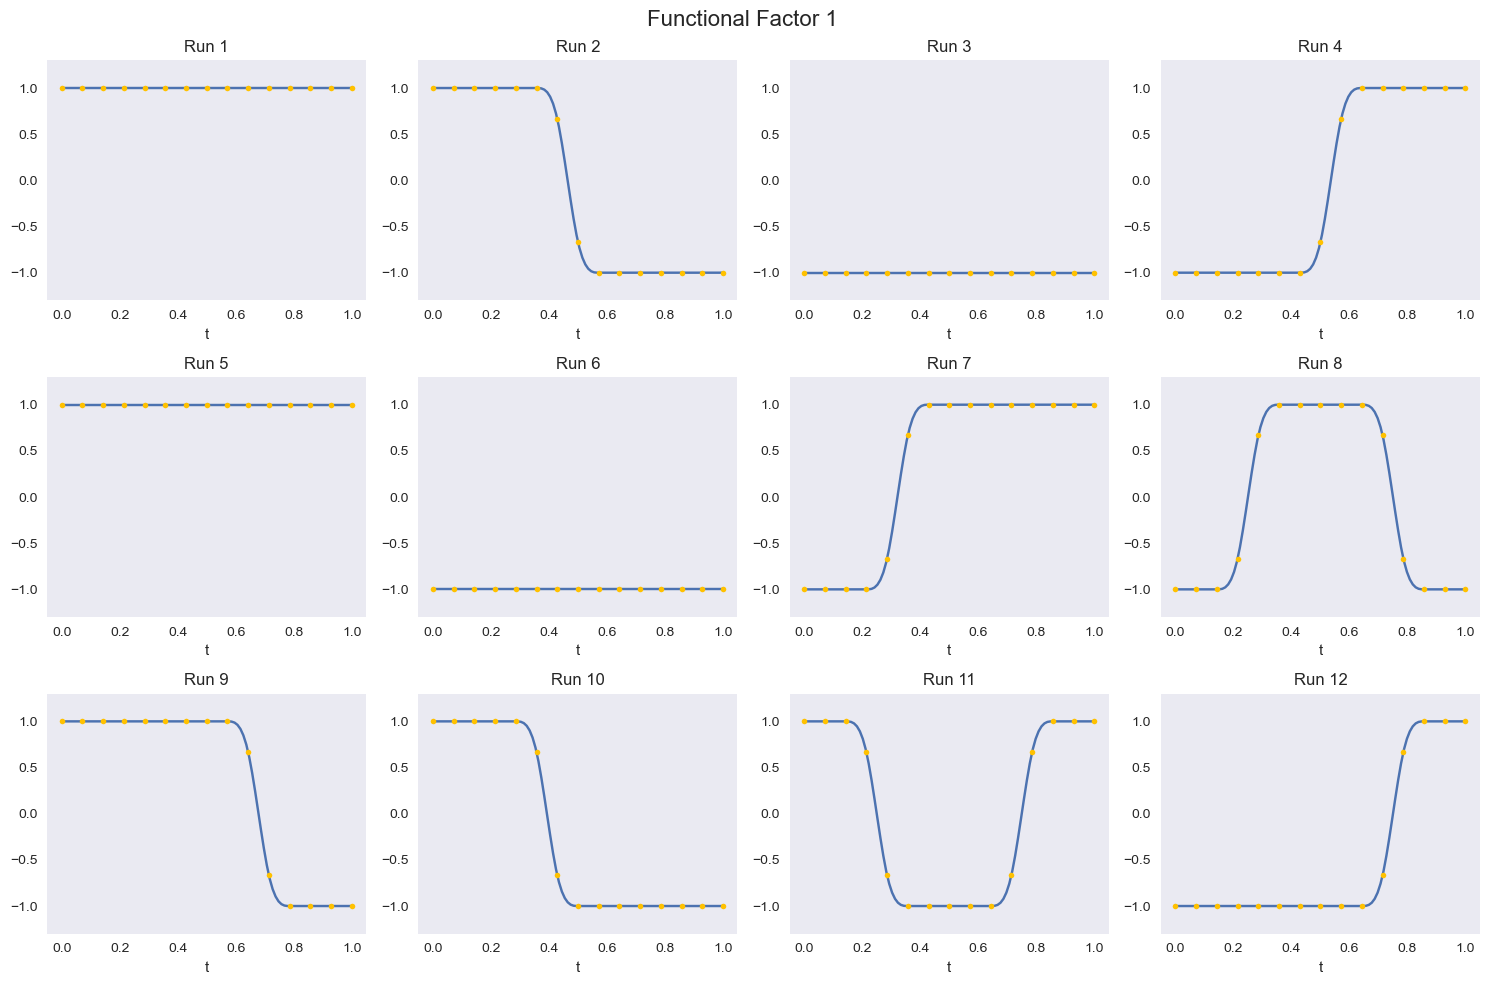

lambda_s: 0.0017499999747320545, lambda_t: 1.026599914013716e-07, objective: 5.08527163913269e+91, avg_tv: 1.6666666666544827


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative


In [114]:
lambdas = 1e-1
lambda_s_4 = lambdas/np.max(np.abs(R))
lambda_t_4 = 0
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s_4, lambda_t=lambda_t_4, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design_4, best_objective_4 = optimizer.optimize(epochs=100, refinement_epochs=10)
plot_design(best_design_4, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
avg_tv = compute_average_variation(best_design_4, basis=x_base)

print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective_4}, avg_tv: {avg_tv}")

In [122]:
compute_relative_efficiency(model=model, design=best_design_1, criterion=best_objective_4, lambda_s_2=lambda_s_4, lambda_t_2=lambda_t_4)

(0.002979951789997147, 5.08527163913269e+91, 1.7064946004168606e+94)

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


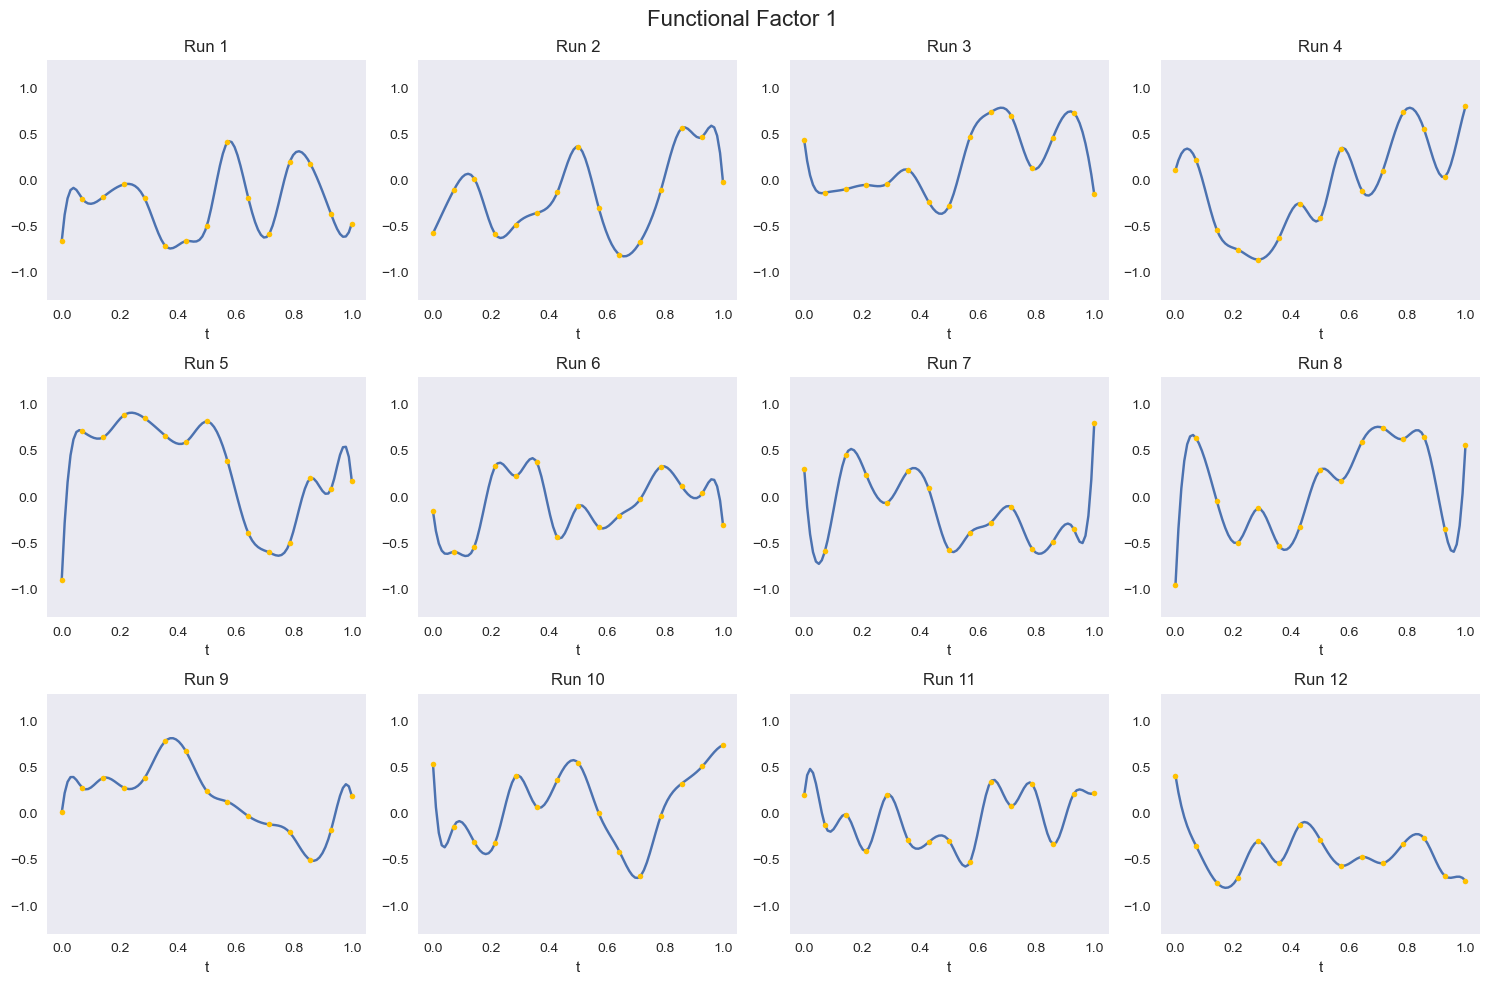

lambda_s: 0.0017499999747320545, lambda_t: 1.026599914013716e-07, objective: 1.675055551834515e-30, avg_tv: 5.666269512786621


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


In [123]:
lambdas = 100
lambda_s_5 = lambdas/np.max(np.abs(R))
lambda_t_5 = lambdas/np.max(np.abs(np.kron(S, J_HH)))
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s_5, lambda_t=lambda_t_5, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design_5, best_objective_5 = optimizer.optimize(epochs=100, refinement_epochs=10)
plot_design(best_design_5, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
avg_tv = compute_average_variation(best_design_5, basis=x_base)

print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective_5}, avg_tv: {avg_tv}")

In [126]:
np.max(np.abs(np.kron(S, J_HH)))

974089.3081612311

In [124]:
compute_relative_efficiency(model=model, design=best_design_2, criterion=best_objective_5, lambda_s_2=lambda_s_5, lambda_t_2=lambda_t_5)

(271457804.7941372, 1.675055551834515e-30, 6.170592711838993e-39)

---

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
 11%|█         | 11/100 [00:57<01:57,  1.32s/it]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


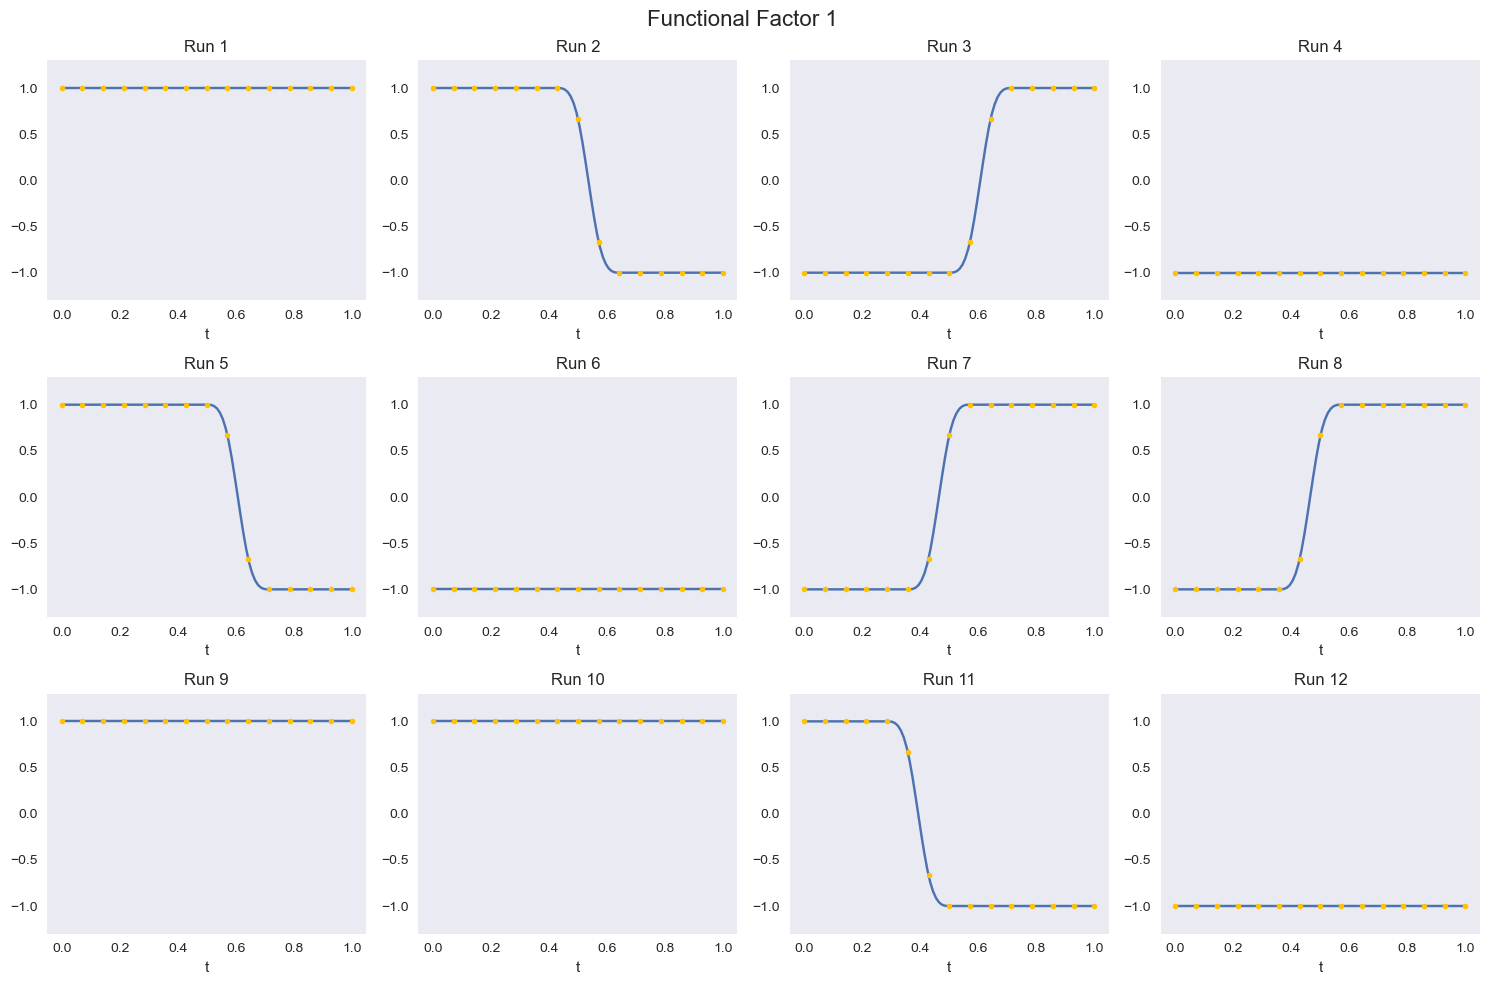

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative


lambda_s: 0.008333333330429998, lambda_t: 1.026599914013716e-07, objective: 2.875711228469577e+16, avg_tv: 0.9999999999772627


100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


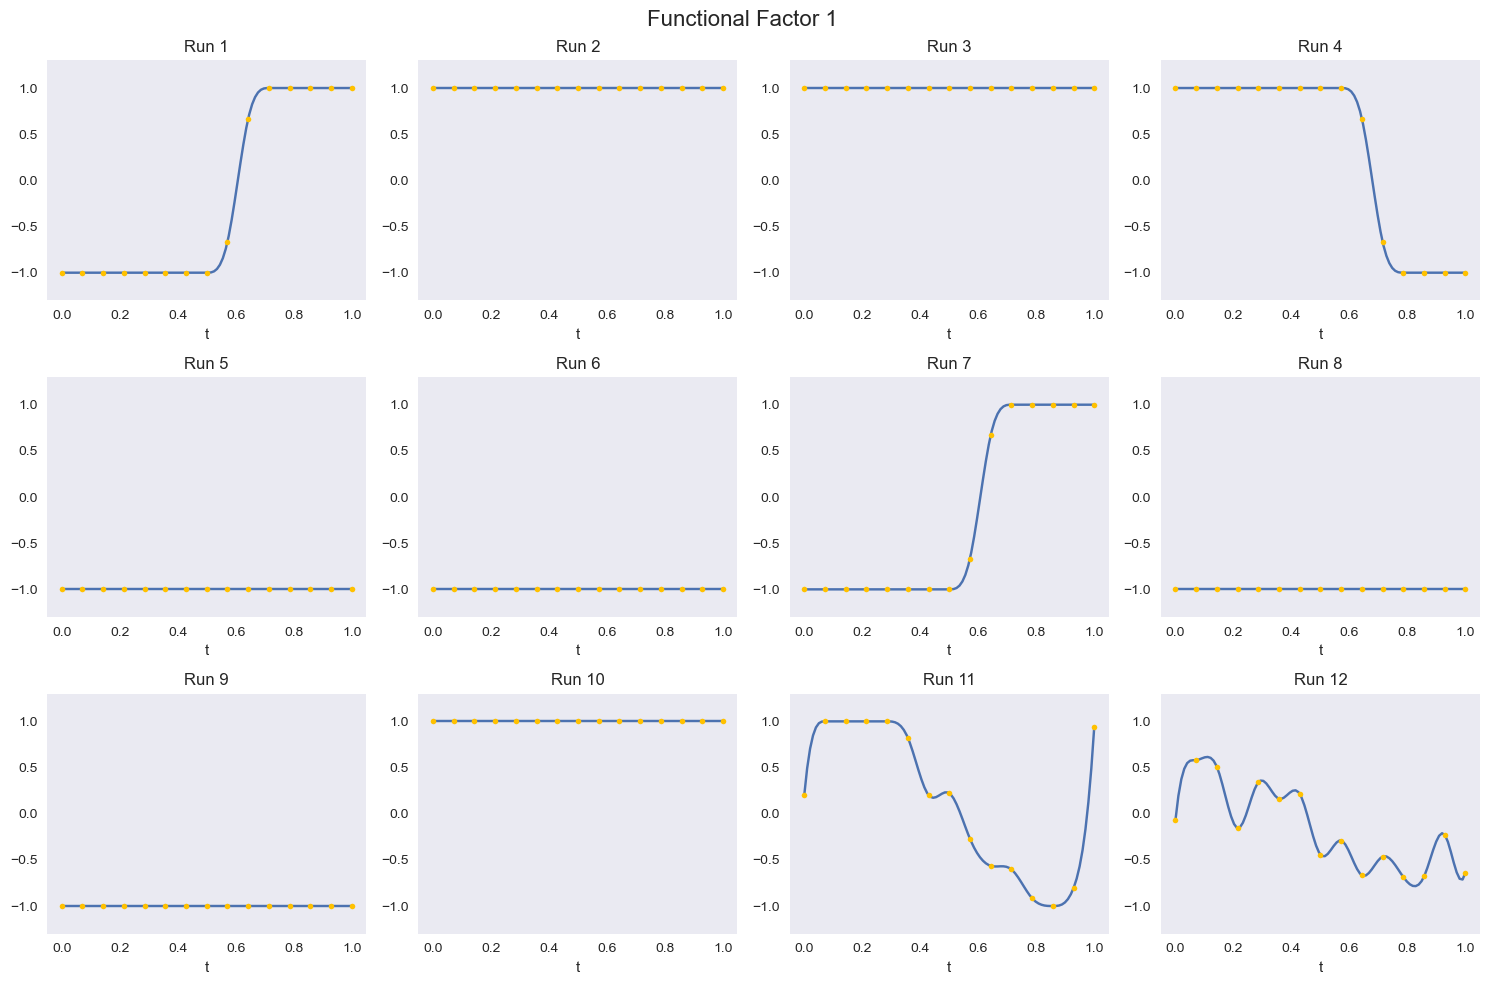

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.09999999996515999, lambda_t: 1.2319198968164595e-06, objective: 0.00012779549253407873, avg_tv: 1.3430895938678689


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


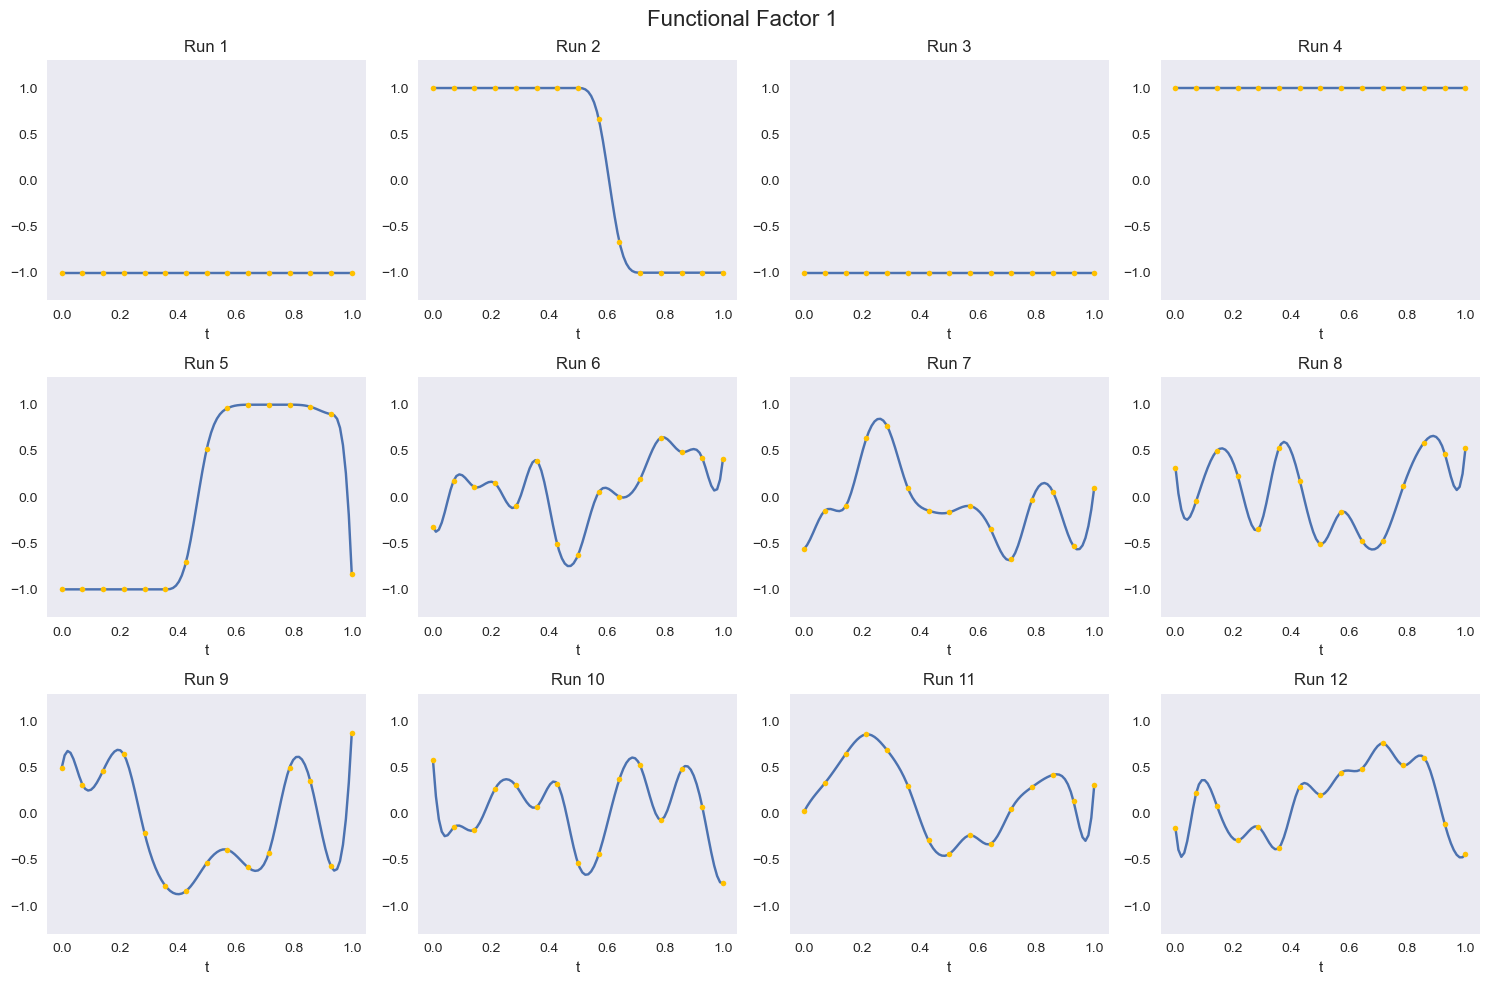

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.19166666659988996, lambda_t: 2.361179802231547e-06, objective: 1.8966837437633437e-05, avg_tv: 3.99646694955136


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


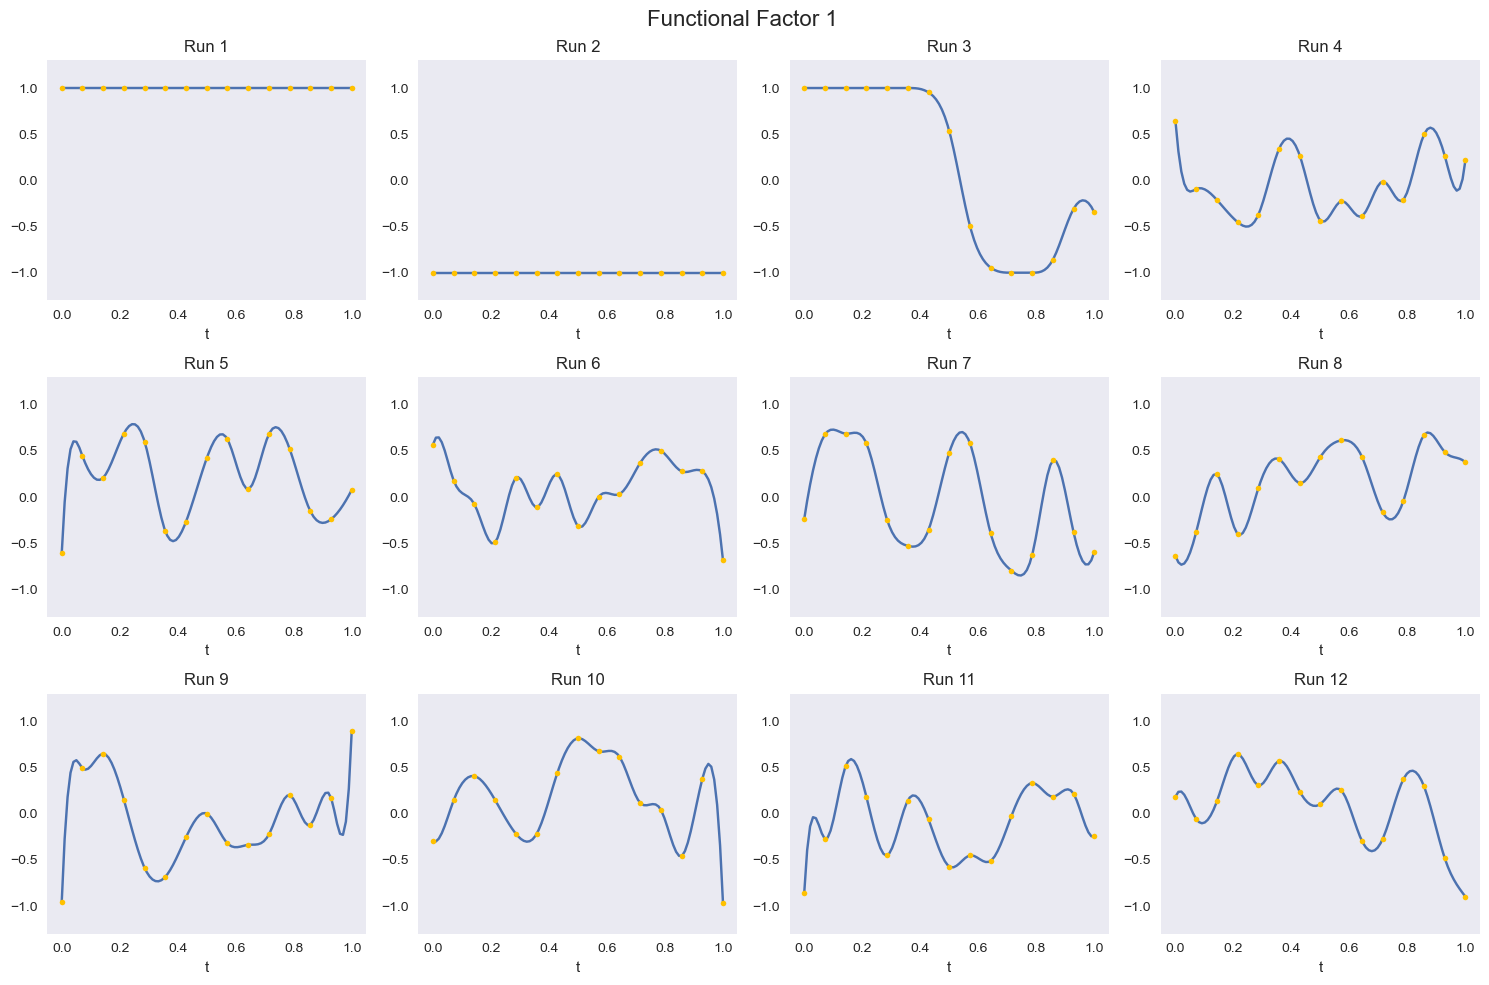

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.28333333323461996, lambda_t: 3.490439707646635e-06, objective: 1.1552157433370423e-05, avg_tv: 4.972801507211806


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


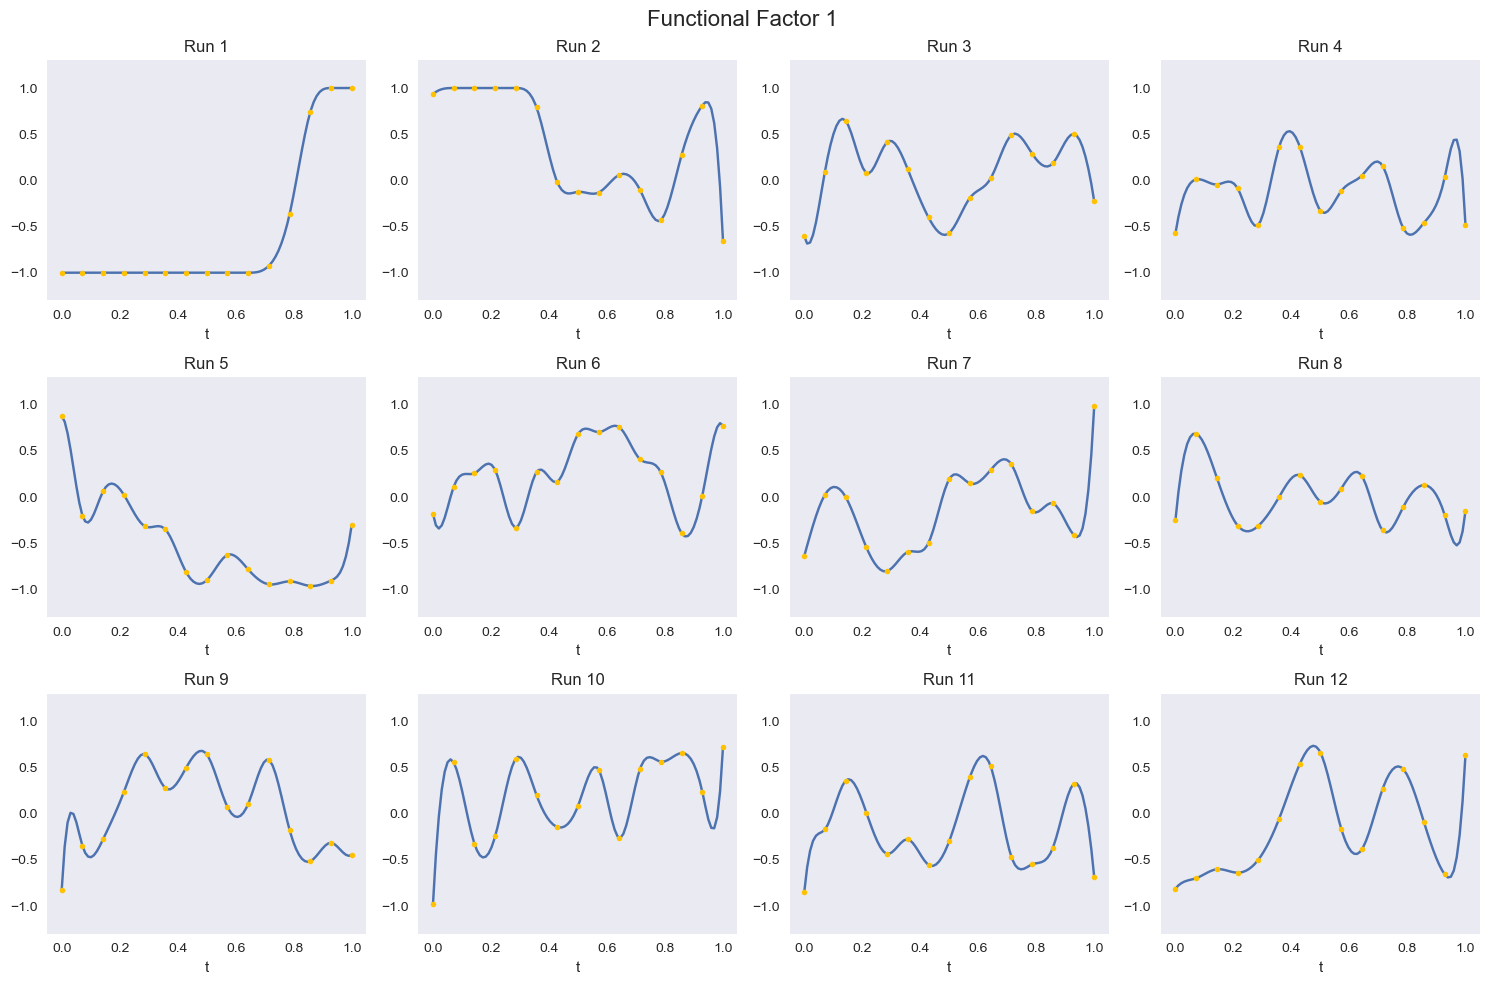

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.3749999998693499, lambda_t: 4.619699613061722e-06, objective: 5.128802377339101e-06, avg_tv: 5.643658036349138


100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


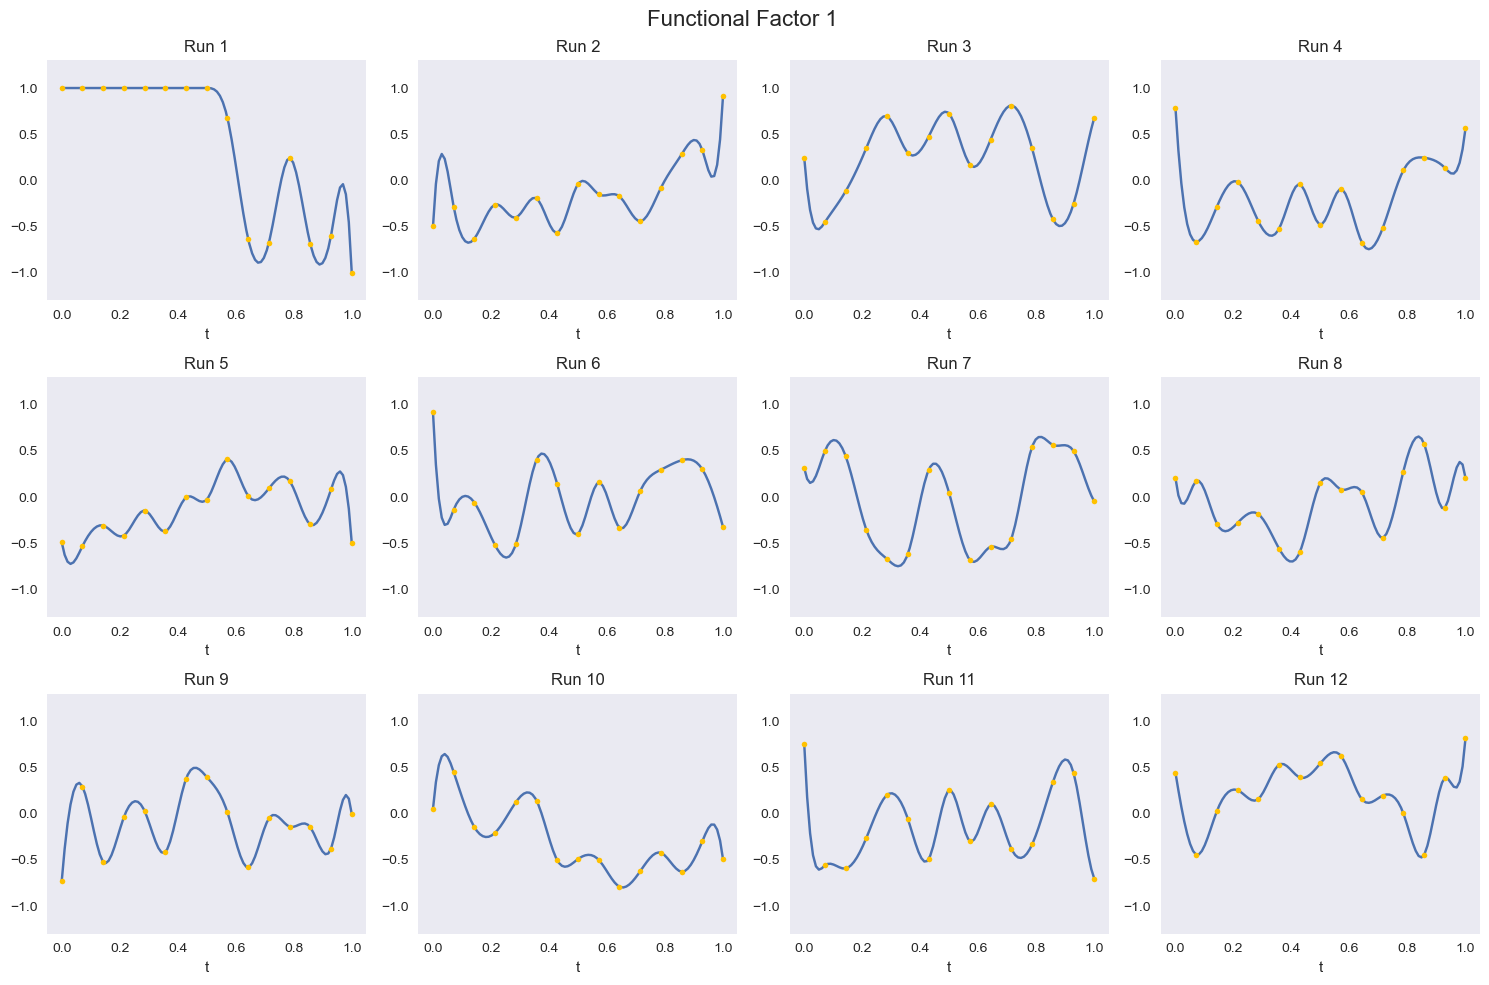

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.46666666650407984, lambda_t: 5.7489595184768095e-06, objective: 5.562004851563179e-06, avg_tv: 6.158766602784879


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


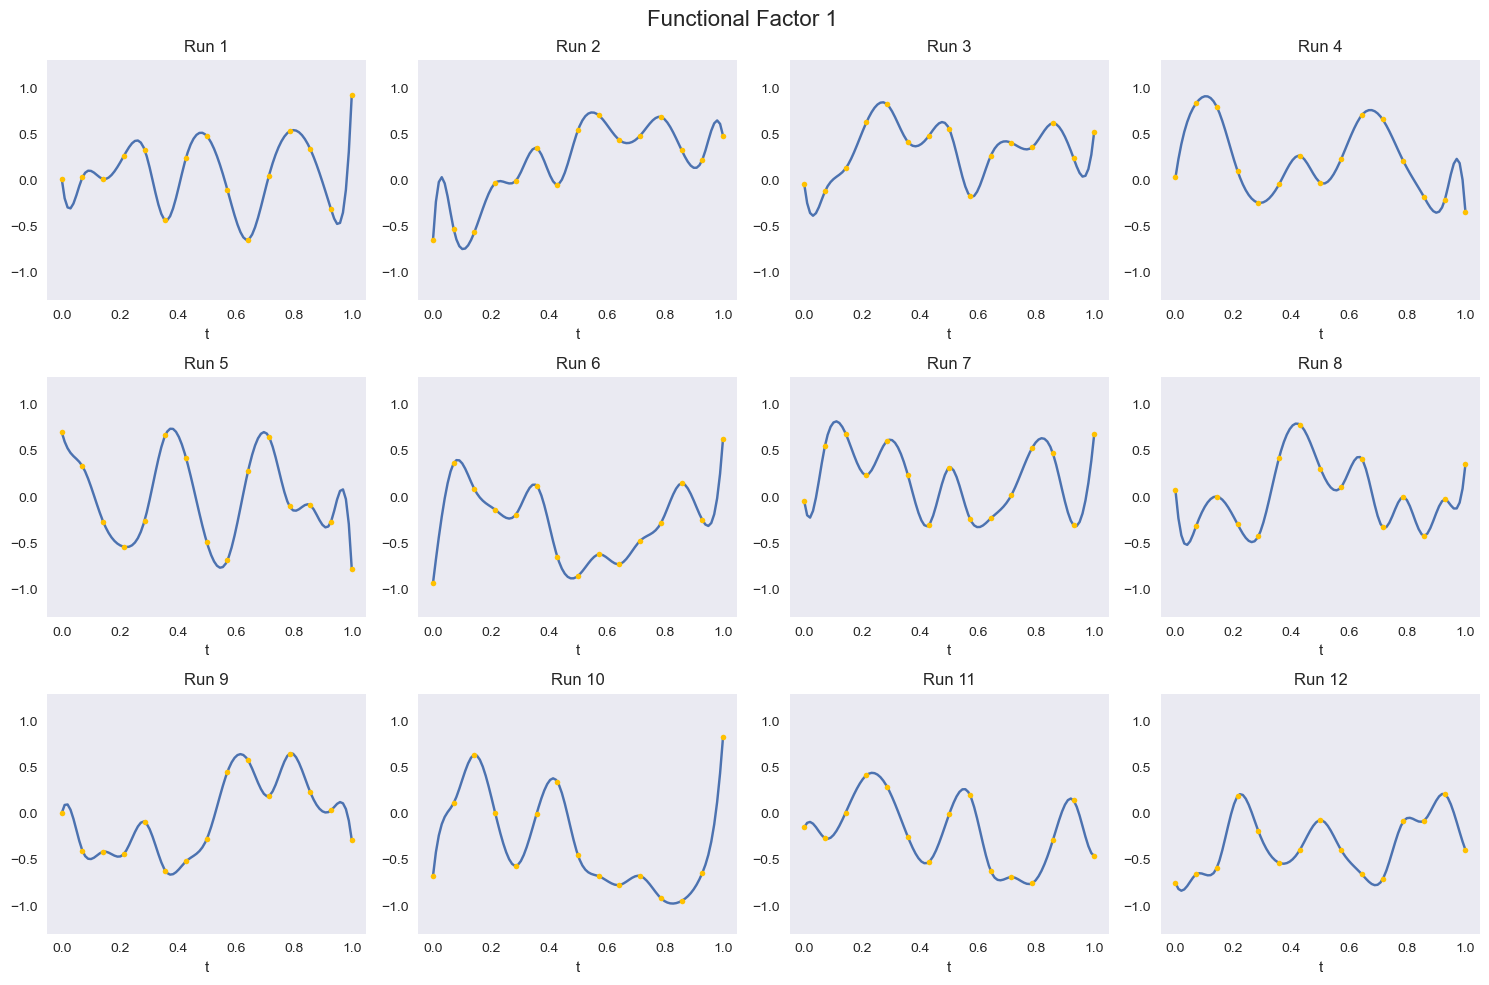

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.5583333331388098, lambda_t: 6.878219423891898e-06, objective: 6.769576593012413e-08, avg_tv: 6.22124320203899


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


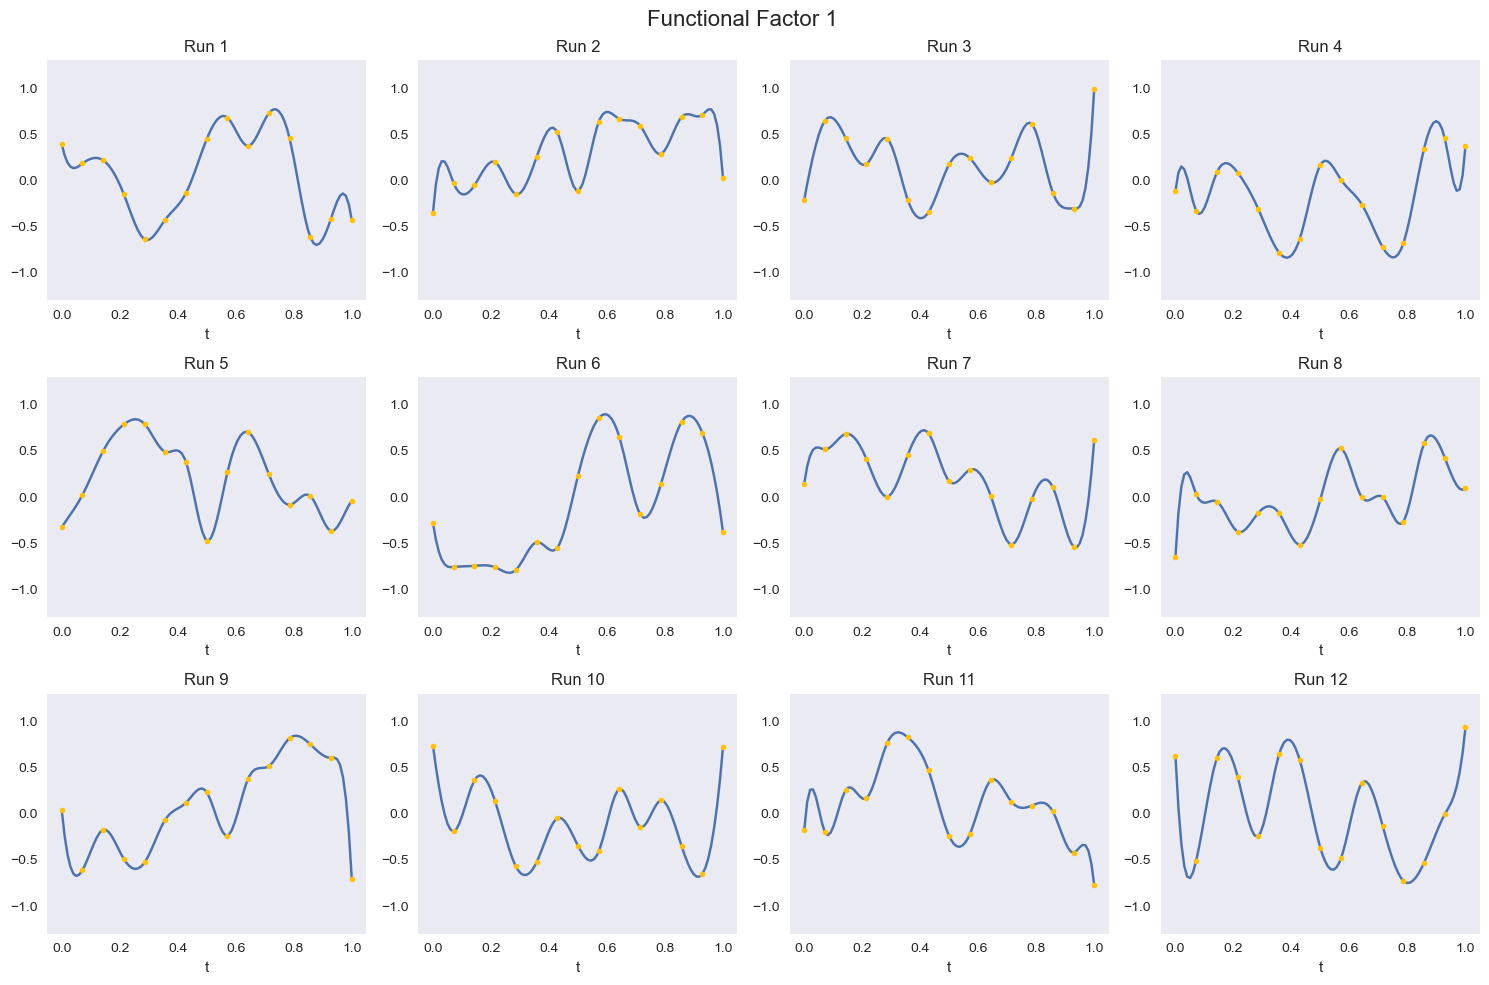

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.6499999997735398, lambda_t: 8.007479329306986e-06, objective: 8.122262113702014e-10, avg_tv: 6.42196100496231


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


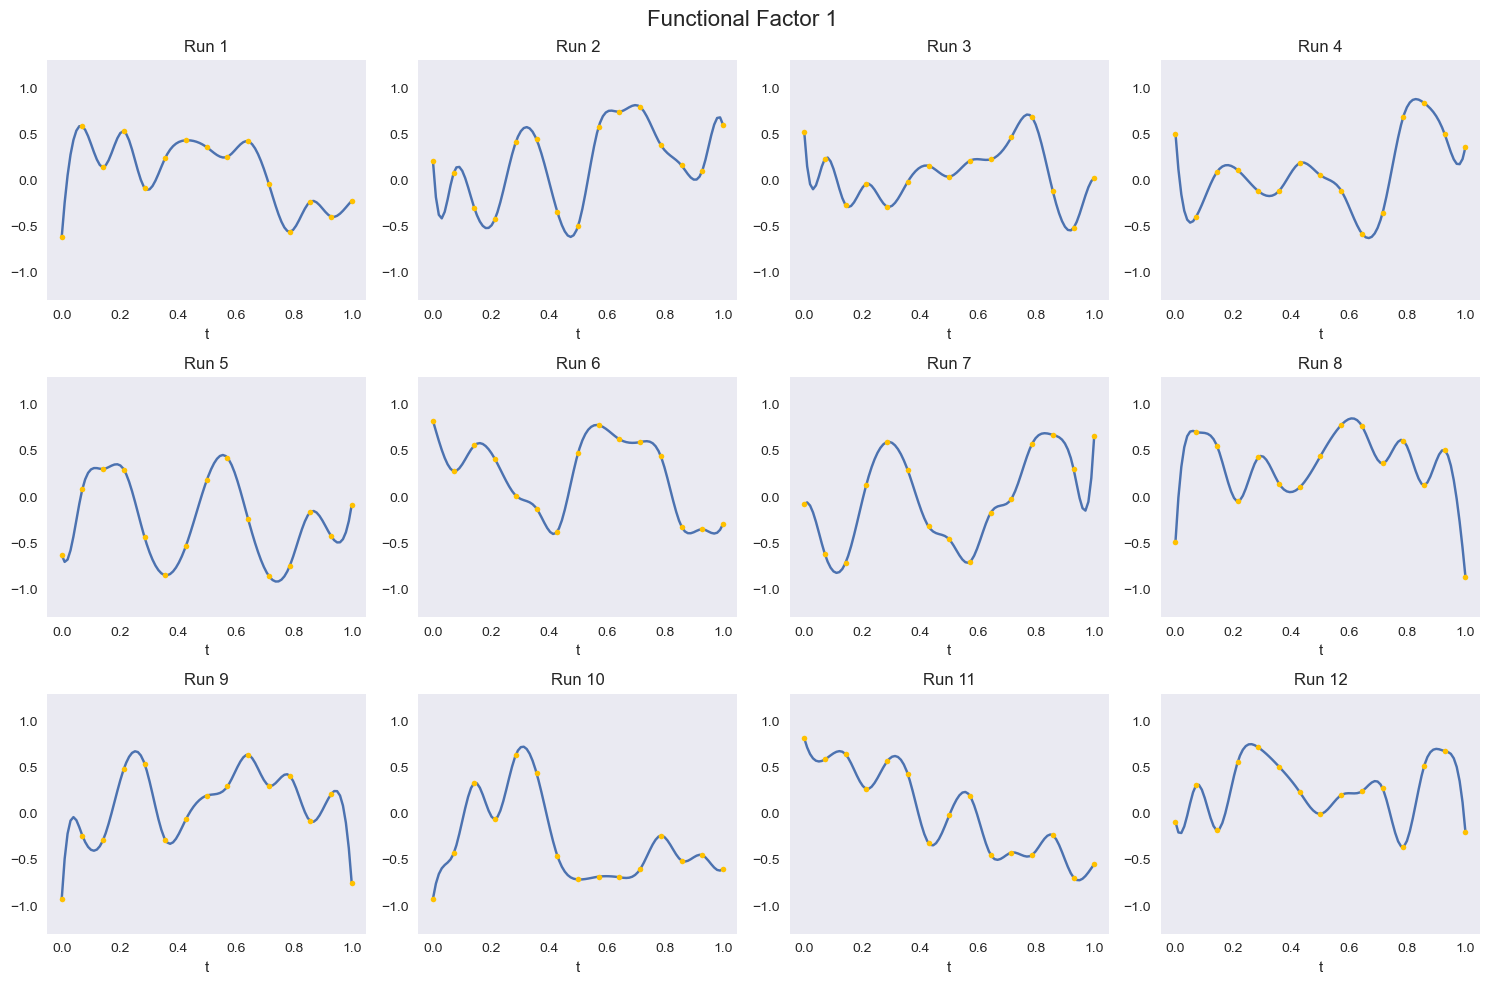

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.7416666664082698, lambda_t: 9.136739234722073e-06, objective: 8.6478417532108e-12, avg_tv: 5.762673214027565


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


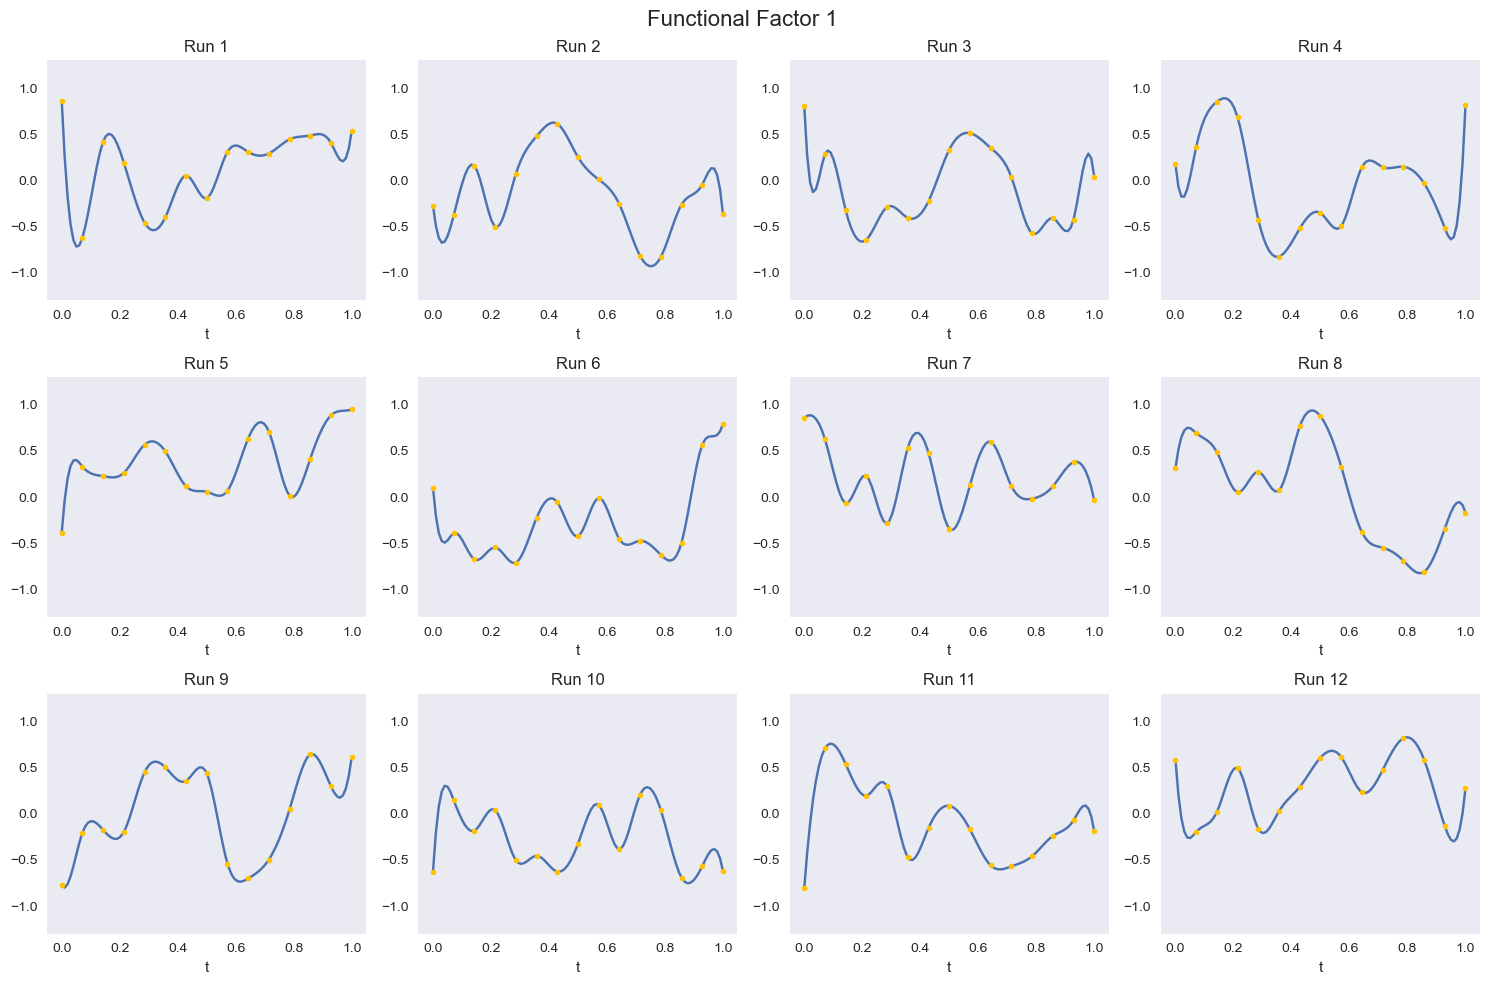

lambda_s: 0.8333333330429997, lambda_t: 1.0265999140137161e-05, objective: 2.3827479428184355e-13, avg_tv: 5.821212603764617


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


In [139]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = PolynomialBasis(degree=6) # H
bt_base = FourierBasis(num_basis_functions=10) # theta
lambdas = np.linspace(1e-1, 1e1, 10)

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=12)
    best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
    plot_design(best_design, [x_base], 12,
                sub_x=3, sub_y=4, colour="#FFC100")
    avg_tv = compute_average_variation(best_design, basis=x_base)
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}, avg_tv: {avg_tv}")

 18%|█▊        | 9/50 [00:06<00:22,  1.79it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


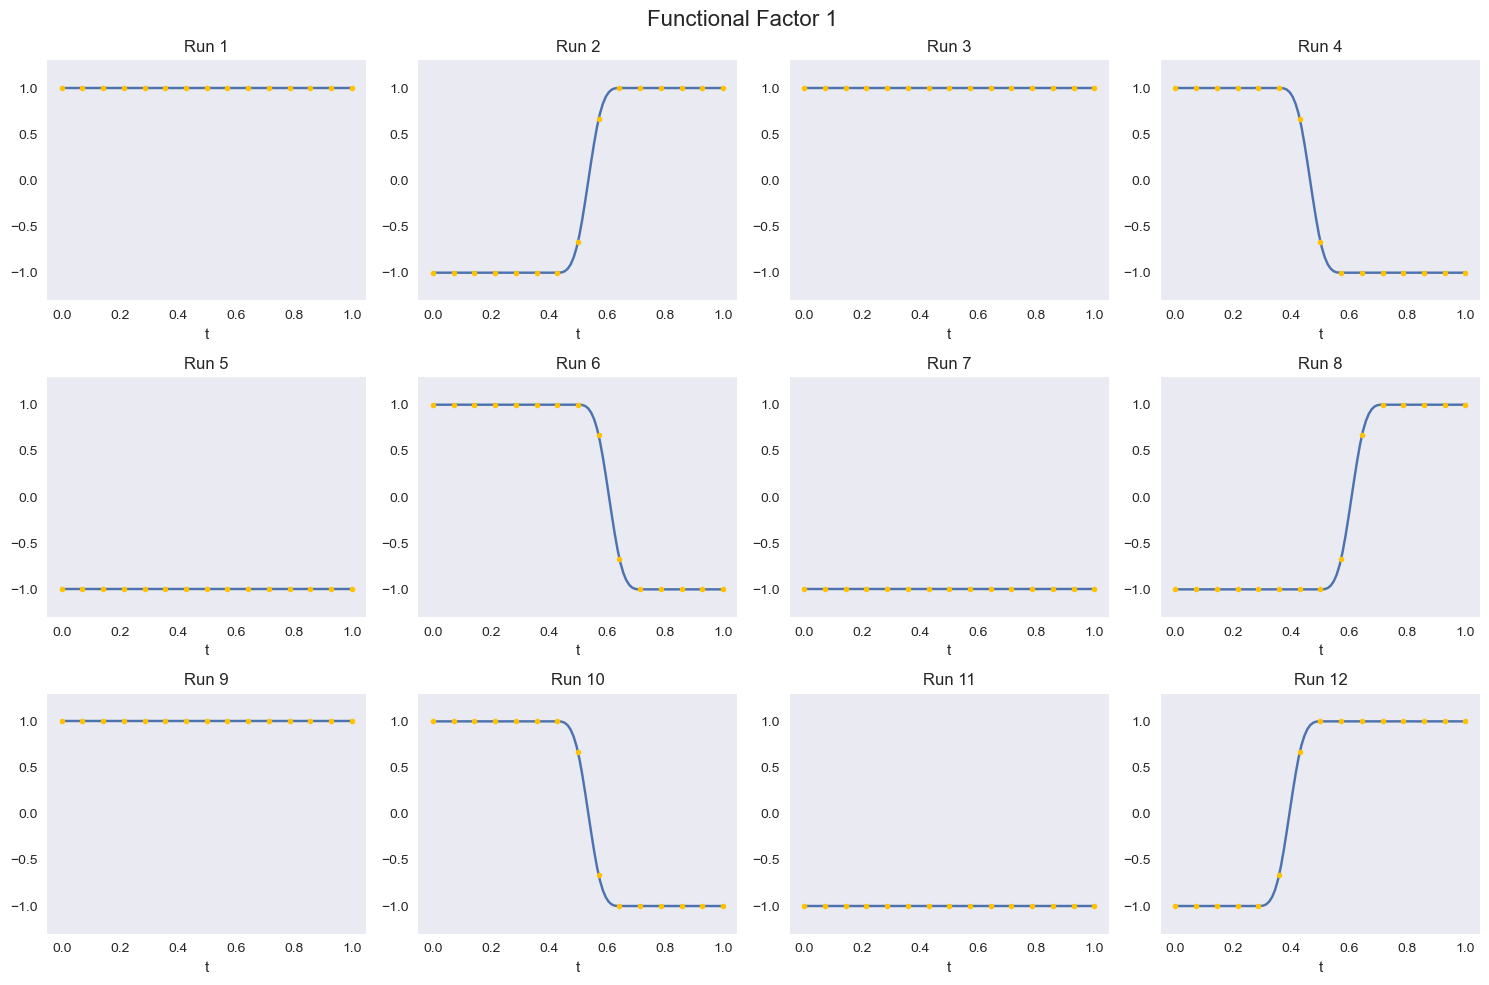

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative


lambda_s: 0.008333333330429998, lambda_t: 0, objective: 3.4436920379727584e+16, avg_tv: 0.9999999999772622


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


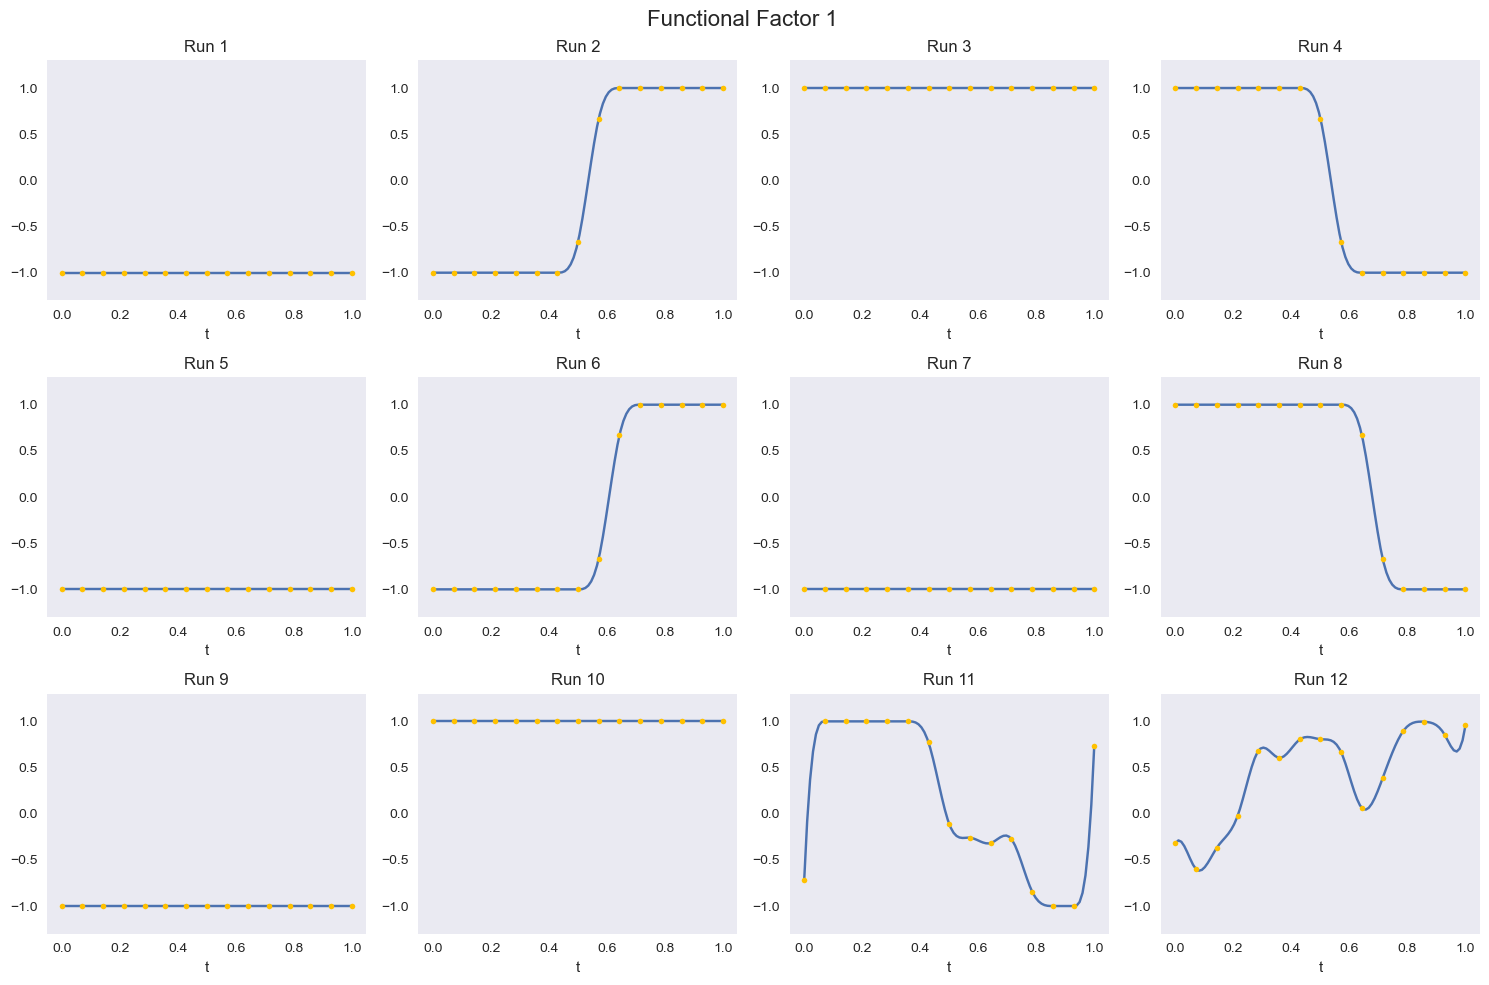

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.09999999996515999, lambda_t: 0, objective: 0.00012763697202316338, avg_tv: 1.5009041556719802


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


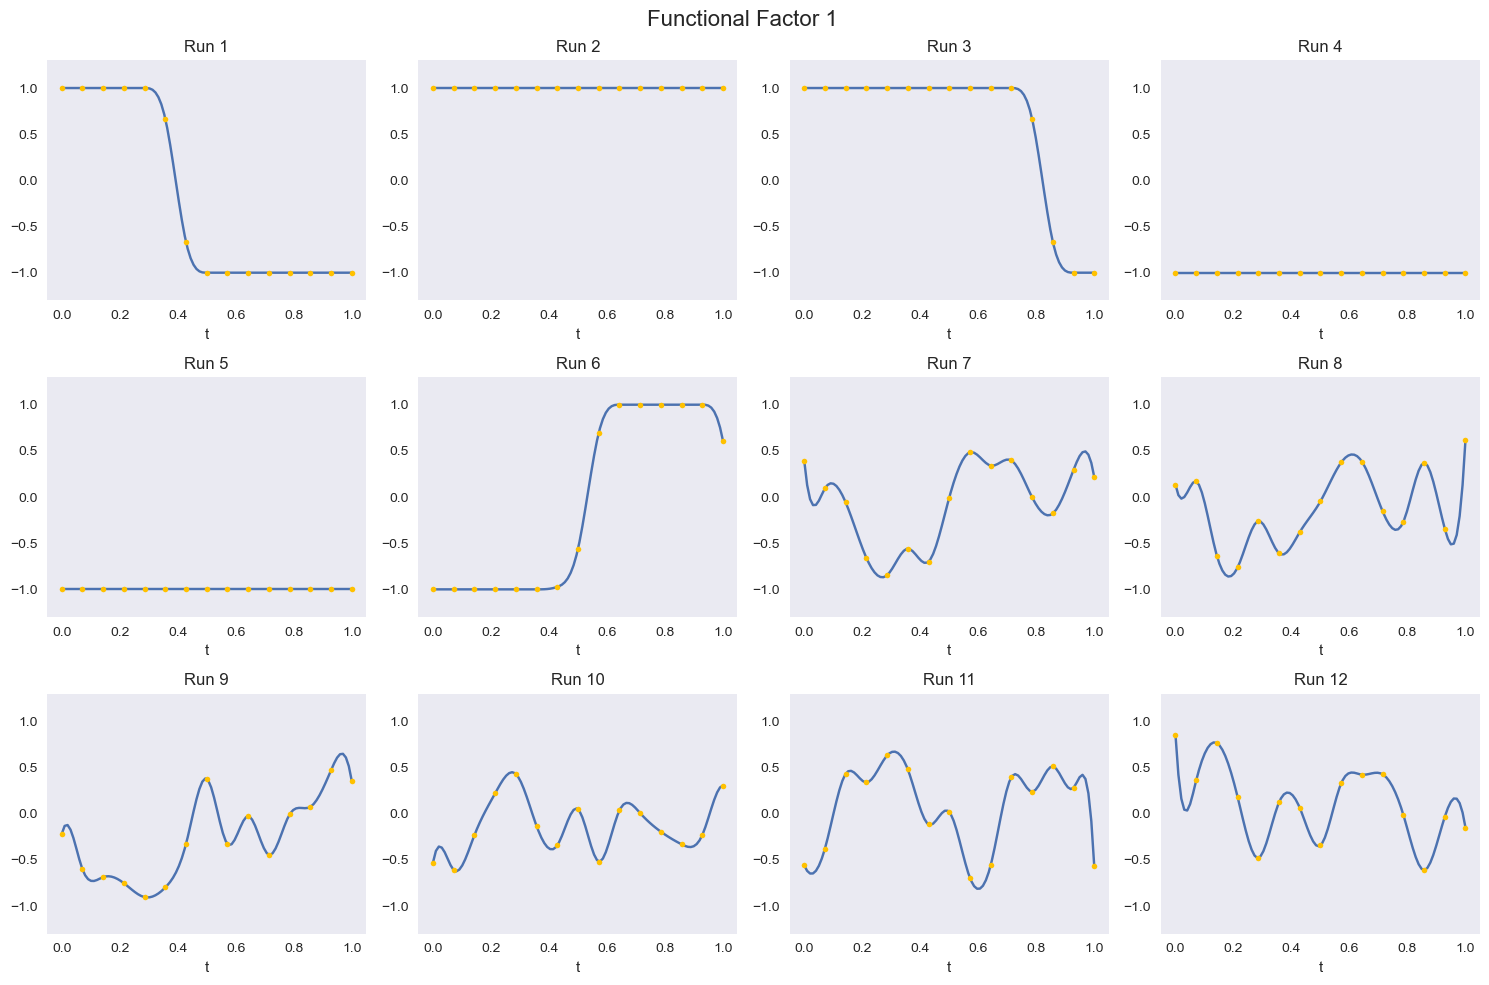

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.19166666659988996, lambda_t: 0, objective: 3.167100157327174e-05, avg_tv: 3.5512778872499062


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


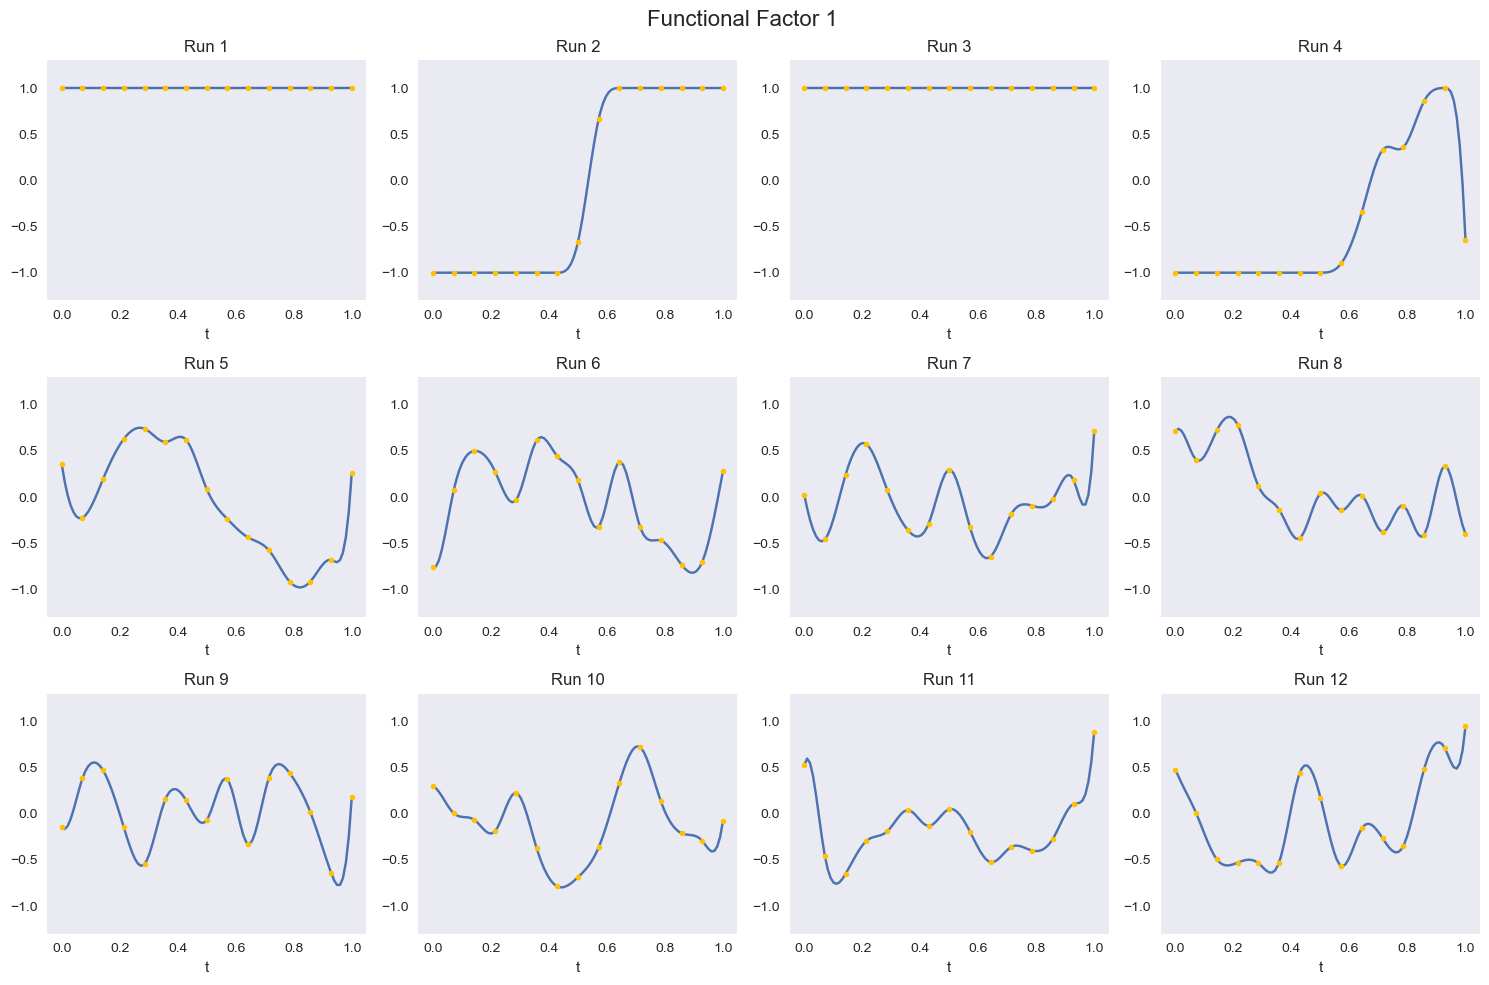

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.28333333323461996, lambda_t: 0, objective: 2.2763355539478035e-05, avg_tv: 4.352909534088766


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


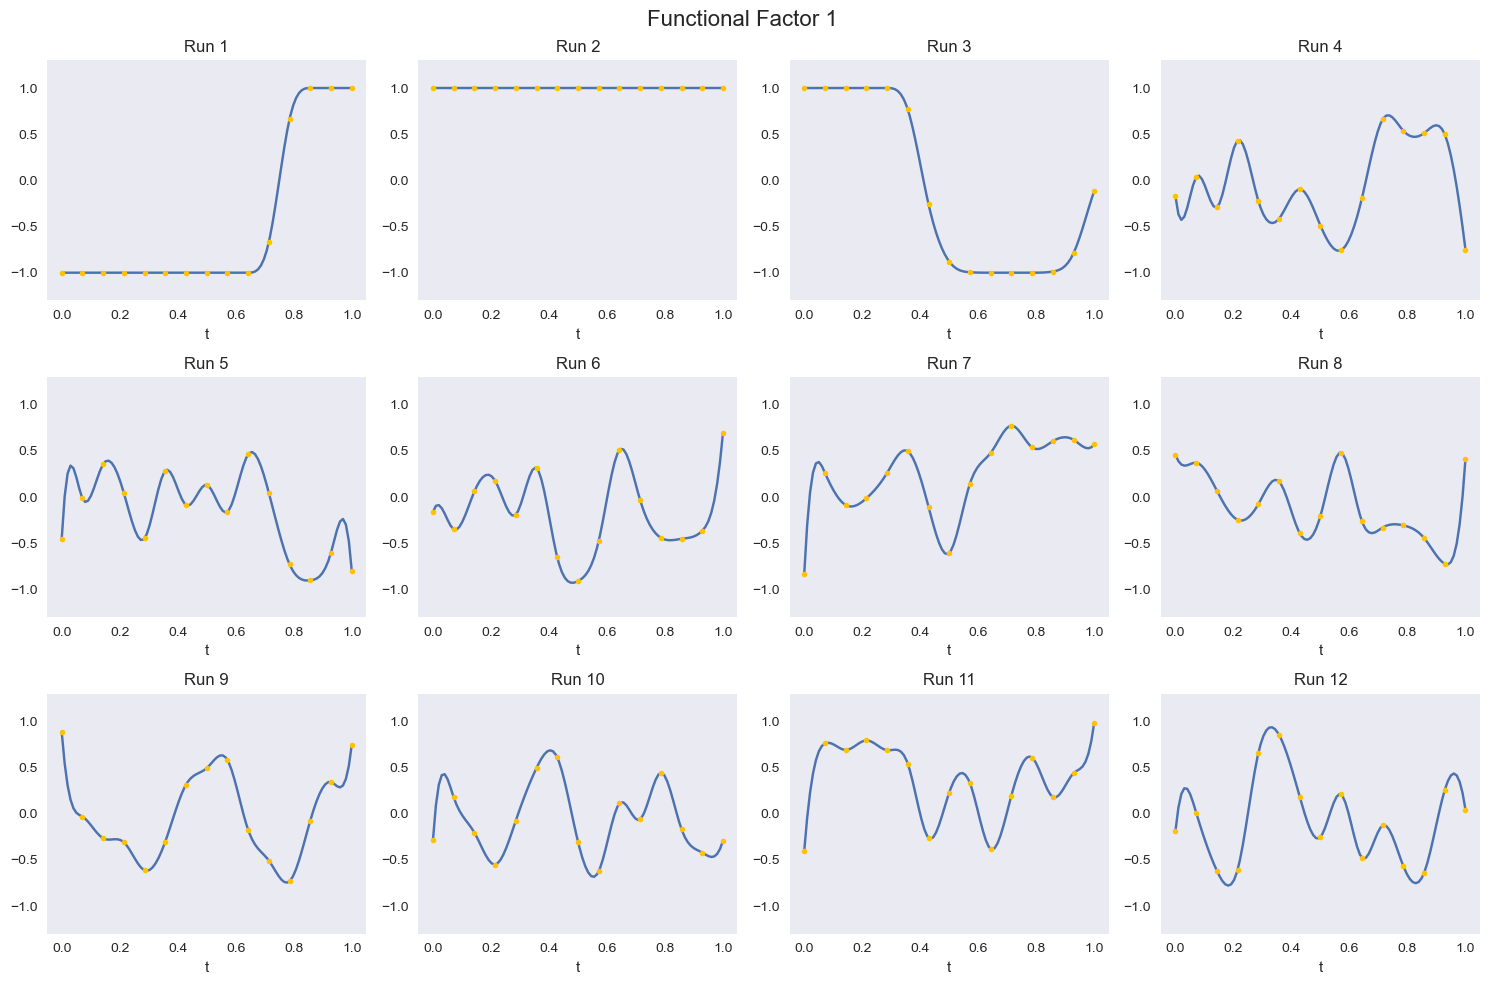

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.3749999998693499, lambda_t: 0, objective: 1.1812499588743242e-05, avg_tv: 5.331801750250681


100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


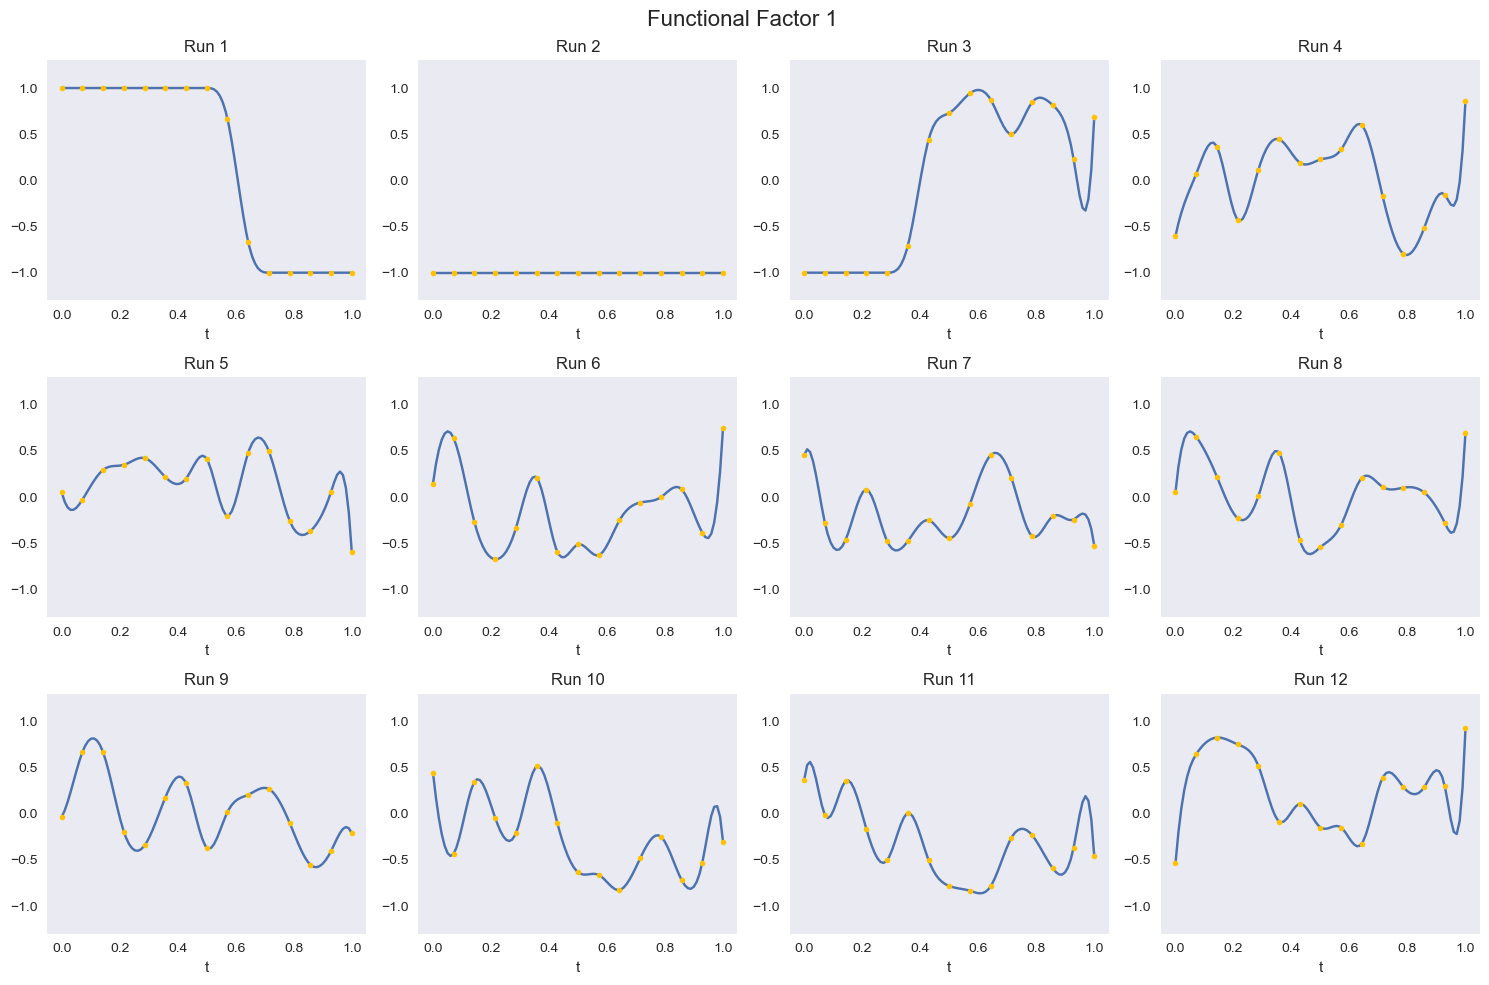

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.46666666650407984, lambda_t: 0, objective: 3.780498286438682e-06, avg_tv: 5.222338828106547


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


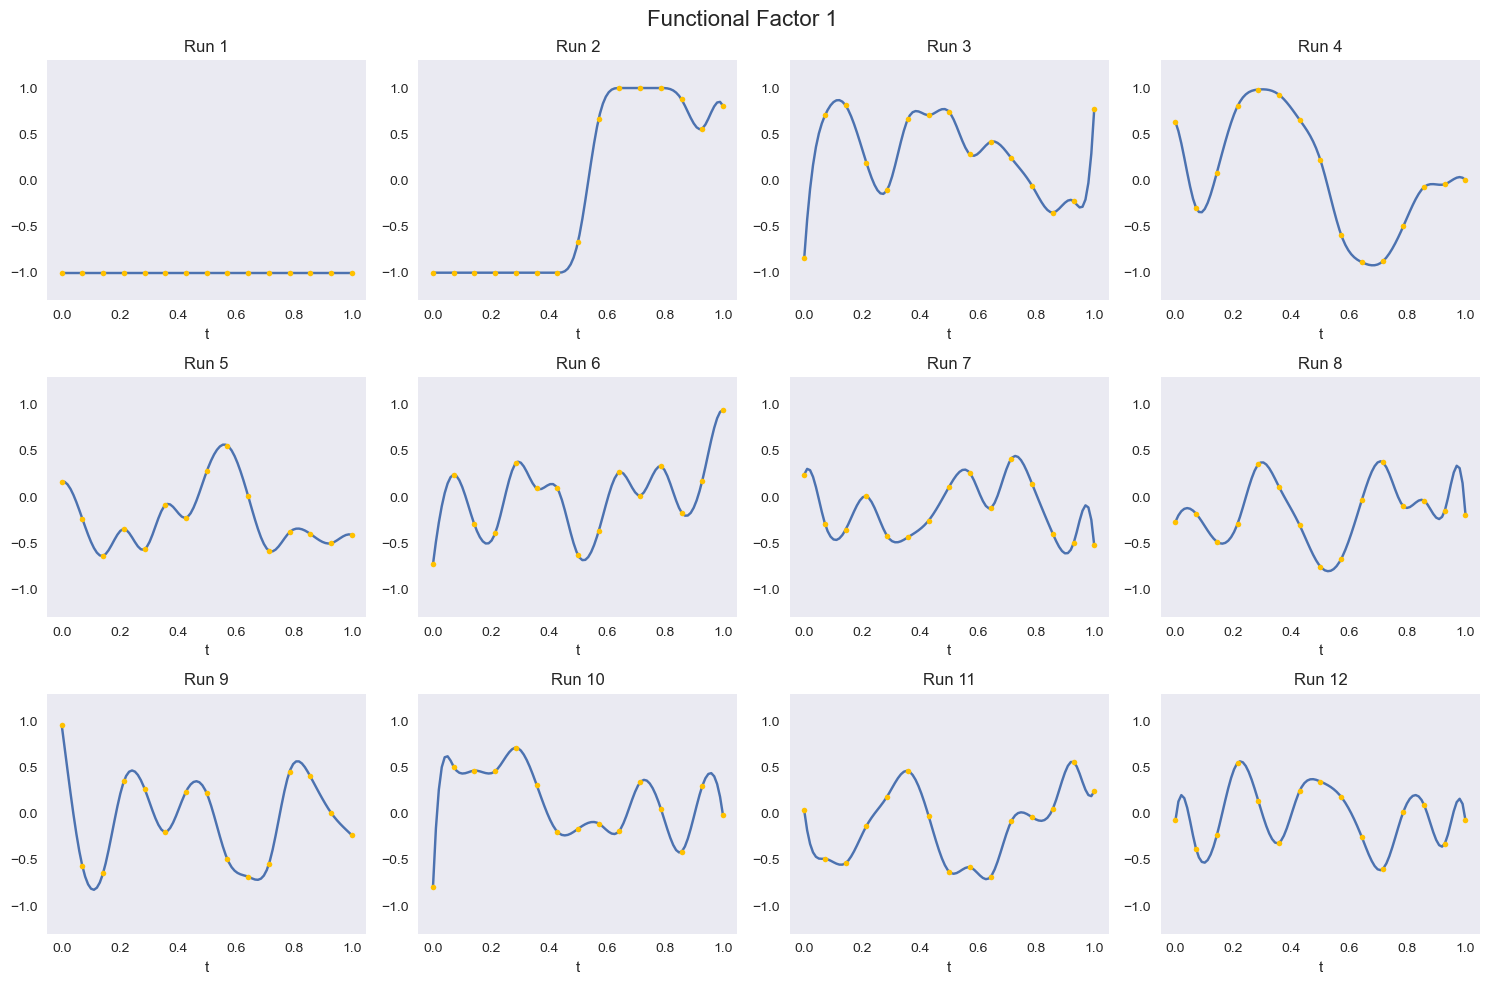

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.5583333331388098, lambda_t: 0, objective: 6.342988732466814e-06, avg_tv: 5.1863903051121065


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


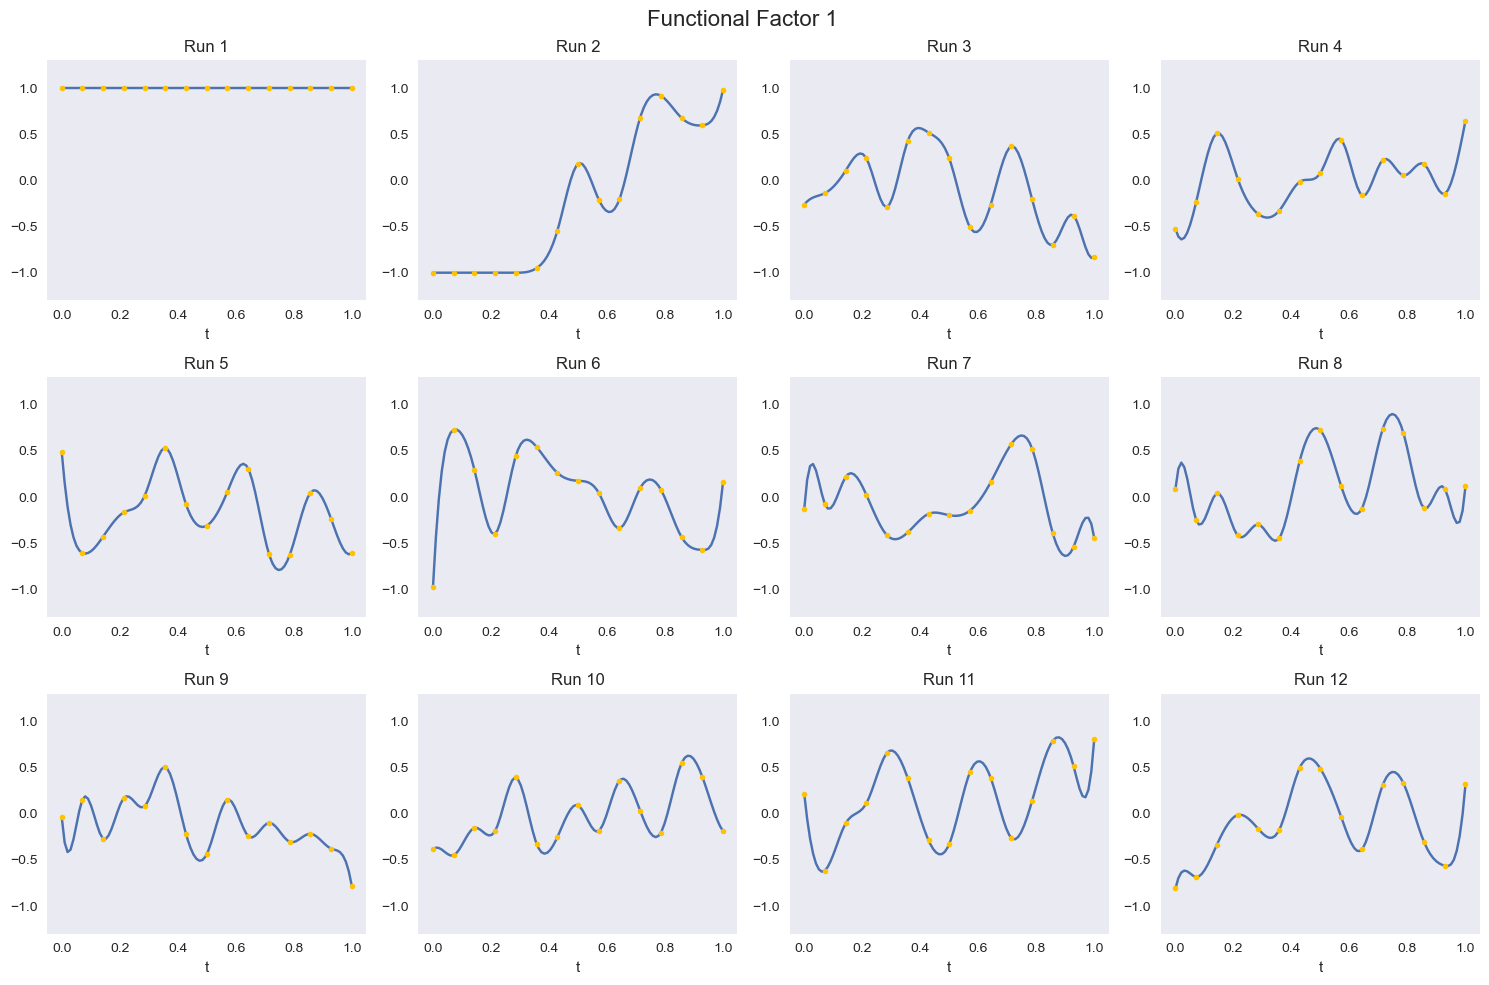

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.6499999997735398, lambda_t: 0, objective: 3.062566702092431e-06, avg_tv: 5.48665879097517


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


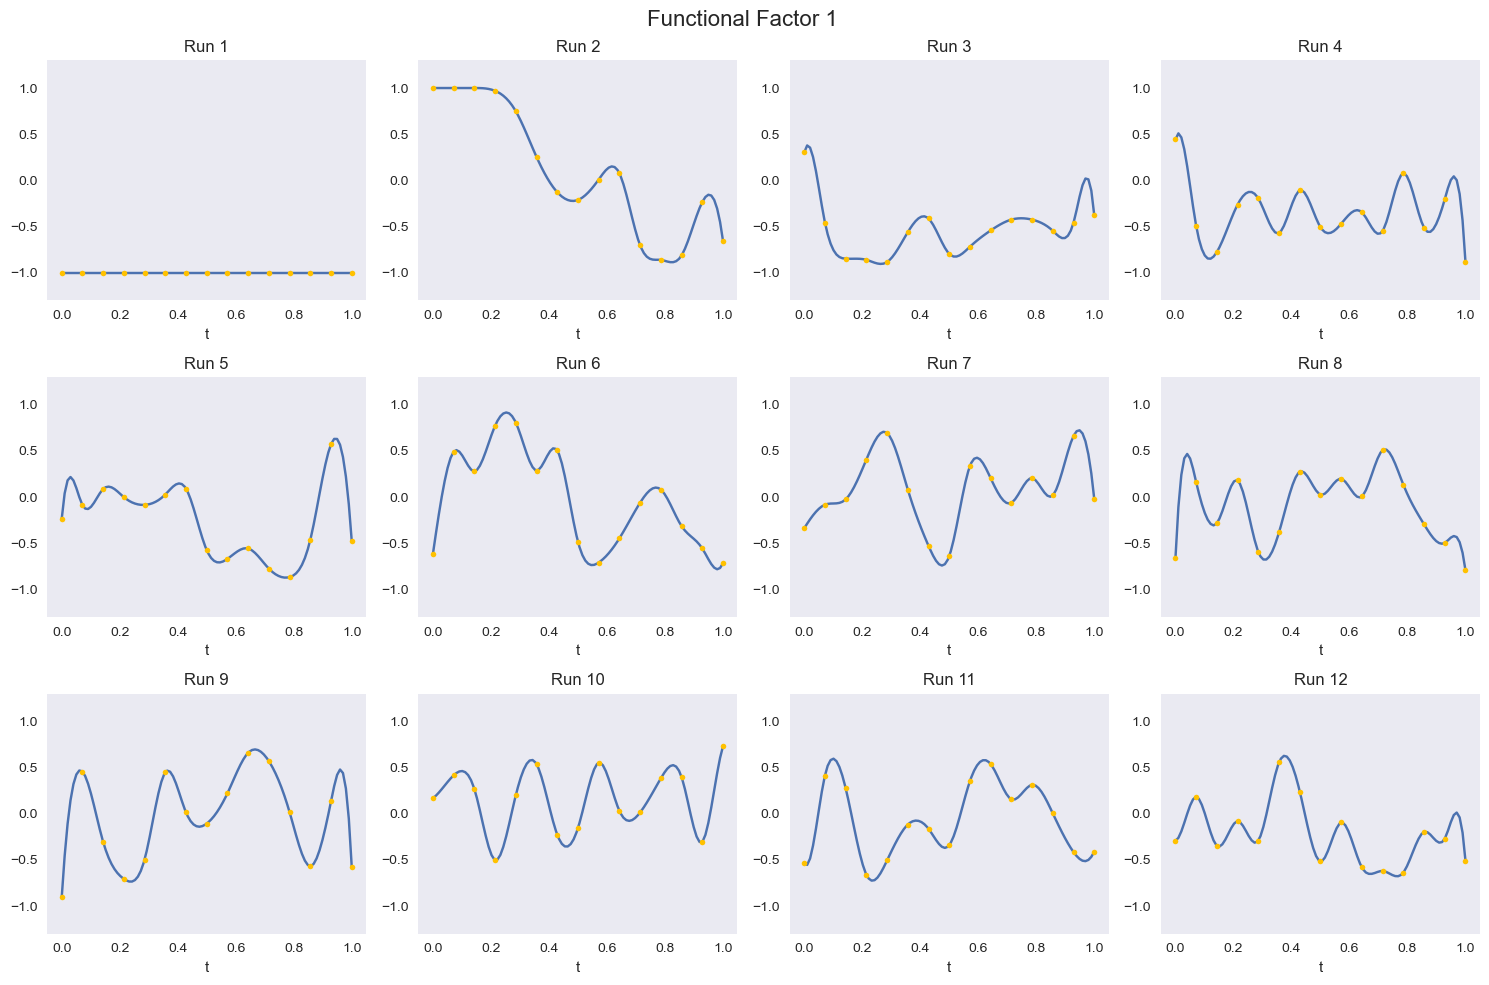

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.7416666664082698, lambda_t: 0, objective: 3.528181696470323e-06, avg_tv: 5.579019002155346


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


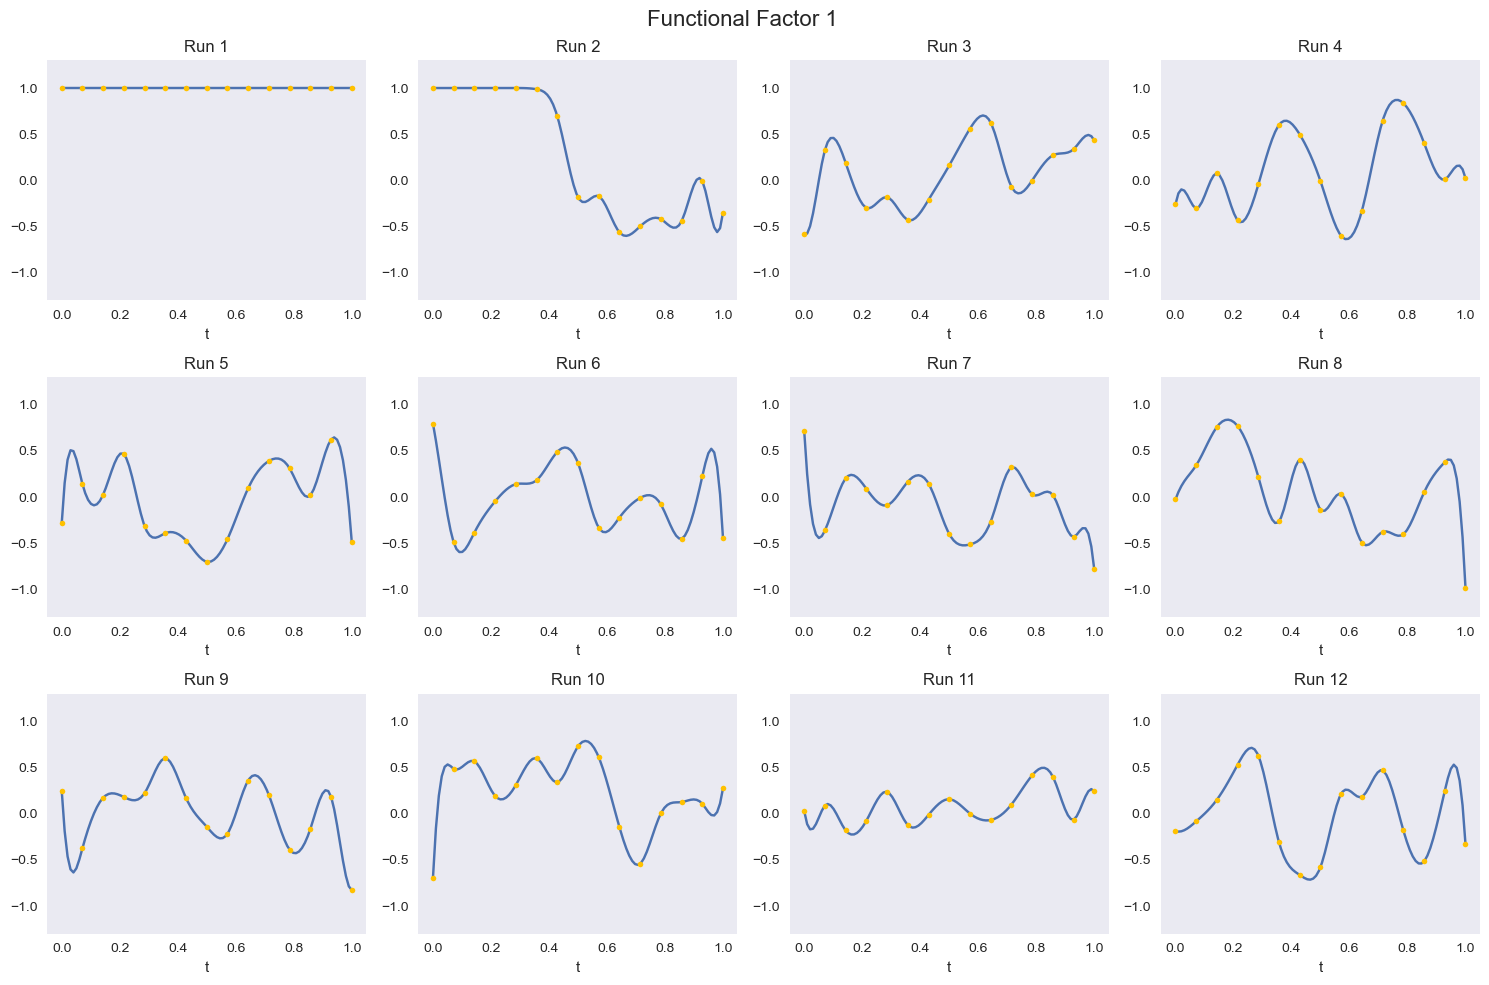

lambda_s: 0.8333333330429997, lambda_t: 0, objective: 2.5428258738207688e-06, avg_tv: 5.1284146044682


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_66052/3648193181.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


In [140]:
for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = 0
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=12)
    best_design, best_objective = optimizer.optimize(epochs=50, refinement_epochs=10)
    plot_design(best_design, [x_base], 12,
                sub_x=3, sub_y=4, colour="#FFC100")
    avg_tv = compute_average_variation(best_design, basis=x_base)
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}, avg_tv: {avg_tv}")

In [141]:
lambdas

array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ])